## Loading the graphs
We load the graph as an undirected graph.

To load the graph we are using the sister package of Embiggen called [Ensmallen](https://github.com/LucaCappelletti94/ensmallen_graph). Ensmallen is a Rust library with python bindings to handle processing of graph files and preprocessing of data for quickly training embedding models.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [2]:
graph_data_dir = "link_prediction_experiment_graph"

In [3]:
# get the graphs

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)
if not os.path.exists(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz"):
    with urllib.request.urlopen("https://zenodo.org/record/4011267/files/kg-covid-19-skipgram-aug-2020.tar.gz") as response, \
        open(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz", 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

os.system("tar -xvzf " + graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz -C " + graph_data_dir)

0

In [4]:
%%time
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path= graph_data_dir + "/merged-kg_edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    node_path= graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column="id",
    node_types_column="category",
    default_node_type="biolink:NamedThing",
    ignore_duplicated_edges=True,
    ignore_duplicated_nodes=True,
    force_conversion_to_undirected=True
)

In [5]:
graph.report()

{'edges_number': '30861027',
 'is_directed': 'false',
 'unique_edge_types_number': '0',
 'traps_rate': '0.021906677500566116',
 'connected_components_number': '8976',
 'degrees_mean': '82.21604837957722',
 'degrees_mode': '1',
 'degrees_min': '0',
 'degrees_median': '6',
 'selfloops_rate': '0.000015391581103247148',
 'singleton_nodes': '8223',
 'density': '0.00021902960686152735',
 'strongly_connected_components_number': '8976',
 'unique_node_types_number': '36',
 'degrees_max': '90378',
 'nodes_number': '375365',
 'bidirectional_rate': '1'}

In [7]:
training, validation = graph.connected_holdout(42, 0.8)

In [8]:
training.report()

{'unique_edge_types_number': '0',
 'degrees_mean': '65.77283976929122',
 'is_directed': 'false',
 'selfloops_rate': '0.000014743514291609376',
 'unique_node_types_number': '36',
 'nodes_number': '375365',
 'degrees_min': '0',
 'edges_number': '24688822',
 'bidirectional_rate': '1',
 'traps_rate': '0.021933318236916067',
 'connected_components_number': '8976',
 'degrees_median': '5',
 'density': '0.0001752236883281372',
 'degrees_max': '71988',
 'singleton_nodes': '8233',
 'degrees_mode': '1',
 'strongly_connected_components_number': '8976'}

In [9]:
validation.report()

{'traps_rate': '0.42166957494705154',
 'density': '0.000043805918533390134',
 'unique_edge_types_number': '0',
 'edges_number': '6172205',
 'bidirectional_rate': '1',
 'degrees_mode': '0',
 'connected_components_number': '162705',
 'nodes_number': '375365',
 'degrees_max': '18390',
 'singleton_nodes': '158280',
 'selfloops_rate': '0.00001798384855979346',
 'degrees_min': '0',
 'unique_node_types_number': '36',
 'degrees_mean': '16.44320861028599',
 'strongly_connected_components_number': '162705',
 'degrees_median': '1',
 'is_directed': 'false'}

The followings are check that are not necessary, but are offered as sanity checks:

In [10]:
assert graph > training
assert graph > validation
assert (training + validation).contains(graph)
assert graph.contains(training + validation)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

## Loading the embeddings

In [11]:
# https://zenodo.org/record/4019808/files/SkipGram_80_20_training_test_epoch_500_delta_0.0001_embedding.npy?download=1
embedding_dir = "link_prediction_experiment_embeddings"
embedding_file = os.path.join(embedding_dir, "SkipGram_embedding.npy")
os.makedirs(embedding_dir, exist_ok=True)

with urllib.request.urlopen("https://zenodo.org/record/4019808/files/SkipGram_80_20_training_test_epoch_500_delta_0.0001_embedding.npy") as response, \
    open(embedding_file, 'wb') as out_file:
        data = response.read()  # a `bytes` object
        out_file.write(data)

In [12]:
import numpy as np
embedding_file = "link_prediction_experiment_embeddings/SkipGram_embedding.npy"
embeddings = np.load(embedding_file)

In [13]:
node_names = list(np.array(training.nodes_reverse_mapping))

In [14]:
assert len(training.nodes_reverse_mapping) == len(embeddings)

In [15]:
assert len(training.node_types) == len(embeddings)

In [16]:
sars_cov_2_name = 'CHEMBL.TARGET:CHEMBL4303835'

In [17]:
sars_cov_2_idx = node_names.index(sars_cov_2_name)

In [18]:
drug_idx = list(np.where(training.node_types == training.node_types_reverse_mapping.index('biolink:Drug'))[0])
drug_names = [node_names[i] for i in drug_idx]

In [19]:
chem_substance_idx = list(np.where(training.node_types == training.node_types_reverse_mapping.index('biolink:ChemicalSubstance'))[0])
chem_substance_names = [node_names[i] for i in chem_substance_idx]

In [20]:
import re
chembl_prefix = 'CHEMBL.COMPOUND'
chembl_names = [x for x in node_names if (match := re.compile(chembl_prefix).search(x))]
chembl_idx = [index for index, x in enumerate(node_names) if (match := re.compile(chembl_prefix).search(x))]

## Loading trained MLP models

In [21]:
from tqdm.auto import tqdm
model_dir = "link_prediction_experiment_models"
os.makedirs(model_dir, exist_ok=True)

h5_files = ["SkipGram_weightedL2_finalized_model.h5", "SkipGram_weightedL1_finalized_model.h5", \
        "SkipGram_hadamard_finalized_model.h5", "SkipGram_average_finalized_model.h5"]
base_url = "https://zenodo.org/record/4031401/files/"

for file in tqdm(h5_files):
    with urllib.request.urlopen(base_url + file) as response, \
        open(os.path.join(model_dir, file), 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [29]:
import tensorflow as tf
mlp_model = ("average", tf.keras.models.load_model('link_prediction_experiment_models/SkipGram_average_finalized_model.h5'))

In [30]:
sars_cov_2_emb = embeddings[sars_cov_2_idx]

In [37]:
print(f"using %s model for edge embeddings" % mlp_model[0])

using average model for edge embeddings


In [32]:
from embiggen import GraphTransformer, EdgeTransformer

assert(mlp_model[0] in EdgeTransformer.methods)

transformer = GraphTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
transformer.fit(embeddings)
train_edges = transformer.transform(training)
assert(training.get_edges_number() == len(train_edges))

In [28]:
# let's try to predict a link that should exist in training graph
# example SARS-CoV-2 -> ChEMBL compound edge (which should be positive)
example_chembl_edge = train_edges[training.get_edge_id(sars_cov_2_idx, chembl_idx[0])]
example_chembl_edge.shape
example_chembl_edge.__class__
mlp_model[1].predict(example_chembl_edge.reshape(1, -1))

(100,) (1, 100)


array([[0.93010485]], dtype=float32)

In [ ]:
# previous value array([[0.93010485]], dtype=float32)

In [84]:
# prepare source (drugs) and destination (SARS-CoV-2) numpy arrays
import logging
import numpy as np
drug_idx_wo_exist_links = []
for drug_id in drug_idx:
    if not training.has_edge(drug_id, sars_cov_2_idx) and not training.has_edge(sars_cov_2_idx, drug_id):
        drug_idx_wo_exist_links.append(drug_id)
    else:
        logging.warning("Not using edge %s %s which was present in training graph" % (drug_id, sars_cov_2_idx))
drug_idx_wo_exist_links = np.asarray(drug_ids_wo_existing_links)
sars_cov_2_dest = np.repeat(sars_cov_2_idx, len(drug_idx_wo_exist_links))

In [85]:
# Make an edge transformer for drug -> SARS-CoV-2 edge for every member of drug_idx

from embiggen import GraphTransformer, EdgeTransformer
assert(mlp_model[0] in EdgeTransformer.methods)

edge_transformer = EdgeTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
assert(drug_idx_wo_exist_links.shape == sars_cov_2_dest.shape)
edge_transformer.fit(embeddings)
drug_edges = edge_transformer.transform(sources=drug_idx_wo_exist_links, destinations=sars_cov_2_dest)
assert(len(drug_idx_wo_exist_links) == len(drug_edges))

drug_prediction_pval = mlp_model[1].predict(drug_edges)

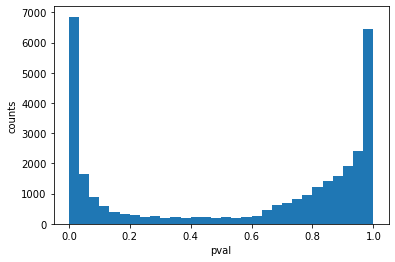

In [148]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(drug_prediction_pval, density=False, bins=30)  # `density=False` would make counts
plt.ylabel('counts')
plt.xlabel('pval');

In [147]:
sort_idx = np.argsort(drug_prediction_pval, axis=0)[::-1]

with open("drug_sars_cov2_link_prediction.tsv", "w") as out:
    out.write("graph_id\tCURIE\tpval\n")
    for idx in np.nditer(sort_idx, order='F'):
        line = f"%i    %s     %f\n" % (drug_idx_wo_exist_links[idx],
                        training.nodes_reverse_mapping[drug_idx_wo_exist_links[idx]],
                        drug_prediction_pval[idx])
        print(line)
        out.write(line)

50205    ttd.drug:D03IGB     0.999606

60674    ttd.drug:D0CH7Z     0.999595

40085    CHEBI:83527     0.999540

48755    ttd.drug:D0Y1BF     0.999404

43476    ttd.drug:D04RCT     0.999388

39995    CHEBI:5138     0.999323

67036    ttd.drug:D0K1GJ     0.999284

57511    ttd.drug:D07BMX     0.999226

45240    ttd.drug:D0N1FU     0.999218

53342    ttd.drug:D03BHO     0.999202

39037    DrugCentral:4896     0.999174

46736    ttd.drug:D03IJO     0.999122

48573    ttd.drug:D0S6SN     0.999094

45557    ttd.drug:D0TN1L     0.999081

63193    ttd.drug:D0GF4I     0.999056

39860    PHARMGKB:PA166048654     0.998953

68610    ttd.drug:D0XB1H     0.998940

39551    PHARMGKB:PA451999     0.998940

42284    ttd.drug:D03GAX     0.998936

68313    ttd.drug:D06NGR     0.998911

62114    ttd.drug:D00LVW     0.998880

56288    ttd.drug:D0E0JO     0.998874

55765    ttd.drug:D0D4LF     0.998871

50307    ttd.drug:D00QSV     0.998861

47840    ttd.drug:D08WIJ     0.998821

43119    ttd.drug:D0L5DZ  

44487    ttd.drug:D0I8CA     0.998303

41811    ttd.drug:D04FXD     0.998302

55085    ttd.drug:D0M9VZ     0.998302

53726    ttd.drug:D0Q7SF     0.998302

49261    ttd.drug:D0A8JM     0.998301

54662    ttd.drug:D0V7EK     0.998300

43443    ttd.drug:D0U3ZP     0.998300

46202    ttd.drug:D09PUW     0.998300

61516    ttd.drug:D0B6GK     0.998300

64064    ttd.drug:D0VS7X     0.998299

66011    ttd.drug:D0TK7B     0.998295

52608    ttd.drug:D0E0RP     0.998295

54619    ttd.drug:D0J5AU     0.998294

61814    ttd.drug:D0D6GI     0.998294

51933    ttd.drug:D09WKT     0.998293

54928    ttd.drug:D0WG8L     0.998292

60039    ttd.drug:D0W9ZY     0.998291

42836    ttd.drug:D0L6HX     0.998291

67091    ttd.drug:D06EDH     0.998290

47292    ttd.drug:D02DSZ     0.998290

63063    ttd.drug:D0R3IN     0.998289

51219    ttd.drug:D0X1SN     0.998288

53157    ttd.drug:D0CU9M     0.998287

52691    ttd.drug:D04JEH     0.998287

67958    ttd.drug:D05DCW     0.998287

58827    ttd.drug:D01VCB 

60579    ttd.drug:D0XB4P     0.998197

43025    ttd.drug:D0E3SH     0.998197

68494    ttd.drug:D0K7WW     0.998197

61759    ttd.drug:D08OPX     0.998197

67379    ttd.drug:D06SWT     0.998197

52573    ttd.drug:D0RD6G     0.998196

63414    ttd.drug:D01DPN     0.998196

60264    ttd.drug:D0MN3D     0.998195

58058    ttd.drug:D01JWH     0.998195

42799    ttd.drug:D08SKU     0.998195

55914    ttd.drug:D07ZCP     0.998194

67421    ttd.drug:D03CTH     0.998194

62500    ttd.drug:D0Q8CE     0.998193

54591    ttd.drug:D0Y2TE     0.998193

43681    ttd.drug:D0A4FA     0.998193

64599    ttd.drug:D0I5QL     0.998193

46419    ttd.drug:D0V4EK     0.998193

51153    ttd.drug:D0X5TB     0.998193

57505    ttd.drug:D07VFD     0.998192

67049    ttd.drug:D0C3OH     0.998192

54590    ttd.drug:D0WB1D     0.998191

67355    ttd.drug:D0L1PO     0.998191

42872    ttd.drug:D05YUT     0.998191

43696    ttd.drug:D07WFU     0.998190

41822    ttd.drug:D05EPY     0.998189

47217    ttd.drug:D0H8XV 

43616    ttd.drug:D04SJC     0.998120

49350    ttd.drug:D00AWM     0.998120

48769    ttd.drug:D0E6ON     0.998119

64105    ttd.drug:D0LL0X     0.998119

65090    ttd.drug:D0HL1X     0.998118

50168    ttd.drug:D05RJP     0.998117

67775    ttd.drug:D0NL2L     0.998117

63051    ttd.drug:D0I2AG     0.998117

55535    ttd.drug:D03LAB     0.998116

65809    ttd.drug:D0L5KK     0.998116

46190    ttd.drug:D0F1RU     0.998116

53345    ttd.drug:D0YA7R     0.998115

60267    ttd.drug:D0R9ON     0.998115

43690    ttd.drug:D0H5MV     0.998114

54903    ttd.drug:D0S8HD     0.998114

65829    ttd.drug:D0M2TG     0.998113

49377    ttd.drug:D0A0UR     0.998113

52432    ttd.drug:D04ZYA     0.998113

45415    ttd.drug:D0UK7K     0.998113

40930    ttd.drug:D02RIG     0.998112

47413    ttd.drug:D0R3LP     0.998111

44522    ttd.drug:D03CVT     0.998111

50749    ttd.drug:D0ZM5O     0.998110

66790    ttd.drug:D0D5YE     0.998110

68902    ttd.drug:D0P6GH     0.998110

45732    ttd.drug:D0I1DZ 

54732    ttd.drug:D03HBZ     0.998045

66440    ttd.drug:D08CBB     0.998045

54580    ttd.drug:D0AQ3K     0.998045

47245    ttd.drug:D05KUP     0.998045

68142    ttd.drug:D0Z7BO     0.998045

47417    ttd.drug:D0Y0KU     0.998045

56048    ttd.drug:D0X5ZA     0.998045

57762    ttd.drug:D0BC6Q     0.998045

43234    ttd.drug:D0PP3Q     0.998044

42167    ttd.drug:D00VHG     0.998044

51855    ttd.drug:D0P9BT     0.998044

56567    ttd.drug:D0I9LH     0.998044

47492    ttd.drug:D0B2TV     0.998042

59764    ttd.drug:D03MJJ     0.998042

55384    ttd.drug:D0T1GG     0.998042

64945    ttd.drug:D0N5YD     0.998041

66399    ttd.drug:D0IA5O     0.998041

69574    ttd.drug:D0I3EE     0.998041

47297    ttd.drug:D05NRI     0.998041

53192    ttd.drug:D0B8EP     0.998041

47301    ttd.drug:D03DRW     0.998041

45414    ttd.drug:D0O2HK     0.998041

41059    ttd.drug:D0A8HX     0.998040

68716    ttd.drug:D09LKZ     0.998040

52093    ttd.drug:D0F9RK     0.998040

51938    ttd.drug:D0D5SK 

60966    ttd.drug:D06AGN     0.997985

44371    ttd.drug:D0GA0Y     0.997985

44174    ttd.drug:D09TSC     0.997985

68577    ttd.drug:D0Z9TM     0.997984

56067    ttd.drug:D0HD9K     0.997984

42208    ttd.drug:D0O5GK     0.997984

61562    ttd.drug:D0U4DT     0.997984

69067    ttd.drug:D0E5TD     0.997984

52476    ttd.drug:D01YNL     0.997984

61762    ttd.drug:D0ZK2G     0.997984

63701    ttd.drug:D0R0YB     0.997983

48943    ttd.drug:D09RWW     0.997983

49375    ttd.drug:D07URD     0.997982

50394    ttd.drug:D0J2UD     0.997981

42753    ttd.drug:D0CC8L     0.997981

48516    ttd.drug:D08TDE     0.997981

68396    ttd.drug:D0O4IV     0.997981

56191    ttd.drug:D0ZL9B     0.997981

43558    ttd.drug:D01SBZ     0.997981

53129    ttd.drug:D0B8DF     0.997980

69467    ttd.drug:D0NL4R     0.997980

51247    ttd.drug:D0H6AA     0.997979

39766    DRUGBANK:DB04884     0.997979

42430    ttd.drug:D0G2WI     0.997979

69064    ttd.drug:D02YVB     0.997979

57050    ttd.drug:D05FRX

67471    ttd.drug:D0VF5B     0.997926

59797    ttd.drug:D0L0QR     0.997926

55548    ttd.drug:D02QQB     0.997925

65065    ttd.drug:D0B7AH     0.997924

42874    ttd.drug:D0W7VX     0.997923

62045    ttd.drug:D03POY     0.997923

56945    ttd.drug:D05JGX     0.997923

44550    ttd.drug:D02RZC     0.997922

41066    ttd.drug:D05KJX     0.997922

50833    ttd.drug:D0T6MU     0.997922

63759    ttd.drug:D05MEW     0.997922

67523    ttd.drug:D0AK2Y     0.997922

57801    ttd.drug:D0H3CW     0.997922

47324    ttd.drug:D07TGY     0.997921

43102    ttd.drug:D0YT8O     0.997921

45739    ttd.drug:D0T5TU     0.997921

65983    ttd.drug:D00YQI     0.997920

61972    ttd.drug:D04KKT     0.997920

51666    ttd.drug:D04MOF     0.997920

54608    ttd.drug:D04ZWS     0.997920

60883    ttd.drug:D0MC3R     0.997920

54612    ttd.drug:D03UCC     0.997918

69025    ttd.drug:D05SSB     0.997918

59577    ttd.drug:D07JRL     0.997918

62988    ttd.drug:D06VYT     0.997918

65116    ttd.drug:D0R2AI 

50334    ttd.drug:D0J2ID     0.997871

60046    ttd.drug:D05HSI     0.997871

60230    ttd.drug:D0S9NB     0.997871

68080    ttd.drug:D00RAK     0.997870

58855    ttd.drug:D0Z0VL     0.997870

67525    ttd.drug:D0Y3UB     0.997870

43084    ttd.drug:D0BY1R     0.997869

47163    ttd.drug:D0Y2HR     0.997869

53250    ttd.drug:D0QG9A     0.997869

67585    ttd.drug:D07CMZ     0.997868

53328    ttd.drug:D0UI7K     0.997868

51630    ttd.drug:D0FG6M     0.997868

49326    ttd.drug:D01PYU     0.997867

40989    ttd.drug:D09KWS     0.997867

54572    ttd.drug:D0A5FO     0.997867

52546    ttd.drug:D0W5ZQ     0.997866

65449    ttd.drug:D07ADU     0.997866

46011    ttd.drug:D08PIE     0.997866

67090    ttd.drug:D0WL1Z     0.997864

54643    ttd.drug:D0B0ZM     0.997864

62047    ttd.drug:D0L5KF     0.997864

64066    ttd.drug:D0OK3K     0.997864

60114    ttd.drug:D0V2NH     0.997863

43517    ttd.drug:D0IZ1D     0.997863

56608    ttd.drug:D07CNY     0.997863

43168    ttd.drug:D03ZUZ 

66047    ttd.drug:D06UPS     0.997806

52415    ttd.drug:D04JUJ     0.997805

40990    ttd.drug:D0AC7C     0.997805

53718    ttd.drug:D0G5ET     0.997804

58278    ttd.drug:D0HR8H     0.997804

55184    ttd.drug:D0Q0IE     0.997804

54912    ttd.drug:D01WJM     0.997804

60239    ttd.drug:D0W6PE     0.997803

47574    ttd.drug:D08YGW     0.997803

57058    ttd.drug:D09XOC     0.997802

41027    ttd.drug:D0E3SF     0.997802

65400    ttd.drug:D0KK9E     0.997802

63642    ttd.drug:D0MW7B     0.997801

54617    ttd.drug:D01MAC     0.997801

54570    ttd.drug:D0P3VH     0.997800

54932    ttd.drug:D0Y2NA     0.997800

59914    ttd.drug:D04TSP     0.997800

53627    ttd.drug:D0Q0IR     0.997800

69555    ttd.drug:D02DXP     0.997800

40886    ttd.drug:D04DHZ     0.997800

49180    ttd.drug:D07ANB     0.997800

62083    ttd.drug:D0F5JY     0.997800

52958    ttd.drug:D06RCS     0.997799

46014    ttd.drug:D0KX7I     0.997799

42274    ttd.drug:D0R6RT     0.997799

66314    ttd.drug:D0BI1O 

69460    ttd.drug:D0S9UQ     0.997733

42755    ttd.drug:D0H0FX     0.997733

48983    ttd.drug:D01UAS     0.997732

42823    ttd.drug:D07QAX     0.997732

43633    ttd.drug:D00OLX     0.997732

51779    ttd.drug:D0DR6N     0.997731

47393    ttd.drug:D06EIP     0.997731

69109    ttd.drug:D0T5NX     0.997731

68583    ttd.drug:D0D7NA     0.997730

60238    ttd.drug:D0KT3B     0.997730

55569    ttd.drug:D0F6TS     0.997730

47323    ttd.drug:D0RM9Q     0.997730

54628    ttd.drug:D08BKE     0.997730

41033    ttd.drug:D0W3LI     0.997730

57520    ttd.drug:D0Q3KV     0.997730

64445    ttd.drug:D0L9KW     0.997729

47467    ttd.drug:D0O1GE     0.997729

42891    ttd.drug:D0T4SL     0.997729

61007    ttd.drug:D07VIK     0.997729

63032    ttd.drug:D0UK7B     0.997728

45861    ttd.drug:D0L4PY     0.997728

46404    ttd.drug:D0J5GT     0.997728

51377    ttd.drug:D05HOH     0.997728

43641    ttd.drug:D0D2YR     0.997728

68411    ttd.drug:D03IWC     0.997727

51906    ttd.drug:D0S6NP 

42835    ttd.drug:D00UOI     0.997673

40915    ttd.drug:D0E2CQ     0.997673

47473    ttd.drug:D06ETG     0.997672

66423    ttd.drug:D02IYC     0.997672

64625    ttd.drug:D01FAA     0.997672

67262    ttd.drug:D0B2AE     0.997672

62707    ttd.drug:D0EL3A     0.997672

50903    ttd.drug:D0G5QB     0.997671

48409    ttd.drug:D0D8AK     0.997671

50425    ttd.drug:D0F1DY     0.997671

56545    ttd.drug:D0M5EC     0.997671

62159    ttd.drug:D0RS4B     0.997670

63391    ttd.drug:D0D1GI     0.997670

51864    ttd.drug:D02TKV     0.997670

56867    ttd.drug:D07DCG     0.997670

52094    ttd.drug:D04NUS     0.997670

47458    ttd.drug:D0P7SY     0.997669

55717    ttd.drug:D08QYJ     0.997669

40926    ttd.drug:D02ZRO     0.997668

53091    ttd.drug:D06MIW     0.997668

41983    ttd.drug:D09HNP     0.997668

59063    ttd.drug:D0T6PV     0.997668

60294    ttd.drug:D0PQ8B     0.997668

45675    ttd.drug:D0DT1R     0.997668

67372    ttd.drug:D0G9KS     0.997667

66007    ttd.drug:D06RLO 

56103    ttd.drug:D0D6AC     0.997599

55322    ttd.drug:D08HUB     0.997599

47463    ttd.drug:D01DEU     0.997598

42113    ttd.drug:D0F6TM     0.997598

58224    ttd.drug:D09TGZ     0.997597

67442    ttd.drug:D03RXE     0.997597

66427    ttd.drug:D0T3QU     0.997597

53625    ttd.drug:D0YP0T     0.997597

43821    ttd.drug:D05GYO     0.997596

50396    ttd.drug:D03CEP     0.997596

62980    ttd.drug:D02BPT     0.997595

54647    ttd.drug:D0M6IJ     0.997594

60759    ttd.drug:D0A4ZR     0.997594

58396    ttd.drug:D0C3SW     0.997594

68424    ttd.drug:D0X3TX     0.997594

54792    ttd.drug:D0Z6WI     0.997593

40966    ttd.drug:D0NH7M     0.997593

50854    ttd.drug:D07YFY     0.997593

42086    ttd.drug:D0Z5IU     0.997593

55714    ttd.drug:D0Z4KX     0.997593

56811    ttd.drug:D0Y1UG     0.997592

45837    ttd.drug:D05YFF     0.997592

64824    ttd.drug:D08ZDI     0.997592

68036    ttd.drug:D0Q8BK     0.997591

44423    ttd.drug:D0VY5O     0.997591

49601    ttd.drug:D0H5BC 

64460    ttd.drug:D0R9BP     0.997510

42122    ttd.drug:D04GYD     0.997510

54760    ttd.drug:D07OAF     0.997509

51200    ttd.drug:D0V2PM     0.997509

43911    ttd.drug:D0SM0J     0.997509

43824    ttd.drug:D0D9PD     0.997509

63162    ttd.drug:D0F2SQ     0.997509

55415    ttd.drug:D0ZE2J     0.997509

43120    ttd.drug:D0UC6H     0.997509

43669    ttd.drug:D0P3DV     0.997509

55436    ttd.drug:D07ESG     0.997509

51472    ttd.drug:D02CKX     0.997509

51363    ttd.drug:D0B1JC     0.997508

62921    ttd.drug:D0H2BL     0.997507

44889    ttd.drug:D0G5UW     0.997507

52893    ttd.drug:D0Q5YP     0.997506

55528    ttd.drug:D0S7JH     0.997506

58315    ttd.drug:D08ENK     0.997505

62920    ttd.drug:D02PBS     0.997505

59069    ttd.drug:D00ITG     0.997505

60375    ttd.drug:D0T6WL     0.997504

41067    ttd.drug:D0SB0W     0.997503

45076    ttd.drug:D01CUJ     0.997503

42443    ttd.drug:D09MCN     0.997503

65615    ttd.drug:D08RJY     0.997503

67422    ttd.drug:D0N4TO 

54887    ttd.drug:D09OLZ     0.997402

55428    ttd.drug:D0DA6B     0.997402

67580    ttd.drug:D0O1RL     0.997401

64475    ttd.drug:D02NMG     0.997400

58020    ttd.drug:D04TVU     0.997400

69032    ttd.drug:D05RSP     0.997400

41080    ttd.drug:D0O9YG     0.997399

52535    ttd.drug:D0EP0C     0.997399

45723    ttd.drug:D0Z4EI     0.997396

46083    ttd.drug:D02TGW     0.997395

53831    ttd.drug:D0V0VI     0.997395

57802    ttd.drug:D07QCC     0.997395

54955    ttd.drug:D0C0HP     0.997394

67024    ttd.drug:D07KNI     0.997394

64242    ttd.drug:D0E1YT     0.997393

48926    ttd.drug:D0D6IU     0.997393

55512    ttd.drug:D0O6GN     0.997393

50481    ttd.drug:D03YDP     0.997392

51324    ttd.drug:D05EWZ     0.997392

60085    ttd.drug:D0S4CE     0.997392

66145    ttd.drug:D0M9TO     0.997391

67022    ttd.drug:D0LZ4A     0.997391

50795    ttd.drug:D0N8UY     0.997390

63185    ttd.drug:D09EJG     0.997390

43547    ttd.drug:D04UYZ     0.997388

67498    ttd.drug:D0YX4L 

60286    ttd.drug:D0E0EQ     0.997271

54567    ttd.drug:D0J1IX     0.997271

43643    ttd.drug:D05FMZ     0.997271

62201    ttd.drug:D01SPD     0.997269

41031    ttd.drug:D0Y7TS     0.997269

59023    ttd.drug:D04WRK     0.997269

44822    ttd.drug:D0Y5ZT     0.997269

46749    ttd.drug:D0I1RW     0.997268

55385    ttd.drug:D0X2BP     0.997268

41086    ttd.drug:D0H8AW     0.997267

46241    ttd.drug:D01OHD     0.997266

52538    ttd.drug:D05RZE     0.997265

44565    ttd.drug:D0JC4J     0.997262

53957    ttd.drug:D04LRN     0.997262

68818    ttd.drug:D0L6RV     0.997261

52428    ttd.drug:D0M9TM     0.997261

59585    ttd.drug:D01GEO     0.997261

69549    ttd.drug:D00IWH     0.997260

60368    ttd.drug:D06NDT     0.997259

45740    ttd.drug:D03WNG     0.997259

69341    ttd.drug:D06XQX     0.997259

56199    ttd.drug:D0A1GE     0.997258

62668    ttd.drug:D09GZQ     0.997258

43546    ttd.drug:D0S7FP     0.997255

43454    ttd.drug:D0ST4P     0.997255

65925    ttd.drug:D0D6MO 

44527    ttd.drug:D09ZLZ     0.997049

47132    ttd.drug:D0YG7M     0.997048

57449    ttd.drug:D0N8JG     0.997048

48569    ttd.drug:D04VGL     0.997048

66853    ttd.drug:D0PO8M     0.997044

61082    ttd.drug:D0S9XV     0.997042

67505    ttd.drug:D0QU6N     0.997042

39726    CHEBI:9130     0.997038

47200    ttd.drug:D0PB6B     0.997032

54891    ttd.drug:D04ODH     0.997031

59048    ttd.drug:D03WPA     0.997031

43471    ttd.drug:D0I2VK     0.997030

47352    ttd.drug:D0PM2S     0.997030

62061    ttd.drug:D06WNK     0.997021

52067    ttd.drug:D0TR5T     0.997016

44049    ttd.drug:D06OAL     0.997015

67508    ttd.drug:D00KKD     0.997013

60751    ttd.drug:D09VPP     0.997012

50411    ttd.drug:D06NXG     0.997010

69017    ttd.drug:D0JP7S     0.997008

69183    ttd.drug:D0M1KX     0.997008

62088    ttd.drug:D0G3IT     0.997008

47704    ttd.drug:D09KKU     0.997007

53720    ttd.drug:D0R4JZ     0.997007

63643    ttd.drug:D02YPU     0.997006

62399    ttd.drug:D0M9RQ     0

64062    ttd.drug:D0J0UC     0.996676

43499    ttd.drug:D0I9CK     0.996675

53616    ttd.drug:D0E9JD     0.996669

61513    ttd.drug:D05HBM     0.996665

64987    ttd.drug:D08MHD     0.996664

67524    ttd.drug:D0CN7A     0.996663

40872    ttd.drug:D02BYZ     0.996662

43580    ttd.drug:D03PXS     0.996659

61823    ttd.drug:D0Z7YK     0.996658

46290    ttd.drug:D02CCB     0.996655

58449    ttd.drug:D0R4GX     0.996655

52121    ttd.drug:D0K3OK     0.996655

67359    ttd.drug:D07RQA     0.996654

54918    ttd.drug:D0B6LL     0.996654

47522    ttd.drug:D02AQM     0.996654

43318    ttd.drug:D0H7XL     0.996654

39237    DrugCentral:5251     0.996652

49548    ttd.drug:D05KQC     0.996650

51489    ttd.drug:D01QNX     0.996650

64373    ttd.drug:D00YFP     0.996648

46622    ttd.drug:D0R3UI     0.996645

47307    ttd.drug:D0N7QP     0.996642

49032    ttd.drug:D01PNV     0.996635

51555    ttd.drug:D0F0YZ     0.996634

42345    ttd.drug:D0LT0T     0.996625

60711    ttd.drug:D05XLO

39425    CHEBI:9123     0.996027

43249    ttd.drug:D0K8MF     0.996023

39958    CHEBI:73275     0.996017

43912    ttd.drug:D0J4ZH     0.996009

48717    ttd.drug:D0M5XV     0.996007

47242    ttd.drug:D0R2SK     0.996001

51799    ttd.drug:D0GC3U     0.995982

47316    ttd.drug:D0B8WQ     0.995979

51066    ttd.drug:D02VUL     0.995977

45764    ttd.drug:D04QEC     0.995972

59283    ttd.drug:D01WKZ     0.995965

51065    ttd.drug:D0TA3V     0.995957

54702    ttd.drug:D00BWF     0.995956

39483    DRUGBANK:DB00762     0.995954

43510    ttd.drug:D0AH9P     0.995952

42844    ttd.drug:D0G2QW     0.995947

43576    ttd.drug:D0R5EW     0.995945

45743    ttd.drug:D09UFV     0.995944

38147    DrugCentral:2042     0.995940

55545    ttd.drug:D07YHT     0.995940

50691    ttd.drug:D0RK3S     0.995924

54968    ttd.drug:D06HYG     0.995919

56675    ttd.drug:D0QM9Y     0.995919

54679    ttd.drug:D0G2XM     0.995909

39248    DrugCentral:5270     0.995907

62942    ttd.drug:D0Q5FJ     0.

38564    DrugCentral:2847     0.994762

57447    ttd.drug:D02TJT     0.994752

54575    ttd.drug:D05DIN     0.994750

46232    ttd.drug:D05UOW     0.994742

63763    ttd.drug:D08SOE     0.994716

62718    ttd.drug:D0B6PX     0.994700

39691    PHARMGKB:PA151249535     0.994676

41966    ttd.drug:D07QHM     0.994673

69276    ttd.drug:D0AY5T     0.994671

68408    ttd.drug:D09BVA     0.994671

52117    ttd.drug:D02HWP     0.994669

60777    ttd.drug:D0L4VR     0.994664

49402    ttd.drug:D0S0GM     0.994661

39348    PHARMGKB:PA164712331     0.994650

51202    ttd.drug:D0P8NZ     0.994618

69151    ttd.drug:D04RGN     0.994617

55439    ttd.drug:D0MA6I     0.994611

45130    ttd.drug:D0XB0Q     0.994610

39446    DRUGBANK:DB01590     0.994581

56877    ttd.drug:D0C2XI     0.994572

52597    ttd.drug:D0A6DY     0.994565

65970    ttd.drug:D0PY3L     0.994542

54571    ttd.drug:D0YZ3E     0.994534

59794    ttd.drug:D0I8FV     0.994512

45501    ttd.drug:D0Q0XV     0.994503

43589    ttd.

67144    ttd.drug:D07ZNP     0.992902

46933    ttd.drug:D03EHR     0.992892

37361    DrugCentral:624     0.992889

40012    CHEBI:5264     0.992884

66337    ttd.drug:D00QYH     0.992882

69097    ttd.drug:D0Z9NS     0.992873

52128    ttd.drug:D0PW4C     0.992867

42391    ttd.drug:D0W8NK     0.992867

60727    ttd.drug:D0R4DK     0.992863

64252    ttd.drug:D0SQ4B     0.992859

40550    PHARMGKB:PA451140     0.992851

44936    ttd.drug:D03LRU     0.992840

39320    DrugCentral:5362     0.992829

48759    ttd.drug:D0F2XQ     0.992821

69315    ttd.drug:D08LXU     0.992809

52975    ttd.drug:D04LDP     0.992791

68626    ttd.drug:D05XTX     0.992764

49288    ttd.drug:D07MKL     0.992763

65218    ttd.drug:D0RA9C     0.992757

37728    DrugCentral:1245     0.992738

48088    ttd.drug:D00ASZ     0.992727

42824    ttd.drug:D0Q6WP     0.992721

60260    ttd.drug:D0WI3N     0.992707

40982    ttd.drug:D0D0YK     0.992700

44519    ttd.drug:D0G1IV     0.992700

39427    DRUGBANK:DB00811 

62951    ttd.drug:D05HSW     0.990948

54728    ttd.drug:D0ZC4S     0.990941

37074    DrugCentral:78     0.990934

60739    ttd.drug:D0P7RN     0.990924

64356    ttd.drug:D0T3YY     0.990913

43826    ttd.drug:D09DVB     0.990888

44769    ttd.drug:D0QL1V     0.990888

44586    ttd.drug:D0J8RR     0.990871

44960    ttd.drug:D07WDQ     0.990863

38550    DrugCentral:2826     0.990852

42248    ttd.drug:D0T0CB     0.990846

62187    ttd.drug:D0L8YY     0.990837

55100    ttd.drug:D0MR4N     0.990826

42485    ttd.drug:D07YQY     0.990826

64254    ttd.drug:D0TC1M     0.990818

66233    ttd.drug:D09FGL     0.990797

47711    ttd.drug:D06BPU     0.990791

46572    ttd.drug:D01AJO     0.990789

55344    ttd.drug:D0XB2Z     0.990781

44087    ttd.drug:D0AD8G     0.990777

54139    ttd.drug:D0DR7W     0.990764

43278    ttd.drug:D01XYJ     0.990758

40359    DRUGBANK:DB04844     0.990758

39634    CHEBI:2386     0.990756

64539    ttd.drug:D03TAN     0.990742

41130    ttd.drug:D0G5GJ     

69094    ttd.drug:D0C4DE     0.989061

42937    ttd.drug:D07OLQ     0.989060

38975    DrugCentral:4733     0.989058

49493    ttd.drug:D03WYF     0.989055

44859    ttd.drug:D02OCD     0.989050

40538    PHARMGKB:PA166152940     0.989041

37666    DrugCentral:1129     0.989040

66669    ttd.drug:D07BXV     0.988984

69307    ttd.drug:D0M2PP     0.988974

57474    ttd.drug:D0K6RG     0.988959

39677    CHEBI:9334     0.988953

38509    DrugCentral:2751     0.988952

51979    ttd.drug:D0UT2X     0.988941

44434    ttd.drug:D0W7XH     0.988934

43765    ttd.drug:D0H3XF     0.988928

59455    ttd.drug:D01FOK     0.988926

51329    ttd.drug:D00FZN     0.988925

40684    CHEBI:35553     0.988904

66484    ttd.drug:D08ZKN     0.988892

37984    DrugCentral:1757     0.988887

57708    ttd.drug:D08ECB     0.988883

44842    ttd.drug:D0P1TY     0.988873

51403    ttd.drug:D0G6CD     0.988855

64626    ttd.drug:D05TZN     0.988853

49878    ttd.drug:D0H2TS     0.988846

69169    ttd.drug:D0F0CP 

44343    ttd.drug:D01PYO     0.986947

57842    ttd.drug:D08OLR     0.986938

65906    ttd.drug:D0KT5E     0.986934

57733    ttd.drug:D0X3PD     0.986900

52592    ttd.drug:D0O9DK     0.986892

55812    ttd.drug:D0F1RL     0.986878

62973    ttd.drug:D08BDI     0.986867

62183    ttd.drug:D0M7TP     0.986863

47041    ttd.drug:D02EZF     0.986861

67821    ttd.drug:D0ZT0F     0.986856

64871    ttd.drug:D02TZT     0.986855

61240    ttd.drug:D0N1SH     0.986841

65464    ttd.drug:D0P9YQ     0.986841

65937    ttd.drug:D01TDY     0.986832

43842    ttd.drug:D0R6RE     0.986823

66965    ttd.drug:D0C8BV     0.986796

66088    ttd.drug:D02XYA     0.986776

38784    DrugCentral:4146     0.986774

38518    DrugCentral:2767     0.986758

67986    ttd.drug:D0X6XF     0.986745

48636    ttd.drug:D0XJ7N     0.986734

39493    CHEBI:9396     0.986725

56475    ttd.drug:D0B0UF     0.986716

69512    ttd.drug:D0Q7JJ     0.986712

63983    ttd.drug:D0T5DC     0.986708

68499    ttd.drug:D0A9LB    

43806    ttd.drug:D0R7BX     0.984669

52609    ttd.drug:D0Q0RX     0.984663

63786    ttd.drug:D08YWE     0.984658

46339    ttd.drug:D0M7EI     0.984654

38745    DrugCentral:3931     0.984644

39793    CHEBI:27446     0.984594

38091    DrugCentral:1942     0.984565

41089    ttd.drug:D0H4NN     0.984498

38256    DrugCentral:2269     0.984489

48616    ttd.drug:D05IQX     0.984481

47053    ttd.drug:D0OE1R     0.984462

38261    DrugCentral:2276     0.984458

37895    DrugCentral:1583     0.984431

40581    DRUGBANK:DB01267     0.984428

60206    ttd.drug:D08UVX     0.984409

56531    ttd.drug:D0M7XS     0.984406

67784    ttd.drug:D06RCI     0.984382

62991    ttd.drug:D09UZL     0.984344

37919    DrugCentral:1621     0.984339

40667    DRUGBANK:DB00465     0.984338

49985    ttd.drug:D07EFM     0.984330

66455    ttd.drug:D0G7ZT     0.984326

59415    ttd.drug:D00ZZJ     0.984319

45799    ttd.drug:D0AD6Z     0.984318

51787    ttd.drug:D0OD8T     0.984302

39971    CHEBI:8495  

39922    PHARMGKB:PA164924493     0.982354

51668    ttd.drug:D0GP4R     0.982350

56433    ttd.drug:D0T6KI     0.982345

66139    ttd.drug:D05OXZ     0.982341

38148    DrugCentral:2043     0.982326

37540    DrugCentral:920     0.982299

46924    ttd.drug:D03QZB     0.982298

43465    ttd.drug:D0PP6Y     0.982298

64485    ttd.drug:D0ZJ6Y     0.982288

39904    DRUGBANK:DB06726     0.982288

61662    ttd.drug:D0Z7GN     0.982279

44029    ttd.drug:D0P6FN     0.982266

46531    ttd.drug:D00OPX     0.982263

53589    ttd.drug:D0C8XX     0.982252

44115    ttd.drug:D04DMO     0.982250

49556    ttd.drug:D0B5ZA     0.982242

50928    ttd.drug:D01UXW     0.982227

38870    DrugCentral:4353     0.982213

57965    ttd.drug:D04NTJ     0.982206

51789    ttd.drug:D0B1CU     0.982188

50222    ttd.drug:D0WC8M     0.982176

37068    DrugCentral:66     0.982171

55213    ttd.drug:D05LDQ     0.982165

44260    ttd.drug:D05HGU     0.982115

57986    ttd.drug:D01FDN     0.982106

42426    ttd.drug:

38396    DrugCentral:2537     0.980086

38576    DrugCentral:2868     0.980075

40383    CHEBI:2666     0.980060

64596    ttd.drug:D0L8VA     0.980054

46132    ttd.drug:D0UG1W     0.980040

50574    ttd.drug:D0P5GE     0.980036

63542    ttd.drug:D0ZY8G     0.980003

40235    CHEBI:91749     0.980002

41391    ttd.drug:D0T0HM     0.979994

39573    PHARMGKB:PA164713220     0.979990

58300    ttd.drug:D05BJD     0.979965

55484    ttd.drug:D0G0NB     0.979957

38843    DrugCentral:4265     0.979929

37949    DrugCentral:1690     0.979923

39422    CHEBI:3387     0.979914

57217    ttd.drug:D0WX4W     0.979892

46710    ttd.drug:D0J4DJ     0.979874

60620    ttd.drug:D0U9IQ     0.979872

38040    DrugCentral:1842     0.979869

47427    ttd.drug:D0B3QN     0.979858

49783    ttd.drug:D0ZU5W     0.979857

41912    ttd.drug:D09UGG     0.979855

46949    ttd.drug:D0D7FN     0.979847

45262    ttd.drug:D0H1JX     0.979817

41551    ttd.drug:D0Q5JV     0.979817

44819    ttd.drug:D0J1WI     

38573    DrugCentral:2863     0.977754

60911    ttd.drug:D0YZ9Y     0.977748

38169    DrugCentral:2090     0.977747

37324    DrugCentral:547     0.977717

56246    ttd.drug:D0W8XT     0.977713

56076    ttd.drug:D03GCJ     0.977685

42055    ttd.drug:D0UH8J     0.977683

47866    ttd.drug:D02STN     0.977683

42071    ttd.drug:D0IX7O     0.977672

52574    ttd.drug:D0I1AF     0.977628

39959    CHEBI:3441     0.977622

63959    ttd.drug:D05BTF     0.977620

39344    CHEBI:45783     0.977619

39375    CHEBI:10093     0.977616

51116    ttd.drug:D05TOY     0.977585

50918    ttd.drug:D0Q2HO     0.977580

61697    ttd.drug:D01CEG     0.977570

38196    DrugCentral:2139     0.977552

38815    DrugCentral:4190     0.977540

63753    ttd.drug:D05CYD     0.977538

55887    ttd.drug:D0K8WE     0.977534

46878    ttd.drug:D0N2WA     0.977515

53654    ttd.drug:D08QHX     0.977514

60023    ttd.drug:D0XD5A     0.977490

59443    ttd.drug:D01NXU     0.977485

60658    ttd.drug:D0I4RK     0.977

37199    DrugCentral:313     0.975301

60554    ttd.drug:D0E2LU     0.975290

64813    ttd.drug:D09OHS     0.975282

66543    ttd.drug:D0Z4NW     0.975266

68849    ttd.drug:D0IR8J     0.975245

38184    DrugCentral:2121     0.975218

51590    ttd.drug:D08LJJ     0.975214

49473    ttd.drug:D0I0AQ     0.975211

39413    CHEBI:7936     0.975208

39144    DrugCentral:5039     0.975189

48876    ttd.drug:D0B6WH     0.975184

44464    ttd.drug:D0F7PZ     0.975175

50727    ttd.drug:D02CWE     0.975156

44844    ttd.drug:D08VLT     0.975139

59452    ttd.drug:D02MAK     0.975100

53010    ttd.drug:D0DF6B     0.975091

39896    PHARMGKB:PA164712308     0.975081

42368    ttd.drug:D0FS3L     0.975057

47116    ttd.drug:D00TLN     0.975042

63285    ttd.drug:D0LI2I     0.975023

51591    ttd.drug:D0A4UQ     0.975021

50584    ttd.drug:D06LYG     0.975017

61795    ttd.drug:D06IGT     0.974989

65177    ttd.drug:D0R2CI     0.974971

37844    DrugCentral:1499     0.974966

64343    ttd.drug:D0EN

38110    DrugCentral:1968     0.972645

60860    ttd.drug:D0Z4NU     0.972637

37262    DrugCentral:408     0.972628

61454    ttd.drug:D0FV7K     0.972605

37538    DrugCentral:916     0.972588

68070    ttd.drug:D05QKM     0.972584

69043    ttd.drug:D0LH7O     0.972582

60131    ttd.drug:D0H9EY     0.972559

37488    DrugCentral:832     0.972553

64560    ttd.drug:D00EON     0.972530

59349    ttd.drug:D05KIF     0.972497

51321    ttd.drug:D0D3UB     0.972491

50847    ttd.drug:D07KDH     0.972465

69456    ttd.drug:D0K7CV     0.972436

56481    ttd.drug:D05FPZ     0.972380

56118    ttd.drug:D00CGX     0.972366

66426    ttd.drug:D0N3BB     0.972362

49089    ttd.drug:D06UFH     0.972359

64044    ttd.drug:D0B1KT     0.972341

38187    DrugCentral:2126     0.972330

37654    DrugCentral:1109     0.972322

67241    ttd.drug:D07XPI     0.972271

42319    ttd.drug:D0Z6WU     0.972237

45411    ttd.drug:D00CGH     0.972236

67686    ttd.drug:D0FJ1N     0.972225

38735    DrugCentral:3

51348    ttd.drug:D0Y5TF     0.970006

55367    ttd.drug:D0VG6L     0.969997

66547    ttd.drug:D0T8JM     0.969987

47494    ttd.drug:D0US0J     0.969986

38050    DrugCentral:1865     0.969985

62734    ttd.drug:D0B1LR     0.969956

37843    DrugCentral:1497     0.969955

46645    ttd.drug:D0L4YD     0.969951

63472    ttd.drug:D0V7TC     0.969927

39862    CHEBI:6367     0.969912

64392    ttd.drug:D0XU9F     0.969896

39388    CHEBI:3520     0.969896

51046    ttd.drug:D00JPB     0.969867

66117    ttd.drug:D0B3ZC     0.969853

67347    ttd.drug:D0II7X     0.969836

37200    DrugCentral:314     0.969835

38755    DrugCentral:4006     0.969826

42688    ttd.drug:D0I0GL     0.969824

37715    DrugCentral:1219     0.969804

58610    ttd.drug:D0V6EY     0.969792

47011    ttd.drug:D02SDT     0.969786

43787    ttd.drug:D0BU6T     0.969747

43337    ttd.drug:D0WJ3W     0.969731

45366    ttd.drug:D0Y9SI     0.969700

48145    ttd.drug:D02TEW     0.969699

58890    ttd.drug:D0U0SK     0.

52531    ttd.drug:D02CJX     0.967331

68976    ttd.drug:D0Q3FY     0.967331

65425    ttd.drug:D04UFI     0.967328

69136    ttd.drug:D0F9EM     0.967294

63814    ttd.drug:D0W6HO     0.967266

67830    ttd.drug:D05OHM     0.967249

38173    DrugCentral:2099     0.967244

37142    DrugCentral:201     0.967242

59939    ttd.drug:D0PB0U     0.967208

58734    ttd.drug:D0U7SR     0.967201

40378    DRUGBANK:DB06594     0.967196

65397    ttd.drug:D0CP1J     0.967192

46402    ttd.drug:D09ELW     0.967171

39253    DrugCentral:5277     0.967167

46032    ttd.drug:D0A0OO     0.967158

49925    ttd.drug:D0LD1X     0.967153

44269    ttd.drug:D0J0NS     0.967153

62579    ttd.drug:D0C4NA     0.967111

40373    PHARMGKB:PA164924565     0.967107

46304    ttd.drug:D0ZI8Y     0.967104

46356    ttd.drug:D0IB5L     0.967090

38688    DrugCentral:3525     0.967087

61236    ttd.drug:D02HUY     0.967085

56724    ttd.drug:D06OZJ     0.967081

59685    ttd.drug:D0K4SV     0.967069

40761    CHEBI:9

51781    ttd.drug:D0S5BC     0.964782

38339    DrugCentral:2413     0.964759

49635    ttd.drug:D0Z5SM     0.964754

67979    ttd.drug:D09PKZ     0.964750

51074    ttd.drug:D0WT7H     0.964746

38647    DrugCentral:3275     0.964746

50450    ttd.drug:D0FC4R     0.964743

67160    ttd.drug:D06ZIO     0.964728

46001    ttd.drug:D05FFR     0.964722

45036    ttd.drug:D02XPB     0.964716

63205    ttd.drug:D0V4IQ     0.964711

53053    ttd.drug:D03FDN     0.964704

61121    ttd.drug:D0AA2X     0.964703

42626    ttd.drug:D0L7AY     0.964687

41484    ttd.drug:D05OQG     0.964682

44577    ttd.drug:D0M6DO     0.964660

68062    ttd.drug:D0WT2Z     0.964659

51963    ttd.drug:D0I3XV     0.964654

63866    ttd.drug:D0L4RX     0.964650

66510    ttd.drug:D0U8RR     0.964638

45314    ttd.drug:D00PAS     0.964569

42702    ttd.drug:D01MUN     0.964565

66973    ttd.drug:D0A6YW     0.964552

54470    ttd.drug:D09OGW     0.964545

41049    ttd.drug:D02ZPZ     0.964532

69488    ttd.drug:D0GG9

54659    ttd.drug:D0DR7A     0.962390

59872    ttd.drug:D0B2FE     0.962390

38000    DrugCentral:1780     0.962386

52188    ttd.drug:D0OW2S     0.962384

51117    ttd.drug:D0X0XV     0.962363

62825    ttd.drug:D0K2SE     0.962353

60691    ttd.drug:D04GYR     0.962331

44785    ttd.drug:D0U8JC     0.962274

65593    ttd.drug:D0E8JM     0.962269

55330    ttd.drug:D06ERY     0.962268

60927    ttd.drug:D0Y6DX     0.962253

44137    ttd.drug:D0A1QJ     0.962242

42422    ttd.drug:D04GTP     0.962236

55357    ttd.drug:D0FP8S     0.962234

57889    ttd.drug:D0XO9F     0.962226

68034    ttd.drug:D0D5XX     0.962216

46619    ttd.drug:D02JSW     0.962151

63497    ttd.drug:D0XT4J     0.962142

37633    DrugCentral:1067     0.962136

43298    ttd.drug:D0X1JO     0.962121

41522    ttd.drug:D0XQ8A     0.962105

43868    ttd.drug:D0VF3C     0.962076

59623    ttd.drug:D0BR7G     0.962075

65237    ttd.drug:D00LGA     0.962022

42020    ttd.drug:D0F7SO     0.962009

37384    DrugCentral:66

58642    ttd.drug:D09EGZ     0.959393

37547    DrugCentral:927     0.959391

38344    DrugCentral:2423     0.959378

54477    ttd.drug:D0O7CX     0.959359

64345    ttd.drug:D05LTB     0.959345

56229    ttd.drug:D0HY4Q     0.959343

49316    ttd.drug:D03PIP     0.959326

55629    ttd.drug:D0LW9U     0.959321

53666    ttd.drug:D0AI8S     0.959300

65731    ttd.drug:D04YJN     0.959291

64846    ttd.drug:D05PQF     0.959209

42510    ttd.drug:D0D9PI     0.959183

67697    ttd.drug:D0J4LV     0.959154

47661    ttd.drug:D01FFG     0.959131

65726    ttd.drug:D04JTD     0.959126

56149    ttd.drug:D08MDL     0.959093

59848    ttd.drug:D08KIB     0.959085

66503    ttd.drug:D0P1XH     0.959084

57310    ttd.drug:D0J9CS     0.959074

66592    ttd.drug:D0K6SZ     0.959067

64812    ttd.drug:D07HSR     0.959059

48098    ttd.drug:D01PGY     0.959052

48325    ttd.drug:D0Z7BC     0.959031

64280    ttd.drug:D09QPE     0.959022

61265    ttd.drug:D0N1UU     0.958992

67672    ttd.drug:D0HF7V

55157    ttd.drug:D08CZE     0.956378

37542    DrugCentral:923     0.956364

37960    DrugCentral:1710     0.956350

63150    ttd.drug:D03HLU     0.956343

39134    DrugCentral:5014     0.956338

37336    DrugCentral:578     0.956319

59246    ttd.drug:D0QX0O     0.956317

48440    ttd.drug:D0KF9Q     0.956317

61380    ttd.drug:D02NYK     0.956315

64563    ttd.drug:D0YJ1O     0.956308

44276    ttd.drug:D0A7RT     0.956306

62257    ttd.drug:D0I3TU     0.956290

57908    ttd.drug:D04JGA     0.956278

43685    ttd.drug:D0F7JK     0.956271

44106    ttd.drug:D0B4VV     0.956252

45931    ttd.drug:D01FVY     0.956226

52499    ttd.drug:D0K1XK     0.956212

42053    ttd.drug:D0P3UH     0.956197

58895    ttd.drug:D05EMG     0.956173

53576    ttd.drug:D09OML     0.956171

63577    ttd.drug:D09QUN     0.956169

67211    ttd.drug:D0CC7E     0.956161

38416    DrugCentral:2558     0.956159

53708    ttd.drug:D00OBS     0.956157

37647    DrugCentral:1095     0.956156

60747    ttd.drug:D07

56751    ttd.drug:D03XZJ     0.953193

46728    ttd.drug:D0J5VR     0.953188

54330    ttd.drug:D0F3HA     0.953179

67170    ttd.drug:D0BK5N     0.953175

67684    ttd.drug:D03TWD     0.953145

67626    ttd.drug:D0I0JE     0.953139

57936    ttd.drug:D0R6AB     0.953110

55086    ttd.drug:D0T9KF     0.953109

59230    ttd.drug:D00AOJ     0.953109

38511    DrugCentral:2755     0.953088

37912    DrugCentral:1612     0.953086

45211    ttd.drug:D0L9XR     0.953084

50510    ttd.drug:D0W9OR     0.953059

38168    DrugCentral:2088     0.953034

43154    ttd.drug:D0B2ZJ     0.952988

59422    ttd.drug:D03ZDZ     0.952913

47264    ttd.drug:D05QIZ     0.952908

57583    ttd.drug:D08VQU     0.952905

63139    ttd.drug:D06IXI     0.952892

55117    ttd.drug:D07TYK     0.952886

63795    ttd.drug:D0Z0AM     0.952882

37901    DrugCentral:1593     0.952879

47823    ttd.drug:D07LCE     0.952875

38689    DrugCentral:3529     0.952848

37114    DrugCentral:143     0.952843

61194    ttd.drug:D0

37569    DrugCentral:965     0.950522

53994    ttd.drug:D04BZI     0.950522

59584    ttd.drug:D0XI2Z     0.950484

48126    ttd.drug:D0Z1WY     0.950450

38154    DrugCentral:2050     0.950432

67709    ttd.drug:D07WUF     0.950395

50206    ttd.drug:D0SQ6A     0.950386

56166    ttd.drug:D0E7ZU     0.950349

54218    ttd.drug:D04LRA     0.950332

40476    PHARMGKB:PA166160623     0.950272

61323    ttd.drug:D0G5LZ     0.950242

50756    ttd.drug:D0M5DH     0.950236

41339    ttd.drug:D07PSL     0.950233

54641    ttd.drug:D00XHC     0.950223

37411    DrugCentral:732     0.950213

41908    ttd.drug:D0UL7L     0.950181

62742    ttd.drug:D07PXR     0.950181

40496    CHEBI:7459     0.950180

37967    DrugCentral:1726     0.950173

43107    ttd.drug:D0UD9R     0.950152

47456    ttd.drug:D01FTB     0.950138

37596    DrugCentral:1007     0.950123

44222    ttd.drug:D02TMR     0.950121

43892    ttd.drug:D0GR2J     0.950120

57205    ttd.drug:D0HE7X     0.950106

44448    ttd.drug:D0EW

38482    DrugCentral:2708     0.947611

56489    ttd.drug:D0BX5L     0.947607

48956    ttd.drug:D02RUV     0.947606

56989    ttd.drug:D09SJE     0.947573

54627    ttd.drug:D04PKD     0.947563

38858    DrugCentral:4314     0.947560

45252    ttd.drug:D03VYZ     0.947550

59812    ttd.drug:D0X2XQ     0.947542

38422    DrugCentral:2579     0.947536

68317    ttd.drug:D08SPM     0.947521

46276    ttd.drug:D0N0YS     0.947510

52919    ttd.drug:D02IBM     0.947498

37417    DrugCentral:746     0.947484

55923    ttd.drug:D0J4CI     0.947474

39949    PHARMGKB:PA166127651     0.947448

58685    ttd.drug:D02XYB     0.947446

46050    ttd.drug:D01RXW     0.947415

65462    ttd.drug:D0Z4GF     0.947388

63350    ttd.drug:D0D3FF     0.947381

40226    CHEBI:6916     0.947379

46438    ttd.drug:D0KH9Z     0.947368

49855    ttd.drug:D0R8XV     0.947354

62709    ttd.drug:D00ECO     0.947353

52024    ttd.drug:D00LWD     0.947336

62164    ttd.drug:D00HYL     0.947316

51758    ttd.drug:D0U8

37961    DrugCentral:1712     0.944737

46361    ttd.drug:D0T4VL     0.944734

38462    DrugCentral:2666     0.944723

68338    ttd.drug:D0P2TS     0.944720

64409    ttd.drug:D08FGX     0.944704

52152    ttd.drug:D01EKO     0.944700

65584    ttd.drug:D06ZVO     0.944687

43306    ttd.drug:D0T6DK     0.944686

48420    ttd.drug:D06YJX     0.944646

40787    DRUGBANK:DB00098     0.944640

69278    ttd.drug:D0K8LM     0.944617

66376    ttd.drug:D0NG3T     0.944607

50597    ttd.drug:D0A1MW     0.944602

38305    DrugCentral:2359     0.944597

58032    ttd.drug:D09GYT     0.944587

66237    ttd.drug:D06SVC     0.944581

39196    DrugCentral:5177     0.944550

42403    ttd.drug:D0E6YH     0.944522

51453    ttd.drug:D0P8PH     0.944475

57915    ttd.drug:D0TG1H     0.944474

42260    ttd.drug:D0VQ2N     0.944468

41556    ttd.drug:D0S6XT     0.944422

53934    ttd.drug:D09TBD     0.944409

46327    ttd.drug:D07RTV     0.944383

66703    ttd.drug:D0T1YB     0.944361

45199    ttd.drug:D0

61392    ttd.drug:D0PC9R     0.941720

58229    ttd.drug:D0L7FM     0.941717

44167    ttd.drug:D0A8MN     0.941712

45465    ttd.drug:D0FA2L     0.941668

57632    ttd.drug:D07NPS     0.941629

61267    ttd.drug:D0A8HN     0.941610

61656    ttd.drug:D0S4OP     0.941603

51049    ttd.drug:D0YU5H     0.941592

37383    DrugCentral:667     0.941589

47059    ttd.drug:D06LED     0.941588

56575    ttd.drug:D05NUC     0.941574

38232    DrugCentral:2228     0.941569

38865    DrugCentral:4337     0.941565

39485    DRUGBANK:DB00650     0.941553

37516    DrugCentral:874     0.941552

58618    ttd.drug:D0YA2L     0.941543

54340    ttd.drug:D0LA2R     0.941512

54675    ttd.drug:D0X8DU     0.941512

43958    ttd.drug:D0GH1I     0.941508

62303    ttd.drug:D07GVM     0.941499

44562    ttd.drug:D0I3LL     0.941494

63201    ttd.drug:D0UC4G     0.941493

59010    ttd.drug:D0CF3M     0.941474

56259    ttd.drug:D0K5RX     0.941405

42506    ttd.drug:D0L8UL     0.941395

65797    ttd.drug:D0Q8

40101    PHARMGKB:PA166165251     0.938473

37718    DrugCentral:1225     0.938466

65880    ttd.drug:D0LQ3L     0.938451

44286    ttd.drug:D0O0IZ     0.938444

44331    ttd.drug:D0M0WS     0.938420

53190    ttd.drug:D05ACE     0.938416

69219    ttd.drug:D02GIB     0.938410

38845    DrugCentral:4267     0.938398

64450    ttd.drug:D0W2BK     0.938366

58933    ttd.drug:D0I4PC     0.938361

69082    ttd.drug:D0K0UJ     0.938339

52037    ttd.drug:D0FE7A     0.938332

67859    ttd.drug:D0W1XD     0.938325

48985    ttd.drug:D08AID     0.938287

38733    DrugCentral:3851     0.938278

55349    ttd.drug:D08LZZ     0.938252

56607    ttd.drug:D0V8KD     0.938243

45406    ttd.drug:D0N1TP     0.938225

52854    ttd.drug:D0M7RM     0.938212

54642    ttd.drug:D0B6IQ     0.938202

39775    PHARMGKB:PA164712688     0.938188

37820    DrugCentral:1429     0.938185

46222    ttd.drug:D0C0HN     0.938179

60703    ttd.drug:D0KS3G     0.938170

62976    ttd.drug:D0Y4CC     0.938146

47466    tt

65526    ttd.drug:D09PCL     0.935447

46979    ttd.drug:D09LSR     0.935447

66114    ttd.drug:D00ZPR     0.935440

57280    ttd.drug:D0JC8L     0.935432

61878    ttd.drug:D0Q8NE     0.935363

53093    ttd.drug:D00BXK     0.935362

62955    ttd.drug:D0O4UQ     0.935360

56181    ttd.drug:D0H4CB     0.935349

67178    ttd.drug:D0D0OO     0.935344

68213    ttd.drug:D0A5FV     0.935287

65153    ttd.drug:D0N9GH     0.935269

46473    ttd.drug:D0V2CN     0.935249

43243    ttd.drug:D01XXN     0.935249

69007    ttd.drug:D0I7VI     0.935246

39597    DRUGBANK:DB00049     0.935229

40049    PHARMGKB:PA164712948     0.935193

54372    ttd.drug:D0A0RM     0.935185

50132    ttd.drug:D0O5KK     0.935171

63102    ttd.drug:D02XNT     0.935169

38894    DrugCentral:4452     0.935164

62316    ttd.drug:D09WXH     0.935161

64235    ttd.drug:D0E7CV     0.935159

52554    ttd.drug:D0XS0R     0.935139

65996    ttd.drug:D00BLS     0.935134

58217    ttd.drug:D0V7WD     0.935130

45788    ttd.drug:

46925    ttd.drug:D0IZ7T     0.932414

41173    ttd.drug:D06XYZ     0.932407

65499    ttd.drug:D0Z6KF     0.932399

40850    ttd.drug:D08CDI     0.932386

50040    ttd.drug:D0AD0Z     0.932377

37980    DrugCentral:1751     0.932346

39566    CHEBI:2904     0.932329

49989    ttd.drug:D04SIU     0.932316

61624    ttd.drug:D0U1FZ     0.932314

54279    ttd.drug:D0Y3OX     0.932308

39495    CHEBI:50924     0.932302

51912    ttd.drug:D03DIG     0.932288

66891    ttd.drug:D06MBI     0.932288

57929    ttd.drug:D0U5OU     0.932282

41543    ttd.drug:D0NP2W     0.932256

61107    ttd.drug:D0BN4A     0.932255

62267    ttd.drug:D0E3WT     0.932237

44809    ttd.drug:D08AAP     0.932205

38254    DrugCentral:2267     0.932192

62448    ttd.drug:D0MX0Z     0.932188

62513    ttd.drug:D04ZOI     0.932172

38855    DrugCentral:4305     0.932158

59755    ttd.drug:D0O2KO     0.932141

62818    ttd.drug:D0G5DK     0.932129

62035    ttd.drug:D0A9BO     0.932127

59501    ttd.drug:D07MZD     0.

42941    ttd.drug:D0J5TN     0.929061

58485    ttd.drug:D02HWL     0.929058

51997    ttd.drug:D05BWH     0.929025

41189    ttd.drug:D0J7YU     0.929024

48850    ttd.drug:D0P5SA     0.929007

59506    ttd.drug:D01OJG     0.929001

46761    ttd.drug:D09XVQ     0.928987

46162    ttd.drug:D04JVX     0.928962

57651    ttd.drug:D0V4ZA     0.928927

53770    ttd.drug:D02HCU     0.928862

38153    DrugCentral:2049     0.928858

41140    ttd.drug:D0U6AL     0.928834

39839    DRUGBANK:DB01232     0.928829

45431    ttd.drug:D0O6WJ     0.928826

63456    ttd.drug:D01SYO     0.928799

64353    ttd.drug:D03LIP     0.928786

42068    ttd.drug:D09IOW     0.928754

40026    CHEBI:28593     0.928751

40614    PHARMGKB:PA166176027     0.928719

69519    ttd.drug:D0F5SO     0.928675

59889    ttd.drug:D07FLB     0.928672

56632    ttd.drug:D0Z2MB     0.928670

63954    ttd.drug:D0V6QA     0.928656

69311    ttd.drug:D04OQZ     0.928644

51672    ttd.drug:D08HDD     0.928632

39047    DrugCentral:4

63980    ttd.drug:D0XP4A     0.925693

66416    ttd.drug:D09TQY     0.925655

38756    DrugCentral:4050     0.925645

38928    DrugCentral:4608     0.925637

38419    DrugCentral:2562     0.925635

41791    ttd.drug:D0D1HC     0.925629

42171    ttd.drug:D04UYB     0.925627

51943    ttd.drug:D0J7VL     0.925626

67848    ttd.drug:D0Y1TA     0.925611

53147    ttd.drug:D0F1DK     0.925580

65384    ttd.drug:D0J1MO     0.925569

38445    DrugCentral:2621     0.925532

53859    ttd.drug:D02FZQ     0.925525

63253    ttd.drug:D0XQ4T     0.925511

54579    ttd.drug:D0O8LK     0.925505

43893    ttd.drug:D01OML     0.925487

62803    ttd.drug:D01ITP     0.925480

65930    ttd.drug:D06XDJ     0.925449

57669    ttd.drug:D0A4MM     0.925440

54401    ttd.drug:D0IH6G     0.925437

48422    ttd.drug:D02KKL     0.925429

44079    ttd.drug:D09UQU     0.925427

41612    ttd.drug:D06MQB     0.925402

68441    ttd.drug:D0E7BP     0.925390

69277    ttd.drug:D0E3CB     0.925386

60870    ttd.drug:D0Z

55563    ttd.drug:D0A8MD     0.921819

49875    ttd.drug:D08IFQ     0.921808

39318    DrugCentral:5360     0.921790

38992    DrugCentral:4808     0.921781

48575    ttd.drug:D08TBF     0.921763

66031    ttd.drug:D0P1BM     0.921719

59928    ttd.drug:D0KS1Z     0.921703

37364    DrugCentral:629     0.921684

37525    DrugCentral:888     0.921657

47223    ttd.drug:D0UP1Z     0.921652

59566    ttd.drug:D0DD7N     0.921643

57635    ttd.drug:D09USO     0.921628

38600    DrugCentral:3008     0.921626

62797    ttd.drug:D0SV1I     0.921591

57257    ttd.drug:D0NV2M     0.921546

40542    CHEBI:136051     0.921538

68705    ttd.drug:D0V1EK     0.921536

52837    ttd.drug:D0J3RB     0.921530

62674    ttd.drug:D0I0MU     0.921462

47179    ttd.drug:D0Z1WW     0.921459

51230    ttd.drug:D0Z5UG     0.921453

48754    ttd.drug:D09MKQ     0.921427

53364    ttd.drug:D0F6TD     0.921400

41219    ttd.drug:D0XL5D     0.921396

59253    ttd.drug:D07UBK     0.921387

66969    ttd.drug:D05SZP 

64748    ttd.drug:D06KHR     0.918224

64009    ttd.drug:D03JHD     0.918224

55866    ttd.drug:D02RUO     0.918207

38835    DrugCentral:4229     0.918165

49626    ttd.drug:D08KQM     0.918145

38052    DrugCentral:1868     0.918115

45538    ttd.drug:D04AUM     0.918079

37853    DrugCentral:1517     0.918074

37482    DrugCentral:824     0.918047

47685    ttd.drug:D0PG5J     0.918033

49438    ttd.drug:D0TA8F     0.917957

40918    ttd.drug:D0A9OV     0.917917

45902    ttd.drug:D0H2UB     0.917905

55161    ttd.drug:D0NY5G     0.917892

59594    ttd.drug:D0C1WR     0.917855

48240    ttd.drug:D07DTC     0.917823

38694    DrugCentral:3536     0.917820

57309    ttd.drug:D01PLJ     0.917804

65861    ttd.drug:D0KN0I     0.917771

40134    CHEBI:3213     0.917768

57034    ttd.drug:D09JKS     0.917759

45482    ttd.drug:D00TIB     0.917735

55000    ttd.drug:D03ZEL     0.917726

49358    ttd.drug:D09ICL     0.917723

65781    ttd.drug:D0S9FI     0.917688

61788    ttd.drug:D03EIC  

51331    ttd.drug:D0Q7SS     0.914331

44360    ttd.drug:D0O3FX     0.914327

52000    ttd.drug:D04GMY     0.914320

38337    DrugCentral:2408     0.914279

42246    ttd.drug:D0X5KA     0.914251

46440    ttd.drug:D06BCT     0.914250

37064    DrugCentral:59     0.914248

51714    ttd.drug:D0D9BL     0.914228

68810    ttd.drug:D0F8GZ     0.914188

56995    ttd.drug:D0F4NN     0.914186

65222    ttd.drug:D05RPN     0.914169

60386    ttd.drug:D0IZ4Z     0.914164

59850    ttd.drug:D0QM0D     0.914134

53423    ttd.drug:D0H3YR     0.914132

39075    DrugCentral:4943     0.914115

64656    ttd.drug:D0R9ED     0.914097

56128    ttd.drug:D0Z2IY     0.914052

68417    ttd.drug:D0Y2OB     0.914037

41841    ttd.drug:D01XFH     0.913982

63688    ttd.drug:D02MTQ     0.913970

41515    ttd.drug:D0H6ZC     0.913936

53212    ttd.drug:D0U0CV     0.913918

61358    ttd.drug:D05GSZ     0.913891

64996    ttd.drug:D0B4LD     0.913870

44163    ttd.drug:D02QME     0.913856

40318    CHEBI:5050     

59277    ttd.drug:D0E2OU     0.910313

38260    DrugCentral:2274     0.910285

49895    ttd.drug:D0E6PQ     0.910267

57683    ttd.drug:D05ONZ     0.910253

38519    DrugCentral:2774     0.910246

50103    ttd.drug:D0U7BH     0.910243

37703    DrugCentral:1207     0.910239

38526    DrugCentral:2782     0.910239

52948    ttd.drug:D00GTU     0.910210

41222    ttd.drug:D07CJR     0.910207

46429    ttd.drug:D0G9DJ     0.910180

41544    ttd.drug:D0JZ2B     0.910159

43555    ttd.drug:D0B5CR     0.910105

41915    ttd.drug:D06XWD     0.910096

63323    ttd.drug:D0B5RX     0.910029

38602    DrugCentral:3018     0.910007

53385    ttd.drug:D01QKR     0.909996

63834    ttd.drug:D0Q2UW     0.909981

51740    ttd.drug:D0RA1R     0.909970

44699    ttd.drug:D07UVN     0.909970

48487    ttd.drug:D0H5ER     0.909956

51047    ttd.drug:D0R2VL     0.909939

58316    ttd.drug:D0I1PY     0.909908

56327    ttd.drug:D03ZVM     0.909906

38500    DrugCentral:2735     0.909901

50338    ttd.drug:D

68695    ttd.drug:D0Y3OV     0.906517

59221    ttd.drug:D0KT3X     0.906516

38119    DrugCentral:1985     0.906514

56816    ttd.drug:D0C1GO     0.906498

38841    DrugCentral:4258     0.906496

68900    ttd.drug:D07GAU     0.906484

39699    CHEBI:2948     0.906447

42988    ttd.drug:D0A9ZW     0.906420

59145    ttd.drug:D0IA4G     0.906418

52924    ttd.drug:D0E8JL     0.906417

62965    ttd.drug:D07WXS     0.906409

42467    ttd.drug:D00FEH     0.906407

53063    ttd.drug:D0KT1Q     0.906385

45325    ttd.drug:D0G5PT     0.906375

46450    ttd.drug:D00JED     0.906371

65531    ttd.drug:D02IJA     0.906364

45704    ttd.drug:D0C3VI     0.906356

43855    ttd.drug:D09NMD     0.906354

69448    ttd.drug:D0X1NL     0.906353

42432    ttd.drug:D02VFM     0.906340

57720    ttd.drug:D0X5PJ     0.906320

45282    ttd.drug:D07IRQ     0.906314

51112    ttd.drug:D0O6SB     0.906307

38594    DrugCentral:2975     0.906286

39173    DrugCentral:5109     0.906255

68854    ttd.drug:D0N7RW  

44928    ttd.drug:D0G5UB     0.902798

68389    ttd.drug:D09EYO     0.902797

47065    ttd.drug:D0WX0K     0.902791

66076    ttd.drug:D01TNK     0.902787

67590    ttd.drug:D06FLB     0.902784

61277    ttd.drug:D04MYO     0.902779

259108    CHEBI:152561     0.902778

53714    ttd.drug:D0U9HE     0.902776

41160    ttd.drug:D06MPF     0.902757

66221    ttd.drug:D00ZCT     0.902737

61618    ttd.drug:D05RTV     0.902717

48024    ttd.drug:D09JSD     0.902708

43803    ttd.drug:D09WNM     0.902672

41897    ttd.drug:D0NN7P     0.902649

38177    DrugCentral:2111     0.902646

45352    ttd.drug:D0K6FM     0.902568

54034    ttd.drug:D0L9BG     0.902561

39692    PHARMGKB:PA164713347     0.902549

38912    DrugCentral:4507     0.902545

53284    ttd.drug:D0L4WN     0.902530

37663    DrugCentral:1123     0.902527

59165    ttd.drug:D04EMB     0.902517

64158    ttd.drug:D0T0PR     0.902510

52021    ttd.drug:D0AJ3C     0.902506

54998    ttd.drug:D0N0RU     0.902500

37677    DrugCentra

43413    ttd.drug:D09DJU     0.898551

53503    ttd.drug:D0P9AP     0.898548

45080    ttd.drug:D02IED     0.898510

59633    ttd.drug:D0JH7Q     0.898498

65303    ttd.drug:D0QO6N     0.898497

37734    DrugCentral:1261     0.898454

58021    ttd.drug:D02JYA     0.898431

51541    ttd.drug:D0WB9V     0.898378

39481    CHEBI:119486     0.898370

66021    ttd.drug:D04CKC     0.898361

58797    ttd.drug:D0P9KI     0.898353

57830    ttd.drug:D02JDL     0.898348

48023    ttd.drug:D07VEP     0.898272

68847    ttd.drug:D02DHS     0.898265

43014    ttd.drug:D06ALC     0.898240

38039    DrugCentral:1837     0.898200

52773    ttd.drug:D0K3ZB     0.898184

53950    ttd.drug:D04FBR     0.898183

52917    ttd.drug:D0E3UM     0.898169

51530    ttd.drug:D08TKV     0.898151

63477    ttd.drug:D0ON2A     0.898142

63782    ttd.drug:D02WBY     0.898126

59083    ttd.drug:D0W5RQ     0.898107

47119    ttd.drug:D05ZGQ     0.898090

53376    ttd.drug:D06KXV     0.898087

40361    DRUGBANK:DB01054 

64598    ttd.drug:D0L1ZK     0.894101

61268    ttd.drug:D05UCW     0.894095

63505    ttd.drug:D06OMD     0.894060

58849    ttd.drug:D02NJA     0.894056

61184    ttd.drug:D07GRG     0.894038

38539    DrugCentral:2810     0.894014

49095    ttd.drug:D07ILP     0.893987

69517    ttd.drug:D02PGM     0.893982

55768    ttd.drug:D03FPQ     0.893973

37574    DrugCentral:972     0.893956

60577    ttd.drug:D0R9QW     0.893947

42520    ttd.drug:D0D0YM     0.893926

41676    ttd.drug:D07ERV     0.893920

37163    DrugCentral:237     0.893899

38116    DrugCentral:1980     0.893872

64446    ttd.drug:D09DCJ     0.893863

53833    ttd.drug:D01JGD     0.893855

66865    ttd.drug:D0J3IJ     0.893841

62975    ttd.drug:D01RDB     0.893797

54522    ttd.drug:D02JWY     0.893742

62868    ttd.drug:D0B9EZ     0.893737

55724    ttd.drug:D0O7OE     0.893727

61993    ttd.drug:D0JD5W     0.893689

37348    DrugCentral:605     0.893581

61428    ttd.drug:D06ZVC     0.893581

61130    ttd.drug:D0C5N

40811    ttd.drug:D03LWG     0.889943

53664    ttd.drug:D0I3QY     0.889915

47967    ttd.drug:D06AWX     0.889879

44857    ttd.drug:D0X0UR     0.889868

47734    ttd.drug:D01XZG     0.889817

53288    ttd.drug:D0H5HP     0.889774

37190    DrugCentral:288     0.889764

42546    ttd.drug:D05EPU     0.889761

51904    ttd.drug:D05ROV     0.889760

68907    ttd.drug:D03LRN     0.889728

60648    ttd.drug:D08CYC     0.889720

66018    ttd.drug:D02ONR     0.889711

64611    ttd.drug:D0F0BB     0.889704

60343    ttd.drug:D0C9KZ     0.889696

39628    PHARMGKB:PA166183788     0.889683

48549    ttd.drug:D05JPJ     0.889674

46820    ttd.drug:D0ID5M     0.889670

58306    ttd.drug:D0V5YQ     0.889642

67764    ttd.drug:D02FXU     0.889639

69335    ttd.drug:D0G8FF     0.889637

69099    ttd.drug:D0U6HC     0.889625

37086    DrugCentral:91     0.889603

42121    ttd.drug:D09PNQ     0.889590

54285    ttd.drug:D0J7MQ     0.889588

37576    DrugCentral:974     0.889555

65879    ttd.drug:D0T

49236    ttd.drug:D09CLP     0.885770

62233    ttd.drug:D0N5MU     0.885754

48374    ttd.drug:D05WYW     0.885736

68757    ttd.drug:D0VZ9S     0.885734

37220    DrugCentral:351     0.885730

48350    ttd.drug:D00LOB     0.885725

63576    ttd.drug:D09WPX     0.885684

60626    ttd.drug:D0Y3PH     0.885627

38203    DrugCentral:2152     0.885617

51971    ttd.drug:D03LGY     0.885600

40625    PHARMGKB:PA166114943     0.885587

56689    ttd.drug:D0L9NX     0.885574

39993    PHARMGKB:PA166169879     0.885573

63530    ttd.drug:D0D4AE     0.885551

47568    ttd.drug:D08ORG     0.885550

43267    ttd.drug:D0E8KR     0.885525

37617    DrugCentral:1045     0.885510

57366    ttd.drug:D0Y7QY     0.885494

41725    ttd.drug:D06ZMH     0.885462

57955    ttd.drug:D0M3QP     0.885452

52946    ttd.drug:D09YJR     0.885447

54911    ttd.drug:D0Y3ZX     0.885410

48986    ttd.drug:D02CZO     0.885395

57456    ttd.drug:D0P0KG     0.885388

63764    ttd.drug:D0C7ED     0.885386

44779    ttd.

51700    ttd.drug:D0FF0N     0.881359

49172    ttd.drug:D0QV5T     0.881280

39535    DRUGBANK:DB04895     0.881266

58331    ttd.drug:D00ROY     0.881238

46042    ttd.drug:D07OHT     0.881222

68856    ttd.drug:D07CEB     0.881193

46606    ttd.drug:D0Y8SC     0.881188

43013    ttd.drug:D0W2UK     0.881163

48848    ttd.drug:D0O4CV     0.881129

50109    ttd.drug:D07HQZ     0.881101

67239    ttd.drug:D01WVI     0.881095

62416    ttd.drug:D0H7OC     0.881084

52876    ttd.drug:D05TZK     0.881053

56748    ttd.drug:D07TZM     0.881049

51534    ttd.drug:D0HH9N     0.881046

50492    ttd.drug:D01TMK     0.880991

65771    ttd.drug:D0CA3M     0.880990

51964    ttd.drug:D0E4YP     0.880968

39765    CHEBI:43755     0.880951

41707    ttd.drug:D0LC0F     0.880907

64597    ttd.drug:D04PPK     0.880861

56599    ttd.drug:D0YW6P     0.880859

56610    ttd.drug:D04PIH     0.880819

67919    ttd.drug:D0V3YX     0.880783

53354    ttd.drug:D0K0VO     0.880717

41512    ttd.drug:D06GUJ    

42717    ttd.drug:D08JGS     0.877022

66572    ttd.drug:D0HI6O     0.876997

69356    ttd.drug:D00UCE     0.876996

65826    ttd.drug:D03QFD     0.876996

68214    ttd.drug:D02XQB     0.876991

66666    ttd.drug:D0X4BT     0.876958

38490    DrugCentral:2717     0.876953

50798    ttd.drug:D0T0PN     0.876923

44414    ttd.drug:D0O6WW     0.876920

53371    ttd.drug:D0Y2GJ     0.876875

63769    ttd.drug:D0I1KQ     0.876863

46644    ttd.drug:D05KZK     0.876849

41510    ttd.drug:D06TLQ     0.876827

57281    ttd.drug:D0R9RP     0.876824

69036    ttd.drug:D0IQ7Y     0.876799

46159    ttd.drug:D0B0EB     0.876763

51764    ttd.drug:D02NFE     0.876762

53275    ttd.drug:D06ZLL     0.876698

41557    ttd.drug:D0SJ1Q     0.876641

42910    ttd.drug:D0OD2I     0.876625

50419    ttd.drug:D0GT8W     0.876597

39498    CHEBI:50223     0.876565

50452    ttd.drug:D00TED     0.876562

50353    ttd.drug:D0F1CP     0.876560

67831    ttd.drug:D0S4LW     0.876544

60203    ttd.drug:D08DNZ    

54248    ttd.drug:D0S0GV     0.872272

50730    ttd.drug:D0E5IM     0.872258

49137    ttd.drug:D0MI0T     0.872244

61902    ttd.drug:D0RK4K     0.872228

57877    ttd.drug:D04RRZ     0.872215

59389    ttd.drug:D0A4KW     0.872177

57534    ttd.drug:D0VA2O     0.872165

51940    ttd.drug:D0U5QL     0.872135

37266    DrugCentral:420     0.872134

45114    ttd.drug:D05VCA     0.872128

60492    ttd.drug:D0E5XA     0.872080

55081    ttd.drug:D0M4HM     0.872073

60707    ttd.drug:D06GQY     0.872064

67955    ttd.drug:D02AYD     0.872020

40747    PHARMGKB:PA166118342     0.871982

48005    ttd.drug:D08SAG     0.871977

40249    CHEBI:4670     0.871942

49578    ttd.drug:D0W4HA     0.871915

67828    ttd.drug:D0L1ND     0.871913

62753    ttd.drug:D0H4LG     0.871910

55721    ttd.drug:D04SMQ     0.871858

66823    ttd.drug:D05GMT     0.871835

64212    ttd.drug:D0VE3U     0.871816

43867    ttd.drug:D0XB0T     0.871811

50149    ttd.drug:D0GM9E     0.871768

56694    ttd.drug:D0DI0B 

63893    ttd.drug:D0C2CY     0.867342

45464    ttd.drug:D0WJ3F     0.867337

46352    ttd.drug:D0L6TP     0.867325

48012    ttd.drug:D0XB7H     0.867310

68775    ttd.drug:D0D5NP     0.867307

69446    ttd.drug:D0W0SS     0.867295

69263    ttd.drug:D0L2YR     0.867278

37640    DrugCentral:1084     0.867265

53030    ttd.drug:D0TS3S     0.867176

66526    ttd.drug:D03DUN     0.867175

59419    ttd.drug:D00CWH     0.867076

41921    ttd.drug:D0M9WM     0.867061

48128    ttd.drug:D09UDF     0.867023

51450    ttd.drug:D0D0OD     0.867019

59511    ttd.drug:D00AAN     0.866933

63131    ttd.drug:D06PZE     0.866932

43064    ttd.drug:D08ZJZ     0.866881

53709    ttd.drug:D03MHA     0.866870

41288    ttd.drug:D04HZA     0.866841

61394    ttd.drug:D00PFW     0.866839

41496    ttd.drug:D09UMA     0.866835

55947    ttd.drug:D01FPR     0.866814

66255    ttd.drug:D02BAW     0.866813

42254    ttd.drug:D0H3YG     0.866808

53240    ttd.drug:D05QTX     0.866781

67714    ttd.drug:D0CS0L

54769    ttd.drug:D0M9IC     0.862515

62542    ttd.drug:D0N6IG     0.862506

37328    DrugCentral:565     0.862498

66268    ttd.drug:D02GVH     0.862460

48945    ttd.drug:D04RVA     0.862434

40585    DRUGBANK:DB01544     0.862424

61558    ttd.drug:D0WO5W     0.862357

38247    DrugCentral:2255     0.862322

62574    ttd.drug:D02WRM     0.862268

54539    ttd.drug:D01QXW     0.862246

47739    ttd.drug:D0LX6X     0.862204

66075    ttd.drug:D04RNG     0.862192

37951    DrugCentral:1695     0.862091

58260    ttd.drug:D0CA6J     0.862047

57046    ttd.drug:D06RGG     0.862028

47259    ttd.drug:D02RQP     0.862018

58470    ttd.drug:D0S4FV     0.861983

63369    ttd.drug:D0C6JG     0.861978

52644    ttd.drug:D05FZE     0.861915

37474    DrugCentral:814     0.861910

65882    ttd.drug:D0AY2N     0.861899

45500    ttd.drug:D0R7QF     0.861884

50743    ttd.drug:D02DJG     0.861864

41990    ttd.drug:D0B8CU     0.861849

58056    ttd.drug:D00RCI     0.861835

50251    ttd.drug:D0X2

53785    ttd.drug:D07DAK     0.857696

55609    ttd.drug:D06JXH     0.857695

58423    ttd.drug:D04ODO     0.857688

44211    ttd.drug:D00YCG     0.857682

65378    ttd.drug:D0O1LW     0.857681

46586    ttd.drug:D0QA9Q     0.857654

53558    ttd.drug:D0Y4HL     0.857651

55935    ttd.drug:D0BZ5J     0.857626

53991    ttd.drug:D0RA7I     0.857573

53610    ttd.drug:D06NUL     0.857544

47667    ttd.drug:D0G6UQ     0.857494

41724    ttd.drug:D07LYW     0.857472

50096    ttd.drug:D02FEA     0.857463

37397    DrugCentral:701     0.857426

37288    DrugCentral:464     0.857307

56588    ttd.drug:D02SDM     0.857300

60396    ttd.drug:D0P9HX     0.857257

69476    ttd.drug:D0C2GR     0.857257

53949    ttd.drug:D07NQQ     0.857256

49266    ttd.drug:D02PTI     0.857245

64802    ttd.drug:D00OZN     0.857230

61372    ttd.drug:D0G8CU     0.857215

44597    ttd.drug:D09XKH     0.857207

52599    ttd.drug:D0Y3HP     0.857185

50278    ttd.drug:D0Q3OK     0.857181

41293    ttd.drug:D00YPH 

39689    CHEBI:5136     0.853234

39987    PHARMGKB:PA166114460     0.853229

68495    ttd.drug:D02HAL     0.853225

51494    ttd.drug:D0FC0B     0.853215

62325    ttd.drug:D0Y5DN     0.853197

66872    ttd.drug:D06BSG     0.853188

57167    ttd.drug:D0G8GL     0.853149

48918    ttd.drug:D02XXK     0.853146

63453    ttd.drug:D0P2DV     0.853145

47852    ttd.drug:D0TC4R     0.853141

41100    ttd.drug:D02YEY     0.853139

50786    ttd.drug:D07OSS     0.853114

68657    ttd.drug:D0R0ZC     0.853110

60471    ttd.drug:D0D5CQ     0.853052

51253    ttd.drug:D04PPP     0.853040

39589    CHEBI:10110     0.852996

44337    ttd.drug:D0O9FC     0.852993

55249    ttd.drug:D02MNR     0.852991

38960    DrugCentral:4702     0.852990

61793    ttd.drug:D0Y2IH     0.852931

43391    ttd.drug:D0ZN1R     0.852922

38267    DrugCentral:2286     0.852891

50595    ttd.drug:D02NLI     0.852873

60421    ttd.drug:D0V5JV     0.852866

39141    DrugCentral:5027     0.852838

49611    ttd.drug:D0N1RQ  

53536    ttd.drug:D03TLQ     0.848213

47640    ttd.drug:D0X0IH     0.848168

58388    ttd.drug:D0N4HB     0.848065

62527    ttd.drug:D05BYD     0.848017

63264    ttd.drug:D09CAM     0.848011

57933    ttd.drug:D0B6VN     0.847979

51307    ttd.drug:D06MGI     0.847945

57158    ttd.drug:D0Y0LD     0.847888

59845    ttd.drug:D05BKG     0.847807

58730    ttd.drug:D0U7IL     0.847799

63130    ttd.drug:D0J9OG     0.847781

37120    DrugCentral:158     0.847772

44171    ttd.drug:D07WYT     0.847719

66894    ttd.drug:D06CXU     0.847710

61056    ttd.drug:D04MLE     0.847702

63301    ttd.drug:D0AZ6X     0.847676

55655    ttd.drug:D07PZF     0.847607

50663    ttd.drug:D08ZRP     0.847588

65113    ttd.drug:D0O6LW     0.847564

67748    ttd.drug:D0E2KT     0.847475

40350    PHARMGKB:PA165292659     0.847467

63136    ttd.drug:D0R2VH     0.847402

49363    ttd.drug:D0W9VB     0.847399

49772    ttd.drug:D0Y5CG     0.847344

67768    ttd.drug:D08ALQ     0.847336

67746    ttd.drug:D0

49592    ttd.drug:D0GL7U     0.842416

62001    ttd.drug:D0MD6D     0.842415

43034    ttd.drug:D0M8FD     0.842413

41960    ttd.drug:D04VLI     0.842405

65278    ttd.drug:D07GGP     0.842374

64089    ttd.drug:D0E2ZY     0.842332

46566    ttd.drug:D0VR8N     0.842324

61541    ttd.drug:D0L4OH     0.842315

68851    ttd.drug:D03SAZ     0.842284

52287    ttd.drug:D0K2TB     0.842278

38086    DrugCentral:1932     0.842266

67825    ttd.drug:D0OF1X     0.842254

39828    DRUGBANK:DB00622     0.842239

41346    ttd.drug:D0I9FU     0.842231

53471    ttd.drug:D06BYY     0.842215

52843    ttd.drug:D09XVU     0.842183

37323    DrugCentral:542     0.842179

57483    ttd.drug:D04ULU     0.842161

66995    ttd.drug:D09CIC     0.842158

54336    ttd.drug:D06LIQ     0.842128

51301    ttd.drug:D00PQS     0.842101

62491    ttd.drug:D0P2UM     0.842062

68732    ttd.drug:D0KL4K     0.842013

51029    ttd.drug:D0UV1C     0.841910

68651    ttd.drug:D0Y1VG     0.841857

66665    ttd.drug:D07XE

45570    ttd.drug:D0Q8SO     0.837316

65238    ttd.drug:D0K3XS     0.837282

47723    ttd.drug:D05SBO     0.837270

67794    ttd.drug:D0D7IQ     0.837256

46547    ttd.drug:D09KEB     0.837237

39064    DrugCentral:4931     0.837228

53890    ttd.drug:D05EKQ     0.837212

53533    ttd.drug:D0SY9B     0.837198

57994    ttd.drug:D0K9PC     0.837182

62160    ttd.drug:D0N7ZF     0.837118

53338    ttd.drug:D0E9TD     0.837108

63550    ttd.drug:D0NB2G     0.837095

53553    ttd.drug:D09HMT     0.837065

38994    DrugCentral:4810     0.836983

41579    ttd.drug:D0M3CB     0.836979

41006    ttd.drug:D0Y6MD     0.836978

67619    ttd.drug:D0H9FH     0.836928

69521    ttd.drug:D08WNN     0.836910

37604    DrugCentral:1021     0.836907

64784    ttd.drug:D0Y6IQ     0.836905

50299    ttd.drug:D0R3XC     0.836834

62635    ttd.drug:D04MCL     0.836832

65506    ttd.drug:D05THV     0.836830

55654    ttd.drug:D01BQI     0.836826

61282    ttd.drug:D0P7KP     0.836794

63371    ttd.drug:D0JH

68882    ttd.drug:D06FJE     0.832417

57827    ttd.drug:D07CIX     0.832416

46345    ttd.drug:D04DQJ     0.832411

48673    ttd.drug:D0J1HP     0.832404

60757    ttd.drug:D0ZG3Q     0.832394

50514    ttd.drug:D0J7VH     0.832375

64227    ttd.drug:D0V9VG     0.832372

50331    ttd.drug:D04AQE     0.832332

37343    DrugCentral:593     0.832324

68460    ttd.drug:D02UHI     0.832309

67224    ttd.drug:D05BVP     0.832279

59693    ttd.drug:D08WEI     0.832262

39057    DrugCentral:4925     0.832220

47037    ttd.drug:D0T7YM     0.832199

62830    ttd.drug:D08KNK     0.832194

69459    ttd.drug:D0D6KW     0.832181

39074    DrugCentral:4942     0.832177

50315    ttd.drug:D0R5WB     0.832175

63913    ttd.drug:D0PU8Z     0.832160

69480    ttd.drug:D0F3TM     0.832159

65524    ttd.drug:D0V0VR     0.832111

52743    ttd.drug:D08FIG     0.832089

56722    ttd.drug:D0Z9YW     0.832077

40746    DRUGBANK:DB01599     0.832076

60476    ttd.drug:D0K5ZY     0.832048

58376    ttd.drug:D07X

40433    PHARMGKB:PA166128206     0.826618

38506    DrugCentral:2745     0.826546

60516    ttd.drug:D0D2FC     0.826532

56328    ttd.drug:D08DAE     0.826530

52628    ttd.drug:D08KAL     0.826527

43074    ttd.drug:D08GBR     0.826511

54569    ttd.drug:D06YEB     0.826503

41322    ttd.drug:D0X4NX     0.826490

37910    DrugCentral:1610     0.826488

37143    DrugCentral:203     0.826439

41284    ttd.drug:D08ROP     0.826437

39146    DrugCentral:5044     0.826428

45534    ttd.drug:D0R9VY     0.826403

44096    ttd.drug:D02FKS     0.826286

52827    ttd.drug:D0C8KC     0.826276

47843    ttd.drug:D00YPO     0.826263

66992    ttd.drug:D08HTR     0.826239

65690    ttd.drug:D0X4ZV     0.826223

53508    ttd.drug:D07WJX     0.826217

68560    ttd.drug:D0P7AS     0.826183

58755    ttd.drug:D0LT4D     0.826182

48057    ttd.drug:D0D8WN     0.826125

55352    ttd.drug:D00UCP     0.826110

47267    ttd.drug:D0OX6I     0.826101

40564    PHARMGKB:PA166123389     0.826080

39039    Dru

51502    ttd.drug:D07EDS     0.821206

38871    DrugCentral:4358     0.821166

65711    ttd.drug:D0X6YR     0.821146

55612    ttd.drug:D04WHO     0.821058

50732    ttd.drug:D00LMG     0.821043

67643    ttd.drug:D01AYP     0.821039

47052    ttd.drug:D0U1CL     0.820976

42149    ttd.drug:D00WFB     0.820956

65008    ttd.drug:D09ROW     0.820938

66862    ttd.drug:D0G6ED     0.820922

49956    ttd.drug:D02LQG     0.820906

68618    ttd.drug:D0A5AT     0.820852

61002    ttd.drug:D0N2LE     0.820847

41415    ttd.drug:D00EUL     0.820844

43950    ttd.drug:D00HZT     0.820802

46456    ttd.drug:D0M7CB     0.820783

66787    ttd.drug:D07HOA     0.820763

64905    ttd.drug:D0Y9KR     0.820762

40305    CHEBI:8093     0.820671

38188    DrugCentral:2130     0.820643

38458    DrugCentral:2652     0.820614

59792    ttd.drug:D0M0YB     0.820589

65348    ttd.drug:D01YHY     0.820588

66452    ttd.drug:D0Y1FU     0.820578

41778    ttd.drug:D0U1AN     0.820576

43060    ttd.drug:D0ET4U   

68601    ttd.drug:D06NCQ     0.815621

56292    ttd.drug:D0U0QC     0.815598

46647    ttd.drug:D0P1WA     0.815597

40254    PHARMGKB:PA165984462     0.815538

55900    ttd.drug:D06JQS     0.815517

41473    ttd.drug:D07IHM     0.815485

65055    ttd.drug:D03APM     0.815384

43570    ttd.drug:D04ZPU     0.815344

62092    ttd.drug:D04IMY     0.815338

53509    ttd.drug:D03PJO     0.815305

50058    ttd.drug:D09CKU     0.815298

68256    ttd.drug:D08DCT     0.815292

60200    ttd.drug:D0L2MS     0.815246

44228    ttd.drug:D01YJJ     0.815243

60204    ttd.drug:D03UUO     0.815232

57297    ttd.drug:D0MU3S     0.815207

44390    ttd.drug:D0L1RZ     0.815202

59708    ttd.drug:D06JZQ     0.815198

37969    DrugCentral:1729     0.815173

64464    ttd.drug:D07JHY     0.815168

49868    ttd.drug:D0Y0BB     0.815112

63810    ttd.drug:D08RJM     0.815073

66214    ttd.drug:D0J7UL     0.815030

62262    ttd.drug:D0X4NG     0.815026

47669    ttd.drug:D08UUD     0.814960

42006    ttd.drug:D

43830    ttd.drug:D02SRA     0.809520

49748    ttd.drug:D0SN6R     0.809519

68752    ttd.drug:D0E4LC     0.809426

53476    ttd.drug:D0U0VH     0.809413

41797    ttd.drug:D0RB0D     0.809391

67004    ttd.drug:D0LU7U     0.809389

60999    ttd.drug:D0BP5T     0.809375

59981    ttd.drug:D09SUO     0.809311

52595    ttd.drug:D07PML     0.809285

46977    ttd.drug:D0K6OM     0.809238

40674    PHARMGKB:PA166177513     0.809217

60695    ttd.drug:D0JF6W     0.809195

65710    ttd.drug:D0H3IJ     0.809173

55200    ttd.drug:D0A9WC     0.809138

63474    ttd.drug:D0M1EI     0.809123

44450    ttd.drug:D0L6LO     0.809057

53419    ttd.drug:D0V6IG     0.808991

37050    DrugCentral:38     0.808976

56672    ttd.drug:D0Y4WI     0.808969

57491    ttd.drug:D0K4ZR     0.808931

38977    DrugCentral:4746     0.808872

62407    ttd.drug:D0QV0P     0.808838

65029    ttd.drug:D02CKH     0.808836

60167    ttd.drug:D09YEH     0.808828

61580    ttd.drug:D00IQH     0.808810

61889    ttd.drug:D0

58374    ttd.drug:D0I3HV     0.803650

38738    DrugCentral:3880     0.803630

45857    ttd.drug:D0DW1D     0.803556

63245    ttd.drug:D0I5TL     0.803551

48007    ttd.drug:D0SJ2Q     0.803543

41169    ttd.drug:D07OKS     0.803501

65700    ttd.drug:D00QZA     0.803501

54364    ttd.drug:D0A2RI     0.803467

56357    ttd.drug:D01EOU     0.803438

64054    ttd.drug:D0G8NI     0.803423

53917    ttd.drug:D0Q3BV     0.803302

45969    ttd.drug:D03BTP     0.803272

40233    PHARMGKB:PA166121346     0.803213

38015    DrugCentral:1806     0.803204

55091    ttd.drug:D0F0RO     0.803204

41344    ttd.drug:D0F8BF     0.803182

61960    ttd.drug:D0A3FZ     0.803177

48503    ttd.drug:D0Y6UB     0.803077

63732    ttd.drug:D0L4WB     0.803010

63578    ttd.drug:D01TQD     0.803005

44212    ttd.drug:D00TWK     0.802987

47342    ttd.drug:D0Z5VD     0.802951

52836    ttd.drug:D0I5YK     0.802904

39111    DrugCentral:4984     0.802866

66664    ttd.drug:D07JRW     0.802864

54410    ttd.drug

64575    ttd.drug:D0AI7C     0.796384

69078    ttd.drug:D00UDD     0.796359

57255    ttd.drug:D0K3KE     0.796321

54695    ttd.drug:D09NNH     0.796320

60984    ttd.drug:D0J0HK     0.796288

54687    ttd.drug:D0Y1IF     0.796272

56449    ttd.drug:D0G2VT     0.796261

49042    ttd.drug:D0Z4XW     0.796251

46453    ttd.drug:D01XFZ     0.796249

59242    ttd.drug:D0YV6S     0.796234

48949    ttd.drug:D01CUR     0.796230

52833    ttd.drug:D0O4YS     0.796219

68095    ttd.drug:D0FQ6O     0.796212

67945    ttd.drug:D01TMC     0.796197

47158    ttd.drug:D05XEA     0.796163

54838    ttd.drug:D0CX7I     0.796096

52047    ttd.drug:D0AU9U     0.796060

43171    ttd.drug:D0A6CB     0.796045

53088    ttd.drug:D0NJ0S     0.795990

49294    ttd.drug:D0T8WU     0.795980

53155    ttd.drug:D0HD7S     0.795975

66730    ttd.drug:D03CJT     0.795948

61594    ttd.drug:D0D8DA     0.795927

57201    ttd.drug:D0R2VB     0.795889

55876    ttd.drug:D06VZS     0.795855

40246    PHARMGKB:PA16471

65714    ttd.drug:D02ESK     0.790212

63523    ttd.drug:D00HIH     0.790196

37686    DrugCentral:1176     0.790166

52897    ttd.drug:D0WH9U     0.790161

47688    ttd.drug:D0Q1JW     0.790155

41138    ttd.drug:D0T4EL     0.790149

41119    ttd.drug:D0V3HG     0.790143

42277    ttd.drug:D0AM8W     0.790132

53810    ttd.drug:D0Q7YZ     0.790103

63144    ttd.drug:D02LXI     0.790102

53134    ttd.drug:D0B6NT     0.790098

66434    ttd.drug:D0PE3Z     0.790059

59849    ttd.drug:D07BIK     0.790023

43350    ttd.drug:D0Y1DR     0.790001

37916    DrugCentral:1616     0.789942

61853    ttd.drug:D02CKF     0.789889

51313    ttd.drug:D0S6BX     0.789796

54926    ttd.drug:D05UTO     0.789787

62901    ttd.drug:D07NSR     0.789774

48382    ttd.drug:D0N0PI     0.789767

38922    DrugCentral:4569     0.789689

65597    ttd.drug:D0H7FP     0.789660

42137    ttd.drug:D0P3AU     0.789544

46496    ttd.drug:D0K4HG     0.789520

47735    ttd.drug:D0DX4J     0.789516

57243    ttd.drug:D0Z5

42574    ttd.drug:D0K6MI     0.783415

69184    ttd.drug:D0O4HL     0.783412

39631    PHARMGKB:PA166184061     0.783393

45654    ttd.drug:D0CO6T     0.783313

49856    ttd.drug:D0D2WN     0.783191

64645    ttd.drug:D04AWZ     0.783095

68558    ttd.drug:D0C7PT     0.783095

67904    ttd.drug:D01FUB     0.783080

58163    ttd.drug:D0A6VE     0.783022

50962    ttd.drug:D0J8XO     0.782998

48533    ttd.drug:D0Z0UQ     0.782934

45531    ttd.drug:D03REA     0.782904

39988    CHEBI:4495     0.782892

63553    ttd.drug:D0X6EI     0.782832

60205    ttd.drug:D0SV1F     0.782783

68600    ttd.drug:D0NH1Y     0.782767

46877    ttd.drug:D07OOI     0.782725

53608    ttd.drug:D0W4FF     0.782723

49392    ttd.drug:D0R6BI     0.782721

69098    ttd.drug:D02NEY     0.782717

38938    DrugCentral:4630     0.782717

41490    ttd.drug:D00SPK     0.782670

59912    ttd.drug:D06QJT     0.782661

55773    ttd.drug:D0F7AJ     0.782604

44643    ttd.drug:D0B5MZ     0.782567

45672    ttd.drug:D03UVS

40380    PHARMGKB:PA166129539     0.774657

44741    ttd.drug:D0X8UK     0.774645

69566    ttd.drug:D0XI3W     0.774621

55659    ttd.drug:D0N2QX     0.774609

49260    ttd.drug:D04GTA     0.774573

64934    ttd.drug:D0H7NB     0.774492

59257    ttd.drug:D0R3MO     0.774460

58631    ttd.drug:D0CZ5Z     0.774458

47447    ttd.drug:D0G2LF     0.774441

50142    ttd.drug:D02XAX     0.774386

54238    ttd.drug:D0H5KK     0.774375

65846    ttd.drug:D0B3RL     0.774364

50655    ttd.drug:D07MXF     0.774314

53567    ttd.drug:D0UK0O     0.774255

66952    ttd.drug:D04URI     0.774156

43686    ttd.drug:D07ULQ     0.774143

66762    ttd.drug:D0H7SO     0.774136

52085    ttd.drug:D0JA0A     0.774090

55518    ttd.drug:D05UHB     0.774082

63413    ttd.drug:D0WJ8I     0.774070

68590    ttd.drug:D00KRL     0.774049

39100    DrugCentral:4973     0.773951

40629    PHARMGKB:PA166176885     0.773923

64515    ttd.drug:D0H6DA     0.773854

49767    ttd.drug:D0W6WL     0.773847

41014    ttd.d

63949    ttd.drug:D0P5UW     0.767402

38223    DrugCentral:2200     0.767392

51191    ttd.drug:D00WBU     0.767326

54876    ttd.drug:D0MH0S     0.767312

41165    ttd.drug:D0H6JC     0.767305

56456    ttd.drug:D0YJ5H     0.767281

41114    ttd.drug:D0A7JH     0.767277

54074    ttd.drug:D0TM0Z     0.767256

50181    ttd.drug:D0IS8R     0.767143

47616    ttd.drug:D0LJ9D     0.767138

55059    ttd.drug:D0A0MU     0.767132

38584    DrugCentral:2878     0.767083

49904    ttd.drug:D0N4YP     0.767008

56904    ttd.drug:D0EW6H     0.766972

61926    ttd.drug:D00HAZ     0.766889

40421    CHEBI:48416     0.766867

42965    ttd.drug:D03JXD     0.766678

58767    ttd.drug:D04AAW     0.766661

57144    ttd.drug:D0Q2KK     0.766656

60357    ttd.drug:D0B9HX     0.766633

43172    ttd.drug:D0AX7B     0.766600

40132    CHEBI:4659     0.766551

64279    ttd.drug:D0V2OX     0.766497

40243    PHARMGKB:PA133822447     0.766478

52328    ttd.drug:D0E0LQ     0.766391

37363    DrugCentral:626   

37430    DrugCentral:770     0.759467

48680    ttd.drug:D07RYR     0.759431

40543    PHARMGKB:PA166190221     0.759415

47915    ttd.drug:D04SHY     0.759370

37999    DrugCentral:1779     0.759360

46203    ttd.drug:D06ZUA     0.759269

60199    ttd.drug:D0Q4WA     0.759249

43800    ttd.drug:D0S3FW     0.759194

43964    ttd.drug:D0C5FY     0.759160

46735    ttd.drug:D03XAQ     0.759112

52856    ttd.drug:D08WKQ     0.759054

44110    ttd.drug:D0P0FN     0.759025

49613    ttd.drug:D0V4PL     0.759014

38546    DrugCentral:2820     0.758858

47077    ttd.drug:D0NO7V     0.758835

46973    ttd.drug:D02GJG     0.758811

45107    ttd.drug:D02ZBW     0.758745

60499    ttd.drug:D05FXD     0.758725

50458    ttd.drug:D0FW0B     0.758611

55824    ttd.drug:D06CUF     0.758572

61981    ttd.drug:D0O2NQ     0.758537

52998    ttd.drug:D01HJQ     0.758474

59346    ttd.drug:D09VMS     0.758461

54566    ttd.drug:D0N6XS     0.758455

60337    ttd.drug:D08BBL     0.758443

48551    ttd.drug:

61403    ttd.drug:D08MJE     0.751496

51273    ttd.drug:D09DUE     0.751419

54990    ttd.drug:D0H4WH     0.751374

65021    ttd.drug:D03AJS     0.751313

46903    ttd.drug:D05EQC     0.751302

41128    ttd.drug:D0P1TZ     0.751237

42638    ttd.drug:D0LD9S     0.751233

46660    ttd.drug:D05EML     0.751226

67654    ttd.drug:D08EHL     0.751171

53207    ttd.drug:D0EY1K     0.751122

42571    ttd.drug:D0I9QH     0.751119

69207    ttd.drug:D0L6SQ     0.751074

65723    ttd.drug:D0YL8U     0.751050

64750    ttd.drug:D05DLI     0.750928

45347    ttd.drug:D01EJH     0.750904

40988    ttd.drug:D03ZIW     0.750865

57945    ttd.drug:D0X4IV     0.750850

58676    ttd.drug:D02OZY     0.750820

38761    DrugCentral:4074     0.750644

43448    ttd.drug:D05GMB     0.750576

68605    ttd.drug:D0O7WT     0.750573

60222    ttd.drug:D0M0PY     0.750558

48701    ttd.drug:D02YDU     0.750539

54548    ttd.drug:D06FGJ     0.750485

50788    ttd.drug:D09YUQ     0.750421

40870    ttd.drug:D06XIT

41906    ttd.drug:D07USV     0.743684

62140    ttd.drug:D0Y0IE     0.743502

44959    ttd.drug:D01IGI     0.743494

66236    ttd.drug:D09KEW     0.743384

42140    ttd.drug:D07XXK     0.743365

50207    ttd.drug:D0L7TA     0.743340

61146    ttd.drug:D0PL6T     0.743297

50773    ttd.drug:D05SJW     0.743267

68486    ttd.drug:D0K6QS     0.743114

64655    ttd.drug:D0ZB8S     0.743021

67690    ttd.drug:D06BSV     0.742976

58999    ttd.drug:D0B5RU     0.742927

63996    ttd.drug:D00SJN     0.742899

47256    ttd.drug:D09FWP     0.742896

66715    ttd.drug:D01GOO     0.742835

67651    ttd.drug:D0SR2Y     0.742793

47802    ttd.drug:D05CLM     0.742725

66726    ttd.drug:D01NVM     0.742578

63243    ttd.drug:D0G5PF     0.742553

52001    ttd.drug:D02ORS     0.742511

64725    ttd.drug:D08SFW     0.742500

63421    ttd.drug:D06ZSX     0.742427

50376    ttd.drug:D09FZD     0.742414

46507    ttd.drug:D0DL6J     0.742336

57970    ttd.drug:D0L9YX     0.742320

56605    ttd.drug:D0M2IS 

51030    ttd.drug:D0J2IK     0.733094

59551    ttd.drug:D00HUP     0.733088

58564    ttd.drug:D03OFN     0.733047

45734    ttd.drug:D0M8VL     0.733046

48219    ttd.drug:D0ZO1R     0.732969

55253    ttd.drug:D0W7IL     0.732962

47753    ttd.drug:D0M8CO     0.732954

52826    ttd.drug:D06UQR     0.732938

49076    ttd.drug:D0Y1GJ     0.732935

50485    ttd.drug:D0I7WD     0.732892

56680    ttd.drug:D05MYH     0.732853

45937    ttd.drug:D0D6IK     0.732841

44796    ttd.drug:D0R2YN     0.732834

57634    ttd.drug:D01WWK     0.732799

68881    ttd.drug:D0U8DY     0.732786

48447    ttd.drug:D0C3ZR     0.732643

65749    ttd.drug:D0B4MK     0.732628

65957    ttd.drug:D07YNM     0.732563

47028    ttd.drug:D06VGD     0.732528

62691    ttd.drug:D06JBA     0.732492

69132    ttd.drug:D04TMV     0.732389

61859    ttd.drug:D07BJC     0.732377

60874    ttd.drug:D0J0WJ     0.732344

58673    ttd.drug:D0N8DP     0.732244

66861    ttd.drug:D0AA9W     0.732165

48189    ttd.drug:D0R8OK 

64221    ttd.drug:D01XSX     0.722754

41580    ttd.drug:D0E2WK     0.722746

52757    ttd.drug:D0RH7L     0.722743

48003    ttd.drug:D03EGZ     0.722730

56291    ttd.drug:D0VT6X     0.722716

62226    ttd.drug:D0B8HU     0.722687

60974    ttd.drug:D0U8VY     0.722603

43323    ttd.drug:D03NJY     0.722601

63450    ttd.drug:D0RI6U     0.722589

50215    ttd.drug:D02JGD     0.722519

67657    ttd.drug:D0NI2B     0.722472

53644    ttd.drug:D09TFN     0.722463

69288    ttd.drug:D0Q7ST     0.722406

54976    ttd.drug:D0B5AZ     0.722384

61091    ttd.drug:D0ML0L     0.722288

61217    ttd.drug:D03GAN     0.722258

57810    ttd.drug:D0T1BU     0.722201

47624    ttd.drug:D09VPA     0.722171

47482    ttd.drug:D0ZI0S     0.722169

58160    ttd.drug:D0T4WA     0.722167

69016    ttd.drug:D0F9DD     0.722083

47061    ttd.drug:D0Y3KG     0.722027

63705    ttd.drug:D0X4MC     0.722009

56624    ttd.drug:D01KEE     0.721993

49519    ttd.drug:D0W0HN     0.721949

46570    ttd.drug:D0XH5O 

62834    ttd.drug:D0MD5M     0.712335

61771    ttd.drug:D02VBX     0.712324

46813    ttd.drug:D0P4GI     0.712321

39191    DrugCentral:5165     0.712222

44755    ttd.drug:D0OY1J     0.712158

60910    ttd.drug:D0L5PI     0.711996

62238    ttd.drug:D0V6DX     0.711955

45641    ttd.drug:D06SRX     0.711910

65638    ttd.drug:D09WCN     0.711896

41132    ttd.drug:D0P3KA     0.711875

43540    ttd.drug:D0R4TI     0.711860

66446    ttd.drug:D0S1UZ     0.711823

37631    DrugCentral:1064     0.711798

63545    ttd.drug:D0C4OV     0.711743

52353    ttd.drug:D0J0WX     0.711573

54215    ttd.drug:D0B0PI     0.711517

41918    ttd.drug:D02ARA     0.711417

42814    ttd.drug:D0C1RY     0.711282

54259    ttd.drug:D02UES     0.711218

60791    ttd.drug:D01UGN     0.710981

40530    PHARMGKB:PA452167     0.710977

40440    CHEBI:5775     0.710950

49409    ttd.drug:D0LE7P     0.710943

56880    ttd.drug:D0OG6N     0.710942

56519    ttd.drug:D0N6MD     0.710938

63012    ttd.drug:D0TR9T  

63141    ttd.drug:D0G6XT     0.701773

43133    ttd.drug:D09ZNU     0.701773

48691    ttd.drug:D0O4BC     0.701766

54205    ttd.drug:D09CGL     0.701734

65764    ttd.drug:D0U7QA     0.701722

64431    ttd.drug:D00LNW     0.701637

68709    ttd.drug:D04ZWL     0.701567

49843    ttd.drug:D0O8QM     0.701544

65724    ttd.drug:D0KV3M     0.701525

63775    ttd.drug:D02MKP     0.701483

46375    ttd.drug:D0N3XY     0.701469

41762    ttd.drug:D04CVC     0.701389

66999    ttd.drug:D0VS3A     0.701375

69525    ttd.drug:D0S9JG     0.701099

54331    ttd.drug:D03PYA     0.701017

39245    DrugCentral:5263     0.700904

55538    ttd.drug:D0T1RG     0.700835

56939    ttd.drug:D0W6HB     0.700819

46226    ttd.drug:D01IGW     0.700807

47648    ttd.drug:D0U7HJ     0.700780

58015    ttd.drug:D05PDJ     0.700751

55638    ttd.drug:D0F8CM     0.700744

69593    ttd.drug:D03TIA     0.700696

57049    ttd.drug:D0J6XC     0.700677

54995    ttd.drug:D06NVL     0.700665

63636    ttd.drug:D0C7LR

56133    ttd.drug:D08EXR     0.690687

59963    ttd.drug:D0R8KA     0.690677

69306    ttd.drug:D0K9KZ     0.690641

48307    ttd.drug:D0TC7N     0.690628

64512    ttd.drug:D03VSQ     0.690529

64628    ttd.drug:D04KFR     0.690472

40677    PHARMGKB:PA166190721     0.690465

50737    ttd.drug:D07NSU     0.690431

68903    ttd.drug:D01JCH     0.690395

67652    ttd.drug:D0NS1Z     0.690372

49259    ttd.drug:D0YX7E     0.690250

51265    ttd.drug:D0F4AN     0.690133

46588    ttd.drug:D0C4VR     0.690064

61437    ttd.drug:D02LFU     0.689964

41902    ttd.drug:D0U2PS     0.689910

59631    ttd.drug:D0LY6S     0.689895

50568    ttd.drug:D01HGV     0.689884

50921    ttd.drug:D0X3FX     0.689865

68880    ttd.drug:D04PYV     0.689787

43820    ttd.drug:D02TIO     0.689770

62289    ttd.drug:D08KZJ     0.689717

69005    ttd.drug:D0EJ7Q     0.689686

51468    ttd.drug:D0F2QP     0.689580

48638    ttd.drug:D0FH3X     0.689553

65628    ttd.drug:D08ZQV     0.689526

64874    ttd.drug:D0

59867    ttd.drug:D02QOT     0.679054

39164    DrugCentral:5077     0.678914

42161    ttd.drug:D0SY2M     0.678811

64835    ttd.drug:D01XEY     0.678788

47854    ttd.drug:D0RD0Y     0.678748

62649    ttd.drug:D0R9SJ     0.678744

45295    ttd.drug:D0Q3ZN     0.678617

68164    ttd.drug:D0ML3Q     0.678588

48753    ttd.drug:D0O4SH     0.678548

50086    ttd.drug:D02BRJ     0.678427

52045    ttd.drug:D0AK9V     0.678359

56389    ttd.drug:D0E8FG     0.678335

42335    ttd.drug:D09ZGN     0.678324

41445    ttd.drug:D0J5OO     0.678263

41243    ttd.drug:D0T8TS     0.678231

50311    ttd.drug:D0A6LB     0.678221

49367    ttd.drug:D08CTL     0.678191

63430    ttd.drug:D0EX7S     0.678190

61145    ttd.drug:D0Q1YJ     0.678138

61343    ttd.drug:D0J4KC     0.678083

47587    ttd.drug:D04PKP     0.678038

63011    ttd.drug:D0G2TX     0.677819

60752    ttd.drug:D0Y9XK     0.677743

42219    ttd.drug:D0Q0YI     0.677727

49839    ttd.drug:D02YSN     0.677715

46469    ttd.drug:D00DBE

47729    ttd.drug:D05IRT     0.667507

66141    ttd.drug:D0J3TI     0.667398

65815    ttd.drug:D07GWS     0.667378

66357    ttd.drug:D07HJS     0.667378

63735    ttd.drug:D07XEA     0.667345

41829    ttd.drug:D0J1PZ     0.667311

53276    ttd.drug:D08DPH     0.667263

50889    ttd.drug:D0LA6S     0.667223

49883    ttd.drug:D0Q6SH     0.667196

52487    ttd.drug:D0H9QG     0.667050

38581    DrugCentral:2873     0.666965

64556    ttd.drug:D0DK0R     0.666962

54051    ttd.drug:D03CTR     0.666908

43729    ttd.drug:D08XFJ     0.666863

68853    ttd.drug:D09XXN     0.666856

54226    ttd.drug:D06KGI     0.666827

42971    ttd.drug:D0D8OY     0.666782

48488    ttd.drug:D0VI8T     0.666694

40856    ttd.drug:D0W5HK     0.666673

59327    ttd.drug:D0E9JR     0.666652

40888    ttd.drug:D0S8BG     0.666648

60947    ttd.drug:D01NEC     0.666617

49547    ttd.drug:D03XLS     0.666615

49917    ttd.drug:D0F8SA     0.666416

52780    ttd.drug:D06WUT     0.666108

46956    ttd.drug:D0I7FF

55177    ttd.drug:D0F9KX     0.654103

37803    DrugCentral:1399     0.654078

47589    ttd.drug:D04ISG     0.654033

38117    DrugCentral:1981     0.653973

65686    ttd.drug:D0C4BL     0.653810

62795    ttd.drug:D0Z4IA     0.653797

51419    ttd.drug:D07DAX     0.653720

49149    ttd.drug:D0Z8KS     0.653688

42446    ttd.drug:D09RJH     0.653605

53172    ttd.drug:D0OM0M     0.653541

50102    ttd.drug:D0E8GM     0.653518

40942    ttd.drug:D0L3SN     0.653453

45159    ttd.drug:D0J0UN     0.653408

45448    ttd.drug:D00FBC     0.653366

49696    ttd.drug:D0ZS8P     0.653303

61544    ttd.drug:D08FVR     0.653303

53727    ttd.drug:D00DXC     0.653249

50114    ttd.drug:D01SJL     0.653183

63334    ttd.drug:D03FOM     0.653070

43891    ttd.drug:D0MU0S     0.652863

69400    ttd.drug:D0LY0E     0.652829

55658    ttd.drug:D0DT5K     0.652774

58514    ttd.drug:D07NWZ     0.652714

55524    ttd.drug:D0OQ9V     0.652545

43183    ttd.drug:D06ONC     0.652446

41023    ttd.drug:D0ZH1

62812    ttd.drug:D08PKI     0.637668

58952    ttd.drug:D0S3UM     0.637457

69305    ttd.drug:D0V6KL     0.637427

58442    ttd.drug:D0G2LQ     0.637394

50528    ttd.drug:D0GJ2G     0.637391

52142    ttd.drug:D05BCY     0.637334

51318    ttd.drug:D09MXM     0.637289

59857    ttd.drug:D04VGR     0.637270

48211    ttd.drug:D0G8GA     0.637183

47171    ttd.drug:D09UXP     0.636722

59278    ttd.drug:D09WCM     0.636556

51196    ttd.drug:D0D8DZ     0.636462

55485    ttd.drug:D0R5AD     0.636456

62278    ttd.drug:D01AFV     0.636225

64767    ttd.drug:D0RO7K     0.636206

37797    DrugCentral:1388     0.636182

61375    ttd.drug:D03YSQ     0.636153

52178    ttd.drug:D0R7OE     0.635992

43712    ttd.drug:D0U3LK     0.635927

62425    ttd.drug:D02SKQ     0.635840

49773    ttd.drug:D03ZDY     0.635810

59525    ttd.drug:D02ZIY     0.635803

59597    ttd.drug:D08JSQ     0.635730

61967    ttd.drug:D0TG4S     0.635580

57968    ttd.drug:D09FJB     0.635425

62153    ttd.drug:D0O3SJ

54808    ttd.drug:D08RDD     0.614047

55807    ttd.drug:D03XOB     0.613660

57606    ttd.drug:D01PYM     0.613521

46229    ttd.drug:D0F4KL     0.613488

53755    ttd.drug:D0XQ1W     0.613093

67841    ttd.drug:D0UH6R     0.613048

55164    ttd.drug:D0XO2E     0.612949

51715    ttd.drug:D0GT3R     0.612647

50489    ttd.drug:D0XL7R     0.612222

53166    ttd.drug:D0HD6C     0.612220

59846    ttd.drug:D06KMO     0.612204

51935    ttd.drug:D0N7FU     0.611826

61112    ttd.drug:D0C2SF     0.611491

58574    ttd.drug:D01ORM     0.611353

69442    ttd.drug:D0P6AS     0.611326

51969    ttd.drug:D03VEQ     0.611122

56430    ttd.drug:D0J0KT     0.611111

44846    ttd.drug:D09NWW     0.611083

68005    ttd.drug:D00YUB     0.611036

49733    ttd.drug:D0K7OW     0.611008

59950    ttd.drug:D02GCY     0.611001

66941    ttd.drug:D03WRN     0.610953

62481    ttd.drug:D0Q8LU     0.610765

55526    ttd.drug:D0U4CE     0.610475

51124    ttd.drug:D05EZE     0.610462

57212    ttd.drug:D05SMP 

45841    ttd.drug:D03MKY     0.585328

45662    ttd.drug:D0L6RT     0.585160

43259    ttd.drug:D0Z2VP     0.585140

59357    ttd.drug:D08TSE     0.585116

44873    ttd.drug:D0NZ3Q     0.584676

48026    ttd.drug:D0B3HD     0.584357

57279    ttd.drug:D0F4DI     0.584298

62540    ttd.drug:D0CI9W     0.583952

56770    ttd.drug:D00LWQ     0.583919

59371    ttd.drug:D00GOQ     0.583848

52218    ttd.drug:D0P1YK     0.583760

52339    ttd.drug:D07YVK     0.583730

41268    ttd.drug:D06KQD     0.583612

56019    ttd.drug:D0AK9X     0.583348

48643    ttd.drug:D0R1PZ     0.583040

63684    ttd.drug:D0J6MM     0.582866

66107    ttd.drug:D04HXU     0.582380

43023    ttd.drug:D08NSS     0.582290

49794    ttd.drug:D07ZOP     0.581990

42451    ttd.drug:D0HQ4M     0.581682

65696    ttd.drug:D0QE7H     0.581406

69404    ttd.drug:D0L3NU     0.581289

60173    ttd.drug:D0AM2B     0.580692

40409    PHARMGKB:PA166114484     0.580601

68163    ttd.drug:D08OLG     0.580566

50024    ttd.drug:D0

69012    ttd.drug:D0KK6A     0.550547

43577    ttd.drug:D0NS9X     0.550171

69509    ttd.drug:D0Y0EJ     0.549750

60557    ttd.drug:D0L3VV     0.549456

62381    ttd.drug:D0F3FC     0.549235

66971    ttd.drug:D0F1KM     0.549071

65859    ttd.drug:D0L1FN     0.548741

57983    ttd.drug:D0W1TU     0.547978

62870    ttd.drug:D08WQW     0.547804

66808    ttd.drug:D04UHW     0.547394

39313    DrugCentral:5353     0.547365

49283    ttd.drug:D0W7LK     0.547341

44271    ttd.drug:D0CE9U     0.547287

53929    ttd.drug:D0V9YR     0.546982

59453    ttd.drug:D05VUA     0.546385

58301    ttd.drug:D0CF4R     0.546143

66841    ttd.drug:D0KN7T     0.546055

47075    ttd.drug:D03ETN     0.545273

44869    ttd.drug:D0N9WB     0.545201

63383    ttd.drug:D04RVW     0.544814

59337    ttd.drug:D0T5DP     0.544714

60960    ttd.drug:D0L1GF     0.544250

47613    ttd.drug:D00DUJ     0.544238

66670    ttd.drug:D05QOR     0.543941

55697    ttd.drug:D0Z9WK     0.543871

67820    ttd.drug:D03CUH

37672    DrugCentral:1141     0.513806

51841    ttd.drug:D0E6SX     0.513797

45935    ttd.drug:D0V7VF     0.513637

68677    ttd.drug:D00QMZ     0.513452

48730    ttd.drug:D00XEN     0.513418

46690    ttd.drug:D0W8XI     0.513284

66158    ttd.drug:D0M2YX     0.512635

44451    ttd.drug:D0Y8TQ     0.512379

45880    ttd.drug:D01KIU     0.512046

39621    PHARMGKB:PA166163260     0.511889

53102    ttd.drug:D0V5NT     0.511550

66743    ttd.drug:D0C1DG     0.511539

38986    DrugCentral:4799     0.511474

47794    ttd.drug:D0K6TI     0.511352

59457    ttd.drug:D0EH0S     0.511139

61049    ttd.drug:D0L5FB     0.511104

68772    ttd.drug:D08FOV     0.511033

41872    ttd.drug:D0CI4E     0.511022

46775    ttd.drug:D0N6AS     0.510807

60684    ttd.drug:D0V5NK     0.510318

53452    ttd.drug:D00FHZ     0.510118

44687    ttd.drug:D0M7FS     0.509802

65417    ttd.drug:D0T1KL     0.509661

45595    ttd.drug:D02QTB     0.509625

53656    ttd.drug:D01XUE     0.508799

66016    ttd.drug:

41716    ttd.drug:D05WQF     0.474940

47106    ttd.drug:D0Y5GK     0.474937

45878    ttd.drug:D09DRG     0.474689

57880    ttd.drug:D0Z2BO     0.474671

67013    ttd.drug:D0OR0K     0.474576

56688    ttd.drug:D07EEN     0.474341

64776    ttd.drug:D01ESV     0.474137

51824    ttd.drug:D0U5NO     0.473931

47556    ttd.drug:D03VRC     0.473708

64310    ttd.drug:D0N7WW     0.473544

59844    ttd.drug:D0U5BF     0.473047

43834    ttd.drug:D0CT9Y     0.473016

57226    ttd.drug:D0PJ8O     0.473001

40441    CHEBI:8428     0.472887

51289    ttd.drug:D0K1BV     0.472801

46799    ttd.drug:D08DND     0.472714

51838    ttd.drug:D0SN7I     0.472495

56859    ttd.drug:D08MXD     0.472233

60209    ttd.drug:D01HCO     0.472216

56409    ttd.drug:D0Y5WA     0.472215

57202    ttd.drug:D0ZE1M     0.471828

66412    ttd.drug:D0V7UQ     0.471579

56980    ttd.drug:D02VJI     0.471511

44040    ttd.drug:D00IXB     0.471412

52943    ttd.drug:D0P3HG     0.471370

55194    ttd.drug:D00JWR     0

45040    ttd.drug:D0S4MQ     0.443359

53130    ttd.drug:D0BN8U     0.443297

52501    ttd.drug:D06GUG     0.442938

64160    ttd.drug:D05AIB     0.442921

58607    ttd.drug:D0RA6H     0.442732

39975    PHARMGKB:PA452637     0.442680

47966    ttd.drug:D09YKH     0.442652

65249    ttd.drug:D0D0OT     0.442602

68742    ttd.drug:D0QD8P     0.442585

61317    ttd.drug:D0W5QF     0.442575

50065    ttd.drug:D0ZS8Q     0.442176

60128    ttd.drug:D09SUZ     0.442045

58465    ttd.drug:D05RTM     0.441916

62413    ttd.drug:D0KP0I     0.441723

54719    ttd.drug:D0M6YW     0.441620

42943    ttd.drug:D00ATA     0.441445

43673    ttd.drug:D02QBV     0.440967

69592    ttd.drug:D00EFA     0.440712

45064    ttd.drug:D0FY1W     0.440610

46119    ttd.drug:D06TWE     0.440584

62784    ttd.drug:D0AK5Y     0.440357

67694    ttd.drug:D01OQQ     0.440357

62373    ttd.drug:D08JKW     0.440307

60086    ttd.drug:D06KWA     0.440260

49084    ttd.drug:D05ZQV     0.439688

63895    ttd.drug:D0N4J

66887    ttd.drug:D0F4SI     0.409293

50012    ttd.drug:D09TDI     0.409240

52167    ttd.drug:D0ZG9I     0.409063

49318    ttd.drug:D0C6BP     0.408499

52147    ttd.drug:D07GMY     0.408477

59440    ttd.drug:D0A8PS     0.408464

53937    ttd.drug:D0F0OK     0.407887

45471    ttd.drug:D0O2TY     0.407405

55141    ttd.drug:D0I5TQ     0.407095

58411    ttd.drug:D0Q4JP     0.406921

44256    ttd.drug:D06DPS     0.406751

57094    ttd.drug:D0GN7U     0.406648

48589    ttd.drug:D0Q0LH     0.406368

68264    ttd.drug:D0C3UV     0.405997

52376    ttd.drug:D0QU8H     0.405977

46380    ttd.drug:D0PI1W     0.405938

50544    ttd.drug:D0EI1U     0.405746

48493    ttd.drug:D04UWG     0.405696

40983    ttd.drug:D05FFT     0.405614

48821    ttd.drug:D0A1KR     0.405366

65755    ttd.drug:D0W2FY     0.405260

64505    ttd.drug:D06GXT     0.404964

42639    ttd.drug:D01ENA     0.404880

39796    DRUGBANK:DB06287     0.404802

45934    ttd.drug:D0F6VI     0.404793

44939    ttd.drug:D02TTL

42412    ttd.drug:D03EPB     0.373520

44508    ttd.drug:D0U3GL     0.373515

37939    DrugCentral:1665     0.373490

65647    ttd.drug:D02DGT     0.373359

53824    ttd.drug:D00GPQ     0.373259

56311    ttd.drug:D0T8QY     0.373211

39121    DrugCentral:5000     0.373200

55316    ttd.drug:D0U5NY     0.373196

57160    ttd.drug:D08JPU     0.373098

61374    ttd.drug:D0G7YS     0.372913

59651    ttd.drug:D0Y7VJ     0.372854

38603    DrugCentral:3021     0.372842

57322    ttd.drug:D0N9FJ     0.372824

46575    ttd.drug:D0TP0S     0.372265

49360    ttd.drug:D0U7OD     0.371840

66721    ttd.drug:D06JEA     0.371734

53201    ttd.drug:D0A9PS     0.371380

50319    ttd.drug:D00OCV     0.371296

68718    ttd.drug:D0R3CV     0.371218

38099    DrugCentral:1950     0.370904

63563    ttd.drug:D0SE9M     0.369963

59882    ttd.drug:D02TNR     0.369738

56674    ttd.drug:D0K9NK     0.369433

58387    ttd.drug:D06TNG     0.369274

40205    CHEBI:4792     0.369074

49263    ttd.drug:D00BPH  

43562    ttd.drug:D0C1SE     0.338875

68928    ttd.drug:D03NSJ     0.338800

43313    ttd.drug:D0VG0D     0.338396

69124    ttd.drug:D0C2PD     0.338204

37255    DrugCentral:399     0.338035

39106    DrugCentral:4979     0.338026

56777    ttd.drug:D07QIU     0.337721

38730    DrugCentral:3805     0.337659

49043    ttd.drug:D02PMO     0.337364

39319    DrugCentral:5361     0.337349

48326    ttd.drug:D01AAI     0.337341

61695    ttd.drug:D0V1WQ     0.337116

54272    ttd.drug:D05IXH     0.337103

49415    ttd.drug:D0EH2O     0.337016

68574    ttd.drug:D0E2IH     0.336844

57557    ttd.drug:D0D1EU     0.336828

50120    ttd.drug:D08EFH     0.336776

49105    ttd.drug:D02VPC     0.336104

64601    ttd.drug:D02TLD     0.335779

52726    ttd.drug:D01WQX     0.335251

51665    ttd.drug:D02KMG     0.335029

50258    ttd.drug:D0N5NM     0.334981

60856    ttd.drug:D0Z4AC     0.334898

37946    DrugCentral:1683     0.334648

64546    ttd.drug:D09DWT     0.334621

61997    ttd.drug:D0L

49410    ttd.drug:D0J7WO     0.302146

39298    DrugCentral:5331     0.302070

63603    ttd.drug:D0W2KG     0.301778

55860    ttd.drug:D01FIM     0.301212

49423    ttd.drug:D03YXB     0.300990

65595    ttd.drug:D02XIF     0.300735

38532    DrugCentral:2800     0.300717

66429    ttd.drug:D0CY2Z     0.300566

59333    ttd.drug:D0D6LF     0.300554

63235    ttd.drug:D0K1NP     0.300485

55452    ttd.drug:D02JIS     0.300123

60709    ttd.drug:D02ENG     0.299999

39660    CHEBI:7731     0.299920

59125    ttd.drug:D0JY1I     0.299778

55305    ttd.drug:D08UCB     0.299692

68252    ttd.drug:D0M3UJ     0.299438

63399    ttd.drug:D03QRG     0.299349

62328    ttd.drug:D06NZY     0.299237

61631    ttd.drug:D0LE6M     0.299221

57581    ttd.drug:D02NYT     0.298793

62479    ttd.drug:D0TW9N     0.298763

39242    DrugCentral:5259     0.298347

44708    ttd.drug:D0WK9Q     0.298294

45143    ttd.drug:D0N9CV     0.298066

50997    ttd.drug:D0T9KE     0.297791

52896    ttd.drug:D0GC5H   

60168    ttd.drug:D0RV2Z     0.272016

62451    ttd.drug:D05PBN     0.271810

42212    ttd.drug:D0T5AW     0.271808

67113    ttd.drug:D0G2EP     0.271656

37478    DrugCentral:819     0.271644

55334    ttd.drug:D0TV4N     0.271564

64885    ttd.drug:D07GSH     0.271449

48273    ttd.drug:D0ZV1T     0.271405

49976    ttd.drug:D0H0UB     0.271398

52800    ttd.drug:D06BYS     0.271250

53348    ttd.drug:D03MTN     0.271227

45658    ttd.drug:D0Q8QH     0.271167

55910    ttd.drug:D05QIS     0.270851

62261    ttd.drug:D00GHK     0.270746

53381    ttd.drug:D0S9RP     0.270540

53210    ttd.drug:D09CJO     0.270452

69657    ttd.drug:D0O3VV     0.270415

64910    ttd.drug:D08AYM     0.270244

65702    ttd.drug:D0G2ZL     0.270141

52880    ttd.drug:D07OAH     0.270047

67338    ttd.drug:D0YU5R     0.270011

61746    ttd.drug:D0ET2T     0.269959

67724    ttd.drug:D03UCG     0.269922

57003    ttd.drug:D0C6NM     0.269887

62404    ttd.drug:D0DS9D     0.269743

46897    ttd.drug:D01YPD 

65232    ttd.drug:D05GBV     0.243574

55833    ttd.drug:D05ZTH     0.243560

66654    ttd.drug:D0Y5AZ     0.243281

52536    ttd.drug:D0NV5O     0.243232

42206    ttd.drug:D0C3UC     0.243195

57763    ttd.drug:D09YUS     0.243083

41627    ttd.drug:D0N8CN     0.243055

65993    ttd.drug:D0X1ST     0.243007

44032    ttd.drug:D07XBD     0.242914

47023    ttd.drug:D0Z8HX     0.242566

53891    ttd.drug:D0K9ZU     0.242292

67597    ttd.drug:D0E9IY     0.242283

50082    ttd.drug:D06PZK     0.242069

41846    ttd.drug:D08XQI     0.242065

52060    ttd.drug:D0Y5DU     0.241805

44358    ttd.drug:D0E9JI     0.241630

66274    ttd.drug:D0Z0KE     0.241603

63572    ttd.drug:D02VFF     0.241450

48396    ttd.drug:D0CV4F     0.241444

66834    ttd.drug:D0D8PF     0.241263

40549    PHARMGKB:PA164713217     0.240741

65051    ttd.drug:D00BVS     0.240486

43093    ttd.drug:D09PVH     0.240434

53564    ttd.drug:D0Y1AJ     0.240359

57622    ttd.drug:D0AA8E     0.240294

38057    DrugCentral

38228    DrugCentral:2210     0.216300

48859    ttd.drug:D0Y0RW     0.216180

58816    ttd.drug:D03GCR     0.215950

62333    ttd.drug:D0YZ7D     0.215940

62401    ttd.drug:D0K9MH     0.215911

56415    ttd.drug:D0DX0R     0.215889

41249    ttd.drug:D07XMM     0.215872

40301    CHEBI:7798     0.215833

56581    ttd.drug:D0I7AL     0.215764

61398    ttd.drug:D0X9MZ     0.215658

51586    ttd.drug:D04YHZ     0.215640

44289    ttd.drug:D0E4JX     0.215558

60047    ttd.drug:D0T7CM     0.215547

65665    ttd.drug:D0RF6M     0.215540

50648    ttd.drug:D0VR7W     0.215396

45491    ttd.drug:D03ACT     0.215162

41953    ttd.drug:D0S6GK     0.215110

64671    ttd.drug:D08WBJ     0.214922

50136    ttd.drug:D09HJL     0.214871

55112    ttd.drug:D0N8KZ     0.214785

56367    ttd.drug:D08YJE     0.214747

63464    ttd.drug:D01UUH     0.214590

37944    DrugCentral:1677     0.214582

61289    ttd.drug:D09SGU     0.214517

59971    ttd.drug:D06IHB     0.214249

50666    ttd.drug:D0D9NA    

53494    ttd.drug:D07UTV     0.193207

56074    ttd.drug:D0K3ZR     0.193103

53082    ttd.drug:D0N0XU     0.192953

45666    ttd.drug:D05RKV     0.192890

65477    ttd.drug:D07YXL     0.192845

67889    ttd.drug:D06LHH     0.192718

48822    ttd.drug:D01ZGH     0.192657

57278    ttd.drug:D06VYF     0.192609

53104    ttd.drug:D05PHR     0.192537

42464    ttd.drug:D01KVT     0.192485

44187    ttd.drug:D05NXQ     0.192462

43883    ttd.drug:D0X1OW     0.192333

38303    DrugCentral:2357     0.192193

69610    ttd.drug:D0GH9J     0.192152

64796    ttd.drug:D0A9IB     0.191937

58543    ttd.drug:D09XQU     0.191758

57132    ttd.drug:D0E7FU     0.191737

51061    ttd.drug:D02TPK     0.191449

57899    ttd.drug:D07BOF     0.191443

54067    ttd.drug:D0R0QY     0.191352

57000    ttd.drug:D06TJO     0.191271

59439    ttd.drug:D01YQE     0.191122

53075    ttd.drug:D0C4TB     0.190950

67290    ttd.drug:D01DXB     0.190611

54513    ttd.drug:D07FKO     0.190357

44051    ttd.drug:D0SR8Q

38898    DrugCentral:4466     0.172131

57002    ttd.drug:D07PCI     0.172051

44905    ttd.drug:D0IU5E     0.171990

43836    ttd.drug:D0A2RG     0.171973

40206    CHEBI:5615     0.171970

44046    ttd.drug:D03GYS     0.171498

67990    ttd.drug:D04EIL     0.171398

43930    ttd.drug:D0W3FF     0.171381

57804    ttd.drug:D01BJZ     0.171316

40996    ttd.drug:D08RXW     0.171091

61716    ttd.drug:D04VBF     0.171028

50386    ttd.drug:D0OG0R     0.171004

63409    ttd.drug:D08SSG     0.171001

60798    ttd.drug:D04YHW     0.170970

39306    DrugCentral:5343     0.170807

49795    ttd.drug:D03HFH     0.170714

63740    ttd.drug:D07HQP     0.170706

48501    ttd.drug:D03ZHE     0.170574

42677    ttd.drug:D0XS9E     0.170458

60663    ttd.drug:D03XBB     0.170457

55285    ttd.drug:D0R0OX     0.170277

58527    ttd.drug:D06GAM     0.170219

64178    ttd.drug:D0CE5S     0.170169

68916    ttd.drug:D08JNG     0.169881

58259    ttd.drug:D01AQT     0.169786

64991    ttd.drug:D0T8KA    

68374    ttd.drug:D0X7PP     0.150809

65468    ttd.drug:D00KJO     0.150581

38487    DrugCentral:2714     0.150530

54442    ttd.drug:D08UML     0.150490

67899    ttd.drug:D0F2AD     0.150310

44322    ttd.drug:D06NIP     0.150055

63621    ttd.drug:D00YVJ     0.149869

62180    ttd.drug:D05MUA     0.149815

39255    DrugCentral:5279     0.149703

39282    DrugCentral:5315     0.149679

68364    ttd.drug:D08PKS     0.149658

45377    ttd.drug:D0D1CV     0.149649

69645    ttd.drug:D0JH4U     0.149583

58248    ttd.drug:D0N3SP     0.149393

67342    ttd.drug:D09RIC     0.149362

69197    ttd.drug:D03LLM     0.149327

65369    ttd.drug:D05QOL     0.149291

61905    ttd.drug:D0BI0Z     0.149209

39066    DrugCentral:4934     0.149126

46135    ttd.drug:D0H5FI     0.149115

63027    ttd.drug:D06FUE     0.149041

55997    ttd.drug:D01OYR     0.148944

61005    ttd.drug:D04JOV     0.148856

48421    ttd.drug:D08YGD     0.148720

69538    ttd.drug:D06PWQ     0.148521

41414    ttd.drug:D0B

69628    ttd.drug:D0Z8YM     0.135146

37524    DrugCentral:887     0.135145

59210    ttd.drug:D0FN1P     0.135057

65845    ttd.drug:D06TME     0.135032

53343    ttd.drug:D0S9VG     0.135032

60412    ttd.drug:D01AVM     0.134991

57043    ttd.drug:D0B5JV     0.134934

49292    ttd.drug:D03GNI     0.134919

66554    ttd.drug:D0U5HX     0.134874

51451    ttd.drug:D00CAU     0.134813

37682    DrugCentral:1165     0.134727

42713    ttd.drug:D06LLF     0.134634

37896    DrugCentral:1584     0.134623

49614    ttd.drug:D09VWK     0.134501

48170    ttd.drug:D0P1JJ     0.134410

46149    ttd.drug:D0W2IU     0.134376

60603    ttd.drug:D08KNG     0.134228

60522    ttd.drug:D07OAT     0.134210

56787    ttd.drug:D0U1IJ     0.134168

42636    ttd.drug:D01MUR     0.134120

56208    ttd.drug:D0JU4G     0.134068

46146    ttd.drug:D03GFB     0.133912

67860    ttd.drug:D0EK3T     0.133896

53156    ttd.drug:D03TDK     0.133675

65064    ttd.drug:D0MZ9Q     0.133669

55734    ttd.drug:D08XO

42733    ttd.drug:D05QBZ     0.122448

51287    ttd.drug:D0DO6P     0.122428

67934    ttd.drug:D0OS8Y     0.122350

55245    ttd.drug:D03PYO     0.122342

63428    ttd.drug:D0F6YB     0.122323

37635    DrugCentral:1071     0.122299

48279    ttd.drug:D02HYT     0.122210

48860    ttd.drug:D03SFN     0.122123

41429    ttd.drug:D03USW     0.121995

41917    ttd.drug:D0NX2G     0.121883

62277    ttd.drug:D0R1KE     0.121796

53591    ttd.drug:D02FXZ     0.121792

40199    DRUGBANK:DB00649     0.121725

41248    ttd.drug:D0C4KD     0.121582

50156    ttd.drug:D0V5SQ     0.121563

59232    ttd.drug:D02FXK     0.121558

58788    ttd.drug:D09OIO     0.121547

43403    ttd.drug:D0D7BX     0.121489

43451    ttd.drug:D0IX7Y     0.121460

38878    DrugCentral:4376     0.121433

57713    ttd.drug:D0I2MU     0.121406

48824    ttd.drug:D0GE2F     0.121372

59292    ttd.drug:D00VXM     0.121286

64025    ttd.drug:D0GF3P     0.121283

48386    ttd.drug:D0D9NT     0.121185

44324    ttd.drug:D06N

56207    ttd.drug:D0D1EE     0.110195

65606    ttd.drug:D07NVI     0.110115

49414    ttd.drug:D0OQ4H     0.110111

66900    ttd.drug:D02SYR     0.110066

62814    ttd.drug:D0L0MO     0.110010

53606    ttd.drug:D0W0AM     0.109896

45371    ttd.drug:D0P6IO     0.109773

46540    ttd.drug:D08DBE     0.109409

52212    ttd.drug:D0D4IG     0.109336

43186    ttd.drug:D0D7KH     0.109274

68053    ttd.drug:D0G1GP     0.109223

43130    ttd.drug:D04ETX     0.109083

63747    ttd.drug:D07EPU     0.109041

69111    ttd.drug:D06PPL     0.109038

37475    DrugCentral:816     0.108969

64401    ttd.drug:D0H3JF     0.108884

66538    ttd.drug:D0L0HG     0.108871

43560    ttd.drug:D0X0PA     0.108849

61641    ttd.drug:D0TA4N     0.108757

67740    ttd.drug:D0NC8Z     0.108744

47987    ttd.drug:D08GDJ     0.108656

53258    ttd.drug:D0D5VJ     0.108621

50661    ttd.drug:D0QW7D     0.108581

58901    ttd.drug:D0ND2J     0.108492

67664    ttd.drug:D0MK2F     0.108485

65960    ttd.drug:D07CXM 

56482    ttd.drug:D0PG5O     0.099126

66581    ttd.drug:D0L7MP     0.099041

41798    ttd.drug:D06DYP     0.099003

64682    ttd.drug:D0F5QL     0.098873

44457    ttd.drug:D0J7QU     0.098756

62496    ttd.drug:D0J6NI     0.098725

68260    ttd.drug:D09LKE     0.098683

65262    ttd.drug:D0AC8W     0.098669

61057    ttd.drug:D04QGH     0.098630

40531    PHARMGKB:PA452631     0.098550

50820    ttd.drug:D01TBN     0.098522

50116    ttd.drug:D0I9RW     0.098480

54010    ttd.drug:D0UI9T     0.098363

52423    ttd.drug:D0Z4VD     0.098328

49354    ttd.drug:D08QBS     0.098147

45248    ttd.drug:D0G7KJ     0.098117

50867    ttd.drug:D00IQV     0.098107

57773    ttd.drug:D09NXU     0.098096

65469    ttd.drug:D0UB5A     0.098036

58327    ttd.drug:D0X5AN     0.098033

51413    ttd.drug:D04SKW     0.098028

58744    ttd.drug:D05PZL     0.097821

58189    ttd.drug:D0FW2W     0.097722

47205    ttd.drug:D08RCH     0.097691

57803    ttd.drug:D06UBB     0.097636

56733    ttd.drug:D0Z5L

63003    ttd.drug:D0L8DV     0.090148

55769    ttd.drug:D0C9TY     0.090111

54534    ttd.drug:D08YGY     0.090090

65428    ttd.drug:D0H2CF     0.089954

45545    ttd.drug:D09FMK     0.089922

51130    ttd.drug:D0X9SP     0.089907

41141    ttd.drug:D0C9RZ     0.089903

56622    ttd.drug:D0O4TL     0.089902

53277    ttd.drug:D0MG3U     0.089868

57166    ttd.drug:D05RCK     0.089838

63246    ttd.drug:D04QKU     0.089797

48301    ttd.drug:D03FVK     0.089760

41217    ttd.drug:D0U9UL     0.089757

66731    ttd.drug:D01TJW     0.089732

58245    ttd.drug:D0C7RS     0.089695

50484    ttd.drug:D04NUZ     0.089689

59825    ttd.drug:D08DNK     0.089655

68406    ttd.drug:D0TX9P     0.089620

56556    ttd.drug:D00DAE     0.089584

42525    ttd.drug:D09SSC     0.089483

52552    ttd.drug:D02SLV     0.089437

39665    CHEBI:8404     0.089353

54517    ttd.drug:D06ZRX     0.089329

63203    ttd.drug:D02OAJ     0.089304

63946    ttd.drug:D0W4VM     0.089237

37793    DrugCentral:1384     

41502    ttd.drug:D0X7SR     0.080860

52211    ttd.drug:D0QV0K     0.080858

45577    ttd.drug:D0Z7FF     0.080817

51088    ttd.drug:D0U3ZL     0.080784

38397    DrugCentral:2538     0.080766

66874    ttd.drug:D0N8QY     0.080759

50197    ttd.drug:D0M8VE     0.080698

64876    ttd.drug:D0T2QP     0.080688

57427    ttd.drug:D0W3VM     0.080662

51614    ttd.drug:D06YYD     0.080556

49934    ttd.drug:D0P6SY     0.080535

68762    ttd.drug:D04DBR     0.080502

61389    ttd.drug:D0O8AY     0.080392

63905    ttd.drug:D0L6SS     0.080341

37676    DrugCentral:1150     0.080277

258995    CHEBI:42924     0.080262

39197    DrugCentral:5179     0.080236

39857    PHARMGKB:PA164712887     0.080099

39222    DrugCentral:5229     0.080088

47993    ttd.drug:D08VRV     0.080019

38579    DrugCentral:2871     0.079993

60291    ttd.drug:D0B4WZ     0.079958

46116    ttd.drug:D0PP8G     0.079953

55244    ttd.drug:D0TD1R     0.079941

43427    ttd.drug:D0UX3T     0.079932

60244    ttd.drug:

41477    ttd.drug:D0F9GE     0.073399

44884    ttd.drug:D07UCQ     0.073395

52812    ttd.drug:D07WPM     0.073329

51376    ttd.drug:D0R6VX     0.073268

52309    ttd.drug:D0O6IZ     0.073258

55846    ttd.drug:D0DA3O     0.073189

69522    ttd.drug:D08MPL     0.073152

65759    ttd.drug:D03AHW     0.073139

57336    ttd.drug:D0EC3Z     0.073114

47236    ttd.drug:D00ERW     0.073065

62151    ttd.drug:D07HZU     0.073059

64775    ttd.drug:D00PRE     0.073057

57106    ttd.drug:D02WOW     0.073017

51398    ttd.drug:D01MWX     0.073016

59018    ttd.drug:D02DXY     0.072999

50844    ttd.drug:D0J6SX     0.072989

62790    ttd.drug:D0K3QR     0.072952

60007    ttd.drug:D0IX0N     0.072940

55520    ttd.drug:D06RRT     0.072930

40835    ttd.drug:D0GW4Q     0.072922

53751    ttd.drug:D07SGB     0.072914

37485    DrugCentral:829     0.072901

44868    ttd.drug:D08RMH     0.072865

65168    ttd.drug:D04ILM     0.072807

55207    ttd.drug:D0N8MN     0.072755

69355    ttd.drug:D0Z6OT 

40792    PHARMGKB:PA166131270     0.067013

58834    ttd.drug:D0LM4A     0.066973

58132    ttd.drug:D0II5S     0.066955

47198    ttd.drug:D0K9KJ     0.066941

45753    ttd.drug:D0ZI1F     0.066940

59448    ttd.drug:D0BM2T     0.066906

63618    ttd.drug:D0UJ6V     0.066805

42711    ttd.drug:D0CF9B     0.066766

66517    ttd.drug:D0E4SM     0.066678

50990    ttd.drug:D07BPA     0.066674

37505    DrugCentral:862     0.066663

67552    ttd.drug:D0E2WS     0.066640

65308    ttd.drug:D0DR4W     0.066509

50375    ttd.drug:D0FK5Z     0.066493

38732    DrugCentral:3848     0.066455

54011    ttd.drug:D0IE8M     0.066449

41698    ttd.drug:D04SNH     0.066447

59300    ttd.drug:D0R8JK     0.066435

38095    DrugCentral:1945     0.066424

53989    ttd.drug:D0N4VB     0.066423

67446    ttd.drug:D01PBX     0.066420

41714    ttd.drug:D0HN0R     0.066420

64679    ttd.drug:D0Q9IU     0.066396

65038    ttd.drug:D0CD6I     0.066387

57077    ttd.drug:D0V5AL     0.066369

61120    ttd.drug:

55793    ttd.drug:D08KUO     0.060922

69284    ttd.drug:D09NJF     0.060890

68884    ttd.drug:D08SMF     0.060886

54819    ttd.drug:D08SKH     0.060854

53018    ttd.drug:D0LJ2Q     0.060843

44265    ttd.drug:D05HYL     0.060841

50292    ttd.drug:D03PAH     0.060824

54770    ttd.drug:D0R2HZ     0.060821

63316    ttd.drug:D0BS0K     0.060803

42587    ttd.drug:D0U5HS     0.060796

49506    ttd.drug:D0KO6Y     0.060755

54448    ttd.drug:D00VQZ     0.060739

39276    DrugCentral:5308     0.060731

69150    ttd.drug:D0J7IV     0.060728

58081    ttd.drug:D01PZP     0.060708

68030    ttd.drug:D02QDW     0.060705

52320    ttd.drug:D0B2UZ     0.060704

57151    ttd.drug:D0J2PO     0.060699

57441    ttd.drug:D02RRR     0.060682

38278    DrugCentral:2311     0.060678

56294    ttd.drug:D04ZIP     0.060675

65136    ttd.drug:D0AJ2T     0.060642

44616    ttd.drug:D04TBB     0.060625

59099    ttd.drug:D09VOS     0.060624

69664    ttd.drug:D0M8IT     0.060579

53993    ttd.drug:D0E8X

39812    CHEBI:3534     0.055414

69405    ttd.drug:D04BDL     0.055414

67337    ttd.drug:D00IVM     0.055383

57272    ttd.drug:D0N2UQ     0.055371

64845    ttd.drug:D0K0VH     0.055356

57057    ttd.drug:D03VOM     0.055344

57130    ttd.drug:D0J0ZF     0.055304

39145    DrugCentral:5042     0.055293

50413    ttd.drug:D0GJ1U     0.055292

61383    ttd.drug:D0X5RK     0.055289

66982    ttd.drug:D0D1NI     0.055288

68123    ttd.drug:D0M3KZ     0.055218

48431    ttd.drug:D0H5WV     0.055208

67730    ttd.drug:D0V1CW     0.055181

50960    ttd.drug:D0C2QF     0.055115

62204    ttd.drug:D07IOY     0.055069

41207    ttd.drug:D09WYM     0.055032

59858    ttd.drug:D01LNG     0.055006

43545    ttd.drug:D09XSB     0.054973

37251    DrugCentral:394     0.054970

44200    ttd.drug:D09PGC     0.054922

68463    ttd.drug:D0Q0FZ     0.054871

63997    ttd.drug:D05GIO     0.054834

47594    ttd.drug:D05IXU     0.054829

57030    ttd.drug:D05TXS     0.054822

52157    ttd.drug:D08VVC     

38764    DrugCentral:4109     0.050624

50815    ttd.drug:D05KFA     0.050607

39154    DrugCentral:5060     0.050605

56378    ttd.drug:D0X6TF     0.050600

46656    ttd.drug:D0X8MZ     0.050558

68483    ttd.drug:D0U2KT     0.050531

54524    ttd.drug:D02VVS     0.050518

57007    ttd.drug:D0V5QH     0.050504

46563    ttd.drug:D0B3XW     0.050379

52959    ttd.drug:D07YKJ     0.050376

46825    ttd.drug:D0Z1QU     0.050369

48405    ttd.drug:D01NEZ     0.050357

53043    ttd.drug:D0IC3K     0.050342

52205    ttd.drug:D07RFM     0.050336

46451    ttd.drug:D0F4TV     0.050264

58769    ttd.drug:D0VT8P     0.050259

65295    ttd.drug:D07ZUZ     0.050243

46102    ttd.drug:D0M3UT     0.050231

55921    ttd.drug:D04DRI     0.050228

51542    ttd.drug:D0A4JK     0.050228

69511    ttd.drug:D07UCF     0.050220

49871    ttd.drug:D00FMX     0.050176

65582    ttd.drug:D0Y5QD     0.050176

66939    ttd.drug:D00PJE     0.050163

42709    ttd.drug:D0N4VR     0.050129

38725    DrugCentral:37

60765    ttd.drug:D0J5RQ     0.046225

49584    ttd.drug:D06CGB     0.046221

43076    ttd.drug:D0E5CO     0.046216

57509    ttd.drug:D0Z0VF     0.046187

66751    ttd.drug:D00GGB     0.046184

47437    ttd.drug:D0N4DR     0.046174

64086    ttd.drug:D00TVG     0.046173

59268    ttd.drug:D0W8BO     0.046163

48183    ttd.drug:D04LZN     0.046161

42691    ttd.drug:D0KF3N     0.046158

52043    ttd.drug:D0W8EP     0.046149

50176    ttd.drug:D0C6YQ     0.046134

69532    ttd.drug:D0YU0L     0.046128

56923    ttd.drug:D0YA1B     0.046102

56085    ttd.drug:D05SHK     0.046094

45839    ttd.drug:D0RS2J     0.046054

51439    ttd.drug:D0I0CU     0.046048

66544    ttd.drug:D04FVX     0.046035

56491    ttd.drug:D0MY0F     0.046030

57150    ttd.drug:D0F0VD     0.046028

64627    ttd.drug:D0V0LY     0.046014

59171    ttd.drug:D0X4RS     0.046009

48073    ttd.drug:D0LD0X     0.045993

56742    ttd.drug:D0Z5OJ     0.045992

59184    ttd.drug:D0Z7MJ     0.045974

69034    ttd.drug:D07ATW 

42935    ttd.drug:D0P1AH     0.042445

52514    ttd.drug:D09ADT     0.042445

50021    ttd.drug:D0H7DM     0.042440

65119    ttd.drug:D0T7WW     0.042439

37856    DrugCentral:1526     0.042425

50744    ttd.drug:D09YAS     0.042399

54094    ttd.drug:D02XRG     0.042396

53327    ttd.drug:D0W6TG     0.042394

37235    DrugCentral:370     0.042385

54931    ttd.drug:D0G6IX     0.042372

56335    ttd.drug:D0T3AP     0.042366

45554    ttd.drug:D0O7ZJ     0.042359

55297    ttd.drug:D02CTG     0.042356

64554    ttd.drug:D0GA8C     0.042344

44299    ttd.drug:D0U5NA     0.042341

47775    ttd.drug:D01UJK     0.042332

49798    ttd.drug:D0NY4W     0.042306

46218    ttd.drug:D01DAQ     0.042305

64048    ttd.drug:D05BFC     0.042277

41411    ttd.drug:D00MGO     0.042201

46800    ttd.drug:D04YZZ     0.042198

40957    ttd.drug:D0P2GE     0.042169

63257    ttd.drug:D0T9IR     0.042169

41702    ttd.drug:D05BMD     0.042166

64834    ttd.drug:D0H6MC     0.042156

54312    ttd.drug:D0AE8D

65673    ttd.drug:D0A1FE     0.039127

56043    ttd.drug:D02ALQ     0.039118

43710    ttd.drug:D0Y3VQ     0.039118

53462    ttd.drug:D07ROK     0.039088

66461    ttd.drug:D0XI3E     0.039085

39139    DrugCentral:5025     0.039081

56171    ttd.drug:D0IX1I     0.039056

62455    ttd.drug:D0G5TD     0.039038

42578    ttd.drug:D0A4FU     0.038951

53754    ttd.drug:D0W5OV     0.038951

53600    ttd.drug:D00NIT     0.038943

62653    ttd.drug:D09LPI     0.038937

64587    ttd.drug:D04CFM     0.038896

44354    ttd.drug:D0IX2C     0.038877

39711    DRUGBANK:DB00065     0.038868

57953    ttd.drug:D05BBQ     0.038863

63561    ttd.drug:D03OLR     0.038861

41443    ttd.drug:D0K3QT     0.038837

56529    ttd.drug:D01CSM     0.038828

45212    ttd.drug:D00KMP     0.038809

60939    ttd.drug:D0U8YN     0.038785

65406    ttd.drug:D06PHH     0.038785

55862    ttd.drug:D0FR5H     0.038785

43144    ttd.drug:D00GBB     0.038760

58677    ttd.drug:D02XSA     0.038756

67937    ttd.drug:D06GN

65131    ttd.drug:D0Q9QQ     0.035724

69526    ttd.drug:D0K4SL     0.035721

54376    ttd.drug:D00YRS     0.035704

39289    DrugCentral:5323     0.035704

41131    ttd.drug:D0U5EU     0.035693

50506    ttd.drug:D0BV3B     0.035660

61723    ttd.drug:D0Q8BS     0.035652

49558    ttd.drug:D08RVB     0.035627

40131    CHEBI:3286     0.035610

50069    ttd.drug:D0M5AR     0.035604

45842    ttd.drug:D0S3ON     0.035595

65911    ttd.drug:D0O0GW     0.035594

57576    ttd.drug:D0I2HK     0.035586

45921    ttd.drug:D0O0RY     0.035586

58148    ttd.drug:D0H3UO     0.035572

64605    ttd.drug:D05OHY     0.035564

39662    CHEBI:48574     0.035555

48410    ttd.drug:D0M1AC     0.035554

38199    DrugCentral:2145     0.035548

45632    ttd.drug:D00DNT     0.035532

43050    ttd.drug:D0EU5A     0.035506

47978    ttd.drug:D06LNL     0.035505

50874    ttd.drug:D0L2CT     0.035502

58114    ttd.drug:D0VO7R     0.035495

49033    ttd.drug:D07WIC     0.035492

66684    ttd.drug:D0NI5C     0.0

41376    ttd.drug:D0I5DM     0.032756

55507    ttd.drug:D0TH6L     0.032741

54241    ttd.drug:D04ATE     0.032728

41460    ttd.drug:D0UN4M     0.032709

54849    ttd.drug:D0XH2N     0.032670

68533    ttd.drug:D02ZWX     0.032660

55209    ttd.drug:D0PG0G     0.032660

46411    ttd.drug:D05FTY     0.032660

47306    ttd.drug:D0F9BX     0.032642

59011    ttd.drug:D03DAY     0.032619

50731    ttd.drug:D07NAY     0.032618

45540    ttd.drug:D03GDP     0.032612

57345    ttd.drug:D05ZWR     0.032593

69633    ttd.drug:D0K5QH     0.032576

42249    ttd.drug:D03WGA     0.032559

54101    ttd.drug:D08XXD     0.032557

41864    ttd.drug:D04BKU     0.032539

43338    ttd.drug:D07TVO     0.032516

50572    ttd.drug:D07ECH     0.032513

63488    ttd.drug:D01FGW     0.032504

62509    ttd.drug:D02LZL     0.032502

47839    ttd.drug:D03GAQ     0.032502

65446    ttd.drug:D00HZA     0.032495

65786    ttd.drug:D0L7OJ     0.032475

60366    ttd.drug:D00PUR     0.032450

42933    ttd.drug:D09FBJ 

44413    ttd.drug:D0G5VD     0.030284

38485    DrugCentral:2712     0.030264

58304    ttd.drug:D03RHW     0.030263

69080    ttd.drug:D09BIH     0.030263

40648    CHEBI:27690     0.030256

51278    ttd.drug:D06SZI     0.030240

67343    ttd.drug:D0TX8L     0.030227

41889    ttd.drug:D0P1DI     0.030226

50696    ttd.drug:D0DQ6C     0.030225

65298    ttd.drug:D0YZ1J     0.030218

45100    ttd.drug:D02EYG     0.030194

69471    ttd.drug:D03QTH     0.030186

54440    ttd.drug:D07EFI     0.030185

59114    ttd.drug:D0HF0R     0.030160

44267    ttd.drug:D02ZWC     0.030157

66266    ttd.drug:D04JSI     0.030138

39126    DrugCentral:5006     0.030136

63212    ttd.drug:D0V6JF     0.030120

51814    ttd.drug:D04KWO     0.030097

59447    ttd.drug:D01BUS     0.030084

41834    ttd.drug:D0E3VJ     0.030076

46097    ttd.drug:D0F3NH     0.030074

67280    ttd.drug:D0VJ0N     0.030074

43301    ttd.drug:D0X7JK     0.030070

46631    ttd.drug:D0V8GX     0.030062

56143    ttd.drug:D01GRB   

65341    ttd.drug:D0HY0H     0.027882

59207    ttd.drug:D0GY4V     0.027875

59508    ttd.drug:D09RYG     0.027875

67772    ttd.drug:D0S4UA     0.027846

68064    ttd.drug:D0S6KD     0.027834

65424    ttd.drug:D0R1BA     0.027827

47055    ttd.drug:D01AFH     0.027823

56036    ttd.drug:D03KZK     0.027802

38621    DrugCentral:3135     0.027799

43280    ttd.drug:D0Q8CV     0.027784

59920    ttd.drug:D0W5HL     0.027781

55118    ttd.drug:D0X4SF     0.027775

49185    ttd.drug:D05SLL     0.027774

63036    ttd.drug:D0T4TN     0.027745

43436    ttd.drug:D0KH5T     0.027744

69331    ttd.drug:D00FLT     0.027733

45590    ttd.drug:D0Y6MS     0.027713

37752    DrugCentral:1299     0.027696

53484    ttd.drug:D0ZM1Q     0.027675

54397    ttd.drug:D06YKN     0.027651

69114    ttd.drug:D0GK7A     0.027647

45862    ttd.drug:D02JNX     0.027641

39192    DrugCentral:5167     0.027626

59531    ttd.drug:D03GQF     0.027583

37594    DrugCentral:1005     0.027583

57091    ttd.drug:D0B

50363    ttd.drug:D09CKT     0.025837

45754    ttd.drug:D0OK2N     0.025816

58161    ttd.drug:D00POS     0.025790

60302    ttd.drug:D03BNM     0.025786

63785    ttd.drug:D0U1HE     0.025784

60423    ttd.drug:D08CXO     0.025752

48914    ttd.drug:D00WHO     0.025748

59553    ttd.drug:D0D5ZL     0.025730

62732    ttd.drug:D0L4YF     0.025690

49505    ttd.drug:D08UDC     0.025658

39546    PHARMGKB:PA166160048     0.025650

55280    ttd.drug:D0Z1XY     0.025646

66453    ttd.drug:D0X6DC     0.025632

58479    ttd.drug:D00WVI     0.025625

43877    ttd.drug:D0DW8G     0.025622

40858    ttd.drug:D0G6QF     0.025619

42656    ttd.drug:D0J1GR     0.025609

58880    ttd.drug:D02PCR     0.025602

44439    ttd.drug:D07QPV     0.025602

258896    CHEBI:145416     0.025590

47864    ttd.drug:D0ND8N     0.025586

46363    ttd.drug:D0CW3A     0.025578

37217    DrugCentral:346     0.025557

62013    ttd.drug:D04ZNL     0.025496

58995    ttd.drug:D0W6EP     0.025492

52464    ttd.drug:D0MT

48915    ttd.drug:D09ACO     0.024114

67130    ttd.drug:D0Y9UV     0.024113

51234    ttd.drug:D0J0ZU     0.024108

50958    ttd.drug:D0J5XZ     0.024107

53811    ttd.drug:D0Z2GF     0.024103

48512    ttd.drug:D0E3OH     0.024100

60704    ttd.drug:D08DXA     0.024094

68953    ttd.drug:D0TC8O     0.024086

58395    ttd.drug:D0A2MA     0.024082

65467    ttd.drug:D05PIX     0.024079

52972    ttd.drug:D08VRX     0.024073

63038    ttd.drug:D0MC5J     0.024073

58330    ttd.drug:D0PT1Y     0.024065

50242    ttd.drug:D00PLP     0.024064

48776    ttd.drug:D06EHE     0.024052

66309    ttd.drug:D04WKL     0.024051

65717    ttd.drug:D0L3IL     0.024048

39123    DrugCentral:5002     0.024016

52910    ttd.drug:D0B9NA     0.023990

54301    ttd.drug:D00JQA     0.023985

56266    ttd.drug:D0N7BL     0.023974

50895    ttd.drug:D04LHG     0.023969

60846    ttd.drug:D06VON     0.023968

48967    ttd.drug:D0ER0L     0.023968

60325    ttd.drug:D0R7ID     0.023954

48042    ttd.drug:D07VZV

50327    ttd.drug:D05ULV     0.022448

64672    ttd.drug:D04UPW     0.022438

45835    ttd.drug:D0E9CK     0.022417

67378    ttd.drug:D03ITZ     0.022413

68072    ttd.drug:D02DZN     0.022410

60468    ttd.drug:D0D0ZQ     0.022409

63112    ttd.drug:D0GZ3A     0.022381

62534    ttd.drug:D06ZBV     0.022368

45631    ttd.drug:D00LZJ     0.022367

43888    ttd.drug:D0QQ1J     0.022363

38803    DrugCentral:4177     0.022345

63440    ttd.drug:D07JLC     0.022343

57154    ttd.drug:D0L2XO     0.022337

37834    DrugCentral:1478     0.022330

59918    ttd.drug:D0A7YE     0.022323

59128    ttd.drug:D0L7XM     0.022299

48836    ttd.drug:D0C2WX     0.022288

60828    ttd.drug:D01CRK     0.022285

63219    ttd.drug:D00DXB     0.022277

53302    ttd.drug:D01XFR     0.022263

63712    ttd.drug:D0PX3G     0.022262

54585    ttd.drug:D0G0ED     0.022262

52993    ttd.drug:D04QVK     0.022262

50777    ttd.drug:D0VZ3D     0.022261

68557    ttd.drug:D0X3RK     0.022260

69417    ttd.drug:D0P5Q

52905    ttd.drug:D00HTY     0.020900

53223    ttd.drug:D03RFS     0.020897

65719    ttd.drug:D0B0NO     0.020879

41936    ttd.drug:D08ORD     0.020868

40815    ttd.drug:D0XT0W     0.020859

46548    ttd.drug:D07YNX     0.020851

45625    ttd.drug:D0A2BC     0.020841

61612    ttd.drug:D03YEG     0.020839

50913    ttd.drug:D04JHN     0.020823

44306    ttd.drug:D0ES2U     0.020816

49913    ttd.drug:D07RQT     0.020794

46129    ttd.drug:D0ZO0D     0.020785

59974    ttd.drug:D0R3EL     0.020763

50046    ttd.drug:D0X6QQ     0.020752

52990    ttd.drug:D0TI3Q     0.020750

49224    ttd.drug:D06SYA     0.020743

44632    ttd.drug:D0AW7Q     0.020726

47571    ttd.drug:D06NFC     0.020724

66365    ttd.drug:D0MS2T     0.020720

66189    ttd.drug:D0HU0A     0.020702

54216    ttd.drug:D06IGJ     0.020695

54747    ttd.drug:D0M8FL     0.020689

69318    ttd.drug:D00LEN     0.020682

40764    PHARMGKB:PA166163434     0.020681

46947    ttd.drug:D0L1ST     0.020677

65713    ttd.drug:D0

47947    ttd.drug:D0J1GM     0.019420

38675    DrugCentral:3487     0.019417

50762    ttd.drug:D06FIF     0.019413

55662    ttd.drug:D0S2NU     0.019407

64379    ttd.drug:D03OCG     0.019399

65324    ttd.drug:D04UTH     0.019371

55613    ttd.drug:D0VF5V     0.019368

61170    ttd.drug:D0T3DG     0.019366

56362    ttd.drug:D08XGL     0.019363

64496    ttd.drug:D08XCL     0.019358

47844    ttd.drug:D07BQE     0.019357

41886    ttd.drug:D09XHU     0.019356

68359    ttd.drug:D00UDL     0.019355

54446    ttd.drug:D0M4XH     0.019341

59827    ttd.drug:D0GC1Y     0.019336

64183    ttd.drug:D02IWC     0.019327

38592    DrugCentral:2968     0.019322

39630    PHARMGKB:PA166184059     0.019321

58461    ttd.drug:D00WPU     0.019317

38664    DrugCentral:3401     0.019314

55631    ttd.drug:D0XH8X     0.019308

44035    ttd.drug:D0H8PI     0.019303

59483    ttd.drug:D0CM6T     0.019296

65339    ttd.drug:D0ER5Q     0.019296

48401    ttd.drug:D07NYX     0.019292

57175    ttd.drug

43780    ttd.drug:D0LP2M     0.018194

62624    ttd.drug:D03YLY     0.018188

52401    ttd.drug:D0G3MD     0.018182

42979    ttd.drug:D0A5MG     0.018180

60103    ttd.drug:D06PXT     0.018175

49764    ttd.drug:D06KNV     0.018174

68512    ttd.drug:D0M9WX     0.018173

44373    ttd.drug:D0PT1K     0.018165

66137    ttd.drug:D0Q5WB     0.018154

45752    ttd.drug:D0LW0T     0.018132

58695    ttd.drug:D0S9KM     0.018128

67681    ttd.drug:D0R7YI     0.018123

63370    ttd.drug:D0E3WH     0.018121

68876    ttd.drug:D07GZT     0.018114

57428    ttd.drug:D0R8XX     0.018104

59295    ttd.drug:D0XU0G     0.018093

64408    ttd.drug:D0PQ8T     0.018091

45913    ttd.drug:D0EN0W     0.018085

63026    ttd.drug:D0Y5ED     0.018080

68892    ttd.drug:D01DFK     0.018062

45138    ttd.drug:D0WE8K     0.018057

66178    ttd.drug:D0IY1A     0.018053

47874    ttd.drug:D00IUN     0.018053

56342    ttd.drug:D09BJN     0.018052

258988    CHEBI:149680     0.018048

68707    ttd.drug:D0E7NO   

62251    ttd.drug:D0T4SG     0.017002

58041    ttd.drug:D06QCC     0.017000

67663    ttd.drug:D0CH8E     0.016998

59190    ttd.drug:D0G5CI     0.016988

57902    ttd.drug:D04QGF     0.016985

65176    ttd.drug:D03GAY     0.016982

39457    PHARMGKB:PA166182740     0.016978

53944    ttd.drug:D0YX4U     0.016976

66289    ttd.drug:D03DNE     0.016974

66308    ttd.drug:D01IVR     0.016973

54885    ttd.drug:D0H1WR     0.016966

41324    ttd.drug:D08TRA     0.016950

69241    ttd.drug:D0J1JB     0.016949

55873    ttd.drug:D02LXJ     0.016947

69283    ttd.drug:D08NRK     0.016940

62312    ttd.drug:D08JPW     0.016939

61314    ttd.drug:D0NB3L     0.016929

46087    ttd.drug:D0P6DF     0.016926

44644    ttd.drug:D0Z1OI     0.016924

51505    ttd.drug:D08MYA     0.016924

48149    ttd.drug:D00YOM     0.016918

67598    ttd.drug:D0J4PC     0.016916

52838    ttd.drug:D04PMX     0.016912

66798    ttd.drug:D0RE3R     0.016910

67645    ttd.drug:D0S0WJ     0.016910

43467    ttd.drug:D0

67244    ttd.drug:D0W2AQ     0.016013

44092    ttd.drug:D0I6QZ     0.016011

52077    ttd.drug:D05LOC     0.016003

66812    ttd.drug:D0P0WF     0.016003

50609    ttd.drug:D02YEG     0.016002

47228    ttd.drug:D04WIE     0.016000

50035    ttd.drug:D0Y3DN     0.015998

59887    ttd.drug:D09AHN     0.015985

50263    ttd.drug:D05KHN     0.015981

258921    CHEBI:150008     0.015974

69513    ttd.drug:D0KF3D     0.015965

66772    ttd.drug:D07IQE     0.015965

47634    ttd.drug:D09CPC     0.015953

65668    ttd.drug:D03JFB     0.015951

45651    ttd.drug:D02NAW     0.015940

52844    ttd.drug:D0WW2D     0.015937

58520    ttd.drug:D0G9YH     0.015937

59570    ttd.drug:D0W8WB     0.015936

68926    ttd.drug:D0I2DB     0.015931

59718    ttd.drug:D08ISP     0.015925

68615    ttd.drug:D09DNT     0.015912

46996    ttd.drug:D0ZL6B     0.015905

58739    ttd.drug:D07UEJ     0.015904

67796    ttd.drug:D09TKC     0.015903

65979    ttd.drug:D04XEO     0.015903

42175    ttd.drug:D01KAM   

50004    ttd.drug:D0J8UV     0.014989

51409    ttd.drug:D0B2YF     0.014984

39601    PHARMGKB:PA164713397     0.014984

65876    ttd.drug:D0HH3R     0.014981

57136    ttd.drug:D0R2MO     0.014978

61144    ttd.drug:D0R3CY     0.014969

62231    ttd.drug:D0B6VI     0.014950

50685    ttd.drug:D02VYR     0.014946

63760    ttd.drug:D0AT3U     0.014940

66867    ttd.drug:D0U5HB     0.014922

56269    ttd.drug:D05ERT     0.014917

49918    ttd.drug:D06WIV     0.014916

58523    ttd.drug:D08FPM     0.014914

46081    ttd.drug:D06FMY     0.014914

56754    ttd.drug:D0N0GX     0.014910

67947    ttd.drug:D0T9TC     0.014905

56452    ttd.drug:D0ZG7W     0.014903

58252    ttd.drug:D0V4IB     0.014897

66588    ttd.drug:D0PM3J     0.014888

43990    ttd.drug:D0S8EB     0.014882

41591    ttd.drug:D0PM8K     0.014878

62853    ttd.drug:D02IKF     0.014869

38790    DrugCentral:4162     0.014858

56860    ttd.drug:D02MDC     0.014855

62408    ttd.drug:D0A2ZO     0.014855

38896    DrugCentra

63975    ttd.drug:D02UKX     0.013974

50653    ttd.drug:D0V9BU     0.013960

54704    ttd.drug:D0U1NA     0.013955

58637    ttd.drug:D03PBL     0.013950

62516    ttd.drug:D0O3GR     0.013947

64093    ttd.drug:D0TL1G     0.013947

44619    ttd.drug:D07CTI     0.013943

66102    ttd.drug:D08IDB     0.013936

66519    ttd.drug:D03WQK     0.013934

58257    ttd.drug:D07ABV     0.013932

60220    ttd.drug:D05QHL     0.013930

55173    ttd.drug:D05DQF     0.013929

67703    ttd.drug:D0KA7I     0.013929

44866    ttd.drug:D0O5WD     0.013928

55188    ttd.drug:D05GOC     0.013917

58426    ttd.drug:D01DDN     0.013901

67692    ttd.drug:D0FK4P     0.013900

61852    ttd.drug:D07UIO     0.013898

47152    ttd.drug:D01JFM     0.013898

52824    ttd.drug:D04LWL     0.013897

58117    ttd.drug:D02PYB     0.013895

53605    ttd.drug:D0Y2HH     0.013880

69537    ttd.drug:D08QDL     0.013878

67717    ttd.drug:D0DO6D     0.013870

61172    ttd.drug:D0D4OW     0.013869

43789    ttd.drug:D0OB0M 

46666    ttd.drug:D06VST     0.013103

38131    DrugCentral:2006     0.013102

53081    ttd.drug:D06MPH     0.013101

53164    ttd.drug:D07NAA     0.013099

40080    CHEBI:567361     0.013086

52052    ttd.drug:D0V7SO     0.013081

67932    ttd.drug:D0B4GX     0.013077

56855    ttd.drug:D0ZC1O     0.013076

50183    ttd.drug:D0J9FN     0.013076

64675    ttd.drug:D0ZY9U     0.013074

57596    ttd.drug:D0S3QX     0.013068

65757    ttd.drug:D0P8YV     0.013067

49599    ttd.drug:D0S1YX     0.013067

43145    ttd.drug:D06FAK     0.013063

63259    ttd.drug:D09UVF     0.013055

62161    ttd.drug:D08ZJR     0.013054

60827    ttd.drug:D0M2OL     0.013046

59238    ttd.drug:D00UET     0.013046

44275    ttd.drug:D0I8AF     0.013046

63801    ttd.drug:D0E9NT     0.013043

59220    ttd.drug:D0M3AH     0.013041

52942    ttd.drug:D0BN1U     0.013027

49155    ttd.drug:D0F3VI     0.013025

47540    ttd.drug:D09PDK     0.013013

61701    ttd.drug:D0O5UF     0.013011

67705    ttd.drug:D02NBZ   

48861    ttd.drug:D09WCE     0.012251

61182    ttd.drug:D01WKR     0.012244

40618    PHARMGKB:PA166184558     0.012240

53057    ttd.drug:D06STK     0.012229

38895    DrugCentral:4454     0.012228

46863    ttd.drug:D06TZT     0.012216

48525    ttd.drug:D0JX2S     0.012213

57115    ttd.drug:D0O5TC     0.012207

66631    ttd.drug:D01CCT     0.012204

59545    ttd.drug:D0R6TL     0.012200

45188    ttd.drug:D0Q6ED     0.012183

41873    ttd.drug:D04WFL     0.012171

66157    ttd.drug:D04FFM     0.012162

56396    ttd.drug:D08JCK     0.012159

56907    ttd.drug:D03VGR     0.012156

69656    ttd.drug:D0GC5Y     0.012156

55746    ttd.drug:D0Z0LJ     0.012155

57711    ttd.drug:D0W4JC     0.012152

56351    ttd.drug:D0R9ZS     0.012146

58682    ttd.drug:D0O0PY     0.012144

41001    ttd.drug:D0HM5W     0.012140

48002    ttd.drug:D0Y1RO     0.012136

41774    ttd.drug:D0X9LJ     0.012133

59176    ttd.drug:D0Y2YP     0.012122

56965    ttd.drug:D0UX6Z     0.012118

67541    ttd.drug:D

69031    ttd.drug:D0R2BA     0.011397

56022    ttd.drug:D09WJO     0.011393

38948    DrugCentral:4659     0.011392

50346    ttd.drug:D08MNG     0.011389

56042    ttd.drug:D02HNM     0.011383

53688    ttd.drug:D0I5LM     0.011378

58299    ttd.drug:D0NC0G     0.011373

57248    ttd.drug:D00OLY     0.011364

63667    ttd.drug:D0DN8Z     0.011359

38029    DrugCentral:1822     0.011342

54058    ttd.drug:D0K4KM     0.011339

55680    ttd.drug:D0Q9DK     0.011337

48469    ttd.drug:D0J1CF     0.011328

69269    ttd.drug:D0T1SP     0.011321

41200    ttd.drug:D0Z5XD     0.011318

62511    ttd.drug:D00RUN     0.011318

55006    ttd.drug:D0A4IJ     0.011311

53739    ttd.drug:D0C2HI     0.011302

47121    ttd.drug:D08CTT     0.011290

69520    ttd.drug:D0W9RR     0.011288

57081    ttd.drug:D06YEK     0.011287

52348    ttd.drug:D02UJD     0.011286

41573    ttd.drug:D0Y2IM     0.011278

42202    ttd.drug:D0SH2X     0.011277

56557    ttd.drug:D04OJM     0.011272

41722    ttd.drug:D0J3S

53965    ttd.drug:D0V0YP     0.010579

56723    ttd.drug:D02DYU     0.010575

40346    PHARMGKB:PA166190041     0.010573

50800    ttd.drug:D09XLS     0.010568

64890    ttd.drug:D03PQS     0.010567

57076    ttd.drug:D08JOY     0.010567

50882    ttd.drug:D0D2JB     0.010567

54703    ttd.drug:D02VTB     0.010563

47276    ttd.drug:D0I0EG     0.010562

49340    ttd.drug:D0ZC3Q     0.010558

57985    ttd.drug:D0U5FF     0.010546

55366    ttd.drug:D06UYC     0.010542

57886    ttd.drug:D0X1GN     0.010533

53233    ttd.drug:D06YQD     0.010531

62620    ttd.drug:D05EWB     0.010528

49127    ttd.drug:D0O0JP     0.010528

50888    ttd.drug:D05MTD     0.010519

49104    ttd.drug:D04DJM     0.010515

40522    PHARMGKB:PA164713207     0.010512

40611    PHARMGKB:PA166169883     0.010508

56025    ttd.drug:D06VMV     0.010507

46386    ttd.drug:D03POE     0.010507

59895    ttd.drug:D04SFF     0.010506

65288    ttd.drug:D07IAK     0.010505

49808    ttd.drug:D0J4EF     0.010504

56398    t

59762    ttd.drug:D09OWC     0.009843

47859    ttd.drug:D01EHW     0.009838

62947    ttd.drug:D0Y3OO     0.009824

58735    ttd.drug:D0H2NI     0.009823

56454    ttd.drug:D0PQ7A     0.009821

53106    ttd.drug:D0X9WN     0.009820

68100    ttd.drug:D00PZH     0.009819

62203    ttd.drug:D08IZY     0.009817

61153    ttd.drug:D06KAD     0.009815

60935    ttd.drug:D0I1SZ     0.009811

51682    ttd.drug:D05ZYM     0.009810

66245    ttd.drug:D0F3GL     0.009810

62463    ttd.drug:D02IJW     0.009797

49481    ttd.drug:D0I7CE     0.009796

55652    ttd.drug:D07NVK     0.009790

52694    ttd.drug:D08DPU     0.009787

67996    ttd.drug:D04HZX     0.009786

55702    ttd.drug:D00IZD     0.009782

37879    DrugCentral:1561     0.009779

69079    ttd.drug:D0Q8XG     0.009778

61888    ttd.drug:D0Z6SS     0.009777

68021    ttd.drug:D00KTE     0.009776

56424    ttd.drug:D0M6UK     0.009775

44530    ttd.drug:D09IZX     0.009775

57799    ttd.drug:D0Q4PY     0.009774

66081    ttd.drug:D08IRG

65982    ttd.drug:D0M7VE     0.009101

55264    ttd.drug:D0I8NK     0.009091

50074    ttd.drug:D0EX9O     0.009090

43627    ttd.drug:D05GDP     0.009087

52589    ttd.drug:D0I2AV     0.009087

61688    ttd.drug:D0D1QD     0.009081

51572    ttd.drug:D03NWH     0.009081

43894    ttd.drug:D02VFB     0.009080

52297    ttd.drug:D08HVR     0.009079

48545    ttd.drug:D0Q5LF     0.009079

57227    ttd.drug:D08ICT     0.009078

60120    ttd.drug:D0D4NS     0.009078

37717    DrugCentral:1223     0.009074

56073    ttd.drug:D03ROX     0.009071

62614    ttd.drug:D0F7SE     0.009071

51108    ttd.drug:D0R1MB     0.009069

43209    ttd.drug:D05GRZ     0.009050

42606    ttd.drug:D0G4OT     0.009046

38378    DrugCentral:2492     0.009039

40027    PHARMGKB:PA164713404     0.009039

59497    ttd.drug:D0UT7X     0.009038

45134    ttd.drug:D0UV3I     0.009034

49602    ttd.drug:D07YGK     0.009033

42659    ttd.drug:D0AG7N     0.009029

52734    ttd.drug:D0EY2Q     0.009029

38981    DrugCentr

57284    ttd.drug:D0NB5M     0.008406

45506    ttd.drug:D01PEC     0.008405

52682    ttd.drug:D04BNP     0.008394

61070    ttd.drug:D0OR5S     0.008393

57821    ttd.drug:D0Z8CQ     0.008393

49027    ttd.drug:D01OKS     0.008392

67871    ttd.drug:D04QVX     0.008392

40717    PHARMGKB:PA450529     0.008385

60074    ttd.drug:D0O8HW     0.008377

38556    DrugCentral:2834     0.008369

56757    ttd.drug:D00TKO     0.008368

63473    ttd.drug:D0M0LC     0.008362

47383    ttd.drug:D07GZU     0.008359

62184    ttd.drug:D0PR2Q     0.008354

38758    DrugCentral:4061     0.008354

57700    ttd.drug:D08UNZ     0.008353

59716    ttd.drug:D03QSQ     0.008351

39257    DrugCentral:5281     0.008348

43071    ttd.drug:D00ACL     0.008348

54299    ttd.drug:D03BRP     0.008336

58868    ttd.drug:D02GAC     0.008335

40827    ttd.drug:D0EE6A     0.008334

51588    ttd.drug:D0S4RQ     0.008334

49528    ttd.drug:D0E4KZ     0.008332

62978    ttd.drug:D0D3OX     0.008332

58587    ttd.drug:D0

42069    ttd.drug:D0CG3V     0.007755

41746    ttd.drug:D08JCC     0.007754

65306    ttd.drug:D0S1ME     0.007750

37146    DrugCentral:213     0.007746

39227    DrugCentral:5235     0.007742

58721    ttd.drug:D07NDL     0.007738

56532    ttd.drug:D03EER     0.007737

48745    ttd.drug:D06EIJ     0.007732

69603    ttd.drug:D0A6RM     0.007731

64746    ttd.drug:D0H2MA     0.007727

47748    ttd.drug:D04FHB     0.007716

68235    ttd.drug:D0P4WQ     0.007716

68734    ttd.drug:D0YO8B     0.007706

39214    DrugCentral:5218     0.007706

40616    DRUGBANK:DB00081     0.007699

47898    ttd.drug:D0L6HY     0.007697

61768    ttd.drug:D0EM1C     0.007694

59189    ttd.drug:D00PLV     0.007691

48998    ttd.drug:D06HRX     0.007688

53058    ttd.drug:D06CEA     0.007687

59524    ttd.drug:D01MEP     0.007684

61610    ttd.drug:D03WOQ     0.007683

43424    ttd.drug:D0M9OF     0.007682

59315    ttd.drug:D0H2CS     0.007679

61424    ttd.drug:D02KLD     0.007678

69062    ttd.drug:D04F

40483    PHARMGKB:PA166129466     0.007117

49792    ttd.drug:D02ZIQ     0.007115

47761    ttd.drug:D0Y5RO     0.007112

61916    ttd.drug:D05NZH     0.007108

57681    ttd.drug:D02PVD     0.007106

42562    ttd.drug:D00MIX     0.007105

56799    ttd.drug:D0UH3D     0.007102

57246    ttd.drug:D0JT8B     0.007101

46305    ttd.drug:D09HWQ     0.007101

58822    ttd.drug:D0D0KZ     0.007098

67902    ttd.drug:D0A8PV     0.007094

54078    ttd.drug:D08YHA     0.007088

46277    ttd.drug:D0X5RR     0.007085

49132    ttd.drug:D09TED     0.007079

51865    ttd.drug:D0ZH9W     0.007074

59596    ttd.drug:D04SXL     0.007070

61199    ttd.drug:D0CO2G     0.007062

40196    PHARMGKB:PA165983754     0.007061

63678    ttd.drug:D0C5RD     0.007060

45419    ttd.drug:D0JC8M     0.007058

59324    ttd.drug:D0I0WP     0.007053

55025    ttd.drug:D01BBB     0.007053

61300    ttd.drug:D0M6MP     0.007052

49588    ttd.drug:D02KIU     0.007049

63317    ttd.drug:D09GPB     0.007046

44253    ttd.dr

56570    ttd.drug:D0G9ZW     0.006557

44195    ttd.drug:D02AYI     0.006557

45927    ttd.drug:D01LAU     0.006555

64201    ttd.drug:D09NBN     0.006552

68230    ttd.drug:D05CCZ     0.006546

57472    ttd.drug:D05CRM     0.006538

64984    ttd.drug:D01GNL     0.006534

40431    CHEBI:132842     0.006532

49080    ttd.drug:D0M8KY     0.006532

45166    ttd.drug:D04MAZ     0.006529

43719    ttd.drug:D02SXZ     0.006527

51713    ttd.drug:D05LIH     0.006526

63030    ttd.drug:D00EQY     0.006521

68381    ttd.drug:D00NQN     0.006519

46250    ttd.drug:D0A6KR     0.006514

55599    ttd.drug:D0L3GT     0.006514

66483    ttd.drug:D0P8YC     0.006510

49738    ttd.drug:D0M9LB     0.006510

43910    ttd.drug:D09AAM     0.006508

49232    ttd.drug:D0DO5J     0.006506

40798    PHARMGKB:PA166181759     0.006503

52918    ttd.drug:D0J5QW     0.006502

53780    ttd.drug:D0D1NQ     0.006501

60644    ttd.drug:D0SP7T     0.006496

42056    ttd.drug:D00BYK     0.006494

55407    ttd.drug:D0VX5

65873    ttd.drug:D08FGR     0.006040

54017    ttd.drug:D04WCW     0.006037

64210    ttd.drug:D0L7LH     0.006037

47611    ttd.drug:D0X4LQ     0.006036

67210    ttd.drug:D09CDR     0.006034

68674    ttd.drug:D0JI2X     0.006033

48029    ttd.drug:D0QH7H     0.006027

39287    DrugCentral:5320     0.006024

62598    ttd.drug:D00YBU     0.006021

44061    ttd.drug:D0LI0M     0.006019

55211    ttd.drug:D0M2BR     0.006018

55771    ttd.drug:D0G3SH     0.006015

39619    PHARMGKB:PA166115581     0.006014

65330    ttd.drug:D0X8LX     0.006012

55444    ttd.drug:D0FL6P     0.006012

63793    ttd.drug:D0Z6DE     0.006010

43118    ttd.drug:D0N3SH     0.006005

58746    ttd.drug:D0BW1H     0.006004

55267    ttd.drug:D0R4IS     0.006001

59021    ttd.drug:D08NVD     0.005999

61318    ttd.drug:D00OCD     0.005996

49023    ttd.drug:D0P0TI     0.005995

45342    ttd.drug:D01WTQ     0.005994

68668    ttd.drug:D0H6UX     0.005993

47925    ttd.drug:D0SM6N     0.005985

52645    ttd.drug:D

49705    ttd.drug:D04WFD     0.005546

49162    ttd.drug:D0UJ3C     0.005546

52301    ttd.drug:D0G1OZ     0.005544

59777    ttd.drug:D06MGJ     0.005541

44031    ttd.drug:D0M0XL     0.005539

69358    ttd.drug:D0S5RY     0.005539

51104    ttd.drug:D0J7XM     0.005538

54099    ttd.drug:D0N1ZJ     0.005537

49646    ttd.drug:D0T5MB     0.005535

68895    ttd.drug:D07NAT     0.005535

67636    ttd.drug:D0A5OT     0.005534

63965    ttd.drug:D0G9EX     0.005529

48235    ttd.drug:D02WTN     0.005526

39177    DrugCentral:5137     0.005524

68625    ttd.drug:D06MPP     0.005524

66389    ttd.drug:D06WOF     0.005520

37725    DrugCentral:1236     0.005511

41996    ttd.drug:D0C3SL     0.005509

67301    ttd.drug:D06FUK     0.005505

64024    ttd.drug:D07FRU     0.005501

49496    ttd.drug:D0M1WN     0.005501

52903    ttd.drug:D0RU7T     0.005498

42982    ttd.drug:D0U2BH     0.005496

59851    ttd.drug:D06LLT     0.005495

47643    ttd.drug:D0E0ZS     0.005495

51511    ttd.drug:D0YK9

49308    ttd.drug:D04MLU     0.004928

63830    ttd.drug:D03GAI     0.004924

44984    ttd.drug:D00PTE     0.004924

57190    ttd.drug:D02XGC     0.004924

41958    ttd.drug:D04HRS     0.004923

55362    ttd.drug:D07BUH     0.004920

63806    ttd.drug:D07NWC     0.004915

37218    DrugCentral:348     0.004911

53669    ttd.drug:D09EPG     0.004910

44338    ttd.drug:D08YPU     0.004908

64501    ttd.drug:D0D2WX     0.004908

69347    ttd.drug:D07AMO     0.004903

56450    ttd.drug:D01WVV     0.004903

48459    ttd.drug:D02CQL     0.004903

41335    ttd.drug:D0FA6S     0.004895

42865    ttd.drug:D0J8BD     0.004893

50848    ttd.drug:D02SNO     0.004884

45449    ttd.drug:D06UIS     0.004882

48087    ttd.drug:D06RCT     0.004882

51953    ttd.drug:D0Q3XK     0.004881

42287    ttd.drug:D0SR4T     0.004877

64103    ttd.drug:D0X9GC     0.004871

50999    ttd.drug:D06MQG     0.004868

57362    ttd.drug:D07LRT     0.004863

67333    ttd.drug:D0X8JD     0.004860

66164    ttd.drug:D0G4YI 

67635    ttd.drug:D0OP0O     0.004379

68332    ttd.drug:D0ZU6O     0.004378

45952    ttd.drug:D05LEO     0.004376

45661    ttd.drug:D05TQX     0.004371

62243    ttd.drug:D0NA4O     0.004361

65869    ttd.drug:D0H0HM     0.004360

45946    ttd.drug:D0MH1X     0.004358

37911    DrugCentral:1611     0.004355

43372    ttd.drug:D0H2CM     0.004354

62967    ttd.drug:D03AGV     0.004348

48735    ttd.drug:D07GXY     0.004346

64894    ttd.drug:D0M6PI     0.004346

46492    ttd.drug:D0L0NY     0.004345

48181    ttd.drug:D0W8RB     0.004339

65707    ttd.drug:D0C2YL     0.004339

62018    ttd.drug:D0BI7J     0.004337

57560    ttd.drug:D09UXA     0.004334

45226    ttd.drug:D0N1QQ     0.004330

54294    ttd.drug:D0Q1NF     0.004325

49445    ttd.drug:D00YEB     0.004320

51175    ttd.drug:D0P5EI     0.004313

44979    ttd.drug:D02TUL     0.004311

64149    ttd.drug:D0DR3X     0.004306

52849    ttd.drug:D0O6NU     0.004301

54949    ttd.drug:D0B2PW     0.004299

54362    ttd.drug:D0U5GU

66325    ttd.drug:D08DHN     0.003820

45513    ttd.drug:D0K8VR     0.003820

55854    ttd.drug:D06ZEI     0.003816

65837    ttd.drug:D06NAG     0.003804

54025    ttd.drug:D06HOA     0.003804

63993    ttd.drug:D0M3GK     0.003799

59725    ttd.drug:D00EVC     0.003798

41764    ttd.drug:D0Z1HY     0.003797

59374    ttd.drug:D0A1SJ     0.003792

41003    ttd.drug:D05ARF     0.003792

61283    ttd.drug:D0T5AV     0.003791

68628    ttd.drug:D02CKL     0.003789

53394    ttd.drug:D05DSK     0.003787

66191    ttd.drug:D07LCY     0.003786

53473    ttd.drug:D09CEY     0.003777

65761    ttd.drug:D09WFG     0.003773

58821    ttd.drug:D0V1KS     0.003773

51040    ttd.drug:D0O7JV     0.003771

58711    ttd.drug:D0P3IE     0.003766

47176    ttd.drug:D0QW5N     0.003765

56647    ttd.drug:D05WQR     0.003765

42267    ttd.drug:D0G9HY     0.003764

57104    ttd.drug:D0R4RV     0.003763

51005    ttd.drug:D0G4FA     0.003758

42013    ttd.drug:D0N8RD     0.003757

68155    ttd.drug:D0PY4Z 

55763    ttd.drug:D08HTF     0.003265

49908    ttd.drug:D02NMY     0.003265

42896    ttd.drug:D0T5OS     0.003264

53300    ttd.drug:D0J6PQ     0.003264

48134    ttd.drug:D0O4KI     0.003259

50194    ttd.drug:D09YJT     0.003254

56395    ttd.drug:D02EHL     0.003253

65034    ttd.drug:D0K3SM     0.003253

56929    ttd.drug:D0H8UT     0.003251

51091    ttd.drug:D0R6VF     0.003250

50062    ttd.drug:D0V7HS     0.003245

50549    ttd.drug:D0Q3WP     0.003245

57792    ttd.drug:D02TQC     0.003243

41525    ttd.drug:D04LKS     0.003240

47087    ttd.drug:D09PGW     0.003236

61186    ttd.drug:D0H3FH     0.003227

43086    ttd.drug:D0EH2K     0.003224

54633    ttd.drug:D0NL4Z     0.003224

57038    ttd.drug:D08DOE     0.003220

42918    ttd.drug:D0MX7B     0.003215

53746    ttd.drug:D05KQE     0.003215

54991    ttd.drug:D02CQW     0.003215

64918    ttd.drug:D0VW0I     0.003208

58704    ttd.drug:D02VOJ     0.003206

39107    DrugCentral:4980     0.003201

58581    ttd.drug:D08IHF

41706    ttd.drug:D0RK7J     0.002657

59247    ttd.drug:D0V6OK     0.002657

43292    ttd.drug:D0L0MZ     0.002657

53352    ttd.drug:D03SFU     0.002649

61210    ttd.drug:D03ZOR     0.002648

59776    ttd.drug:D00NPE     0.002635

69104    ttd.drug:D08AES     0.002626

66983    ttd.drug:D06PIO     0.002622

49722    ttd.drug:D04VHK     0.002622

60511    ttd.drug:D0H3EV     0.002618

42575    ttd.drug:D02VPW     0.002611

57488    ttd.drug:D01RUO     0.002611

48681    ttd.drug:D0E1RX     0.002607

68995    ttd.drug:D0H9QA     0.002597

64963    ttd.drug:D0C7AY     0.002592

52830    ttd.drug:D05YCI     0.002588

41975    ttd.drug:D0I8DW     0.002587

55772    ttd.drug:D0MY1A     0.002585

48709    ttd.drug:D06WLB     0.002583

40891    ttd.drug:D0B4OK     0.002583

55868    ttd.drug:D0X2MQ     0.002583

45177    ttd.drug:D0ND5K     0.002582

46283    ttd.drug:D0LL9E     0.002582

37168    DrugCentral:252     0.002581

54971    ttd.drug:D05EKM     0.002580

68344    ttd.drug:D0S1XO 

48981    ttd.drug:D0B4CQ     0.002021

53446    ttd.drug:D0L5YC     0.002021

58463    ttd.drug:D0S4II     0.002016

67648    ttd.drug:D0EW3O     0.002013

66326    ttd.drug:D01WWD     0.002011

66146    ttd.drug:D06PSU     0.002011

66216    ttd.drug:D09JYL     0.002007

47781    ttd.drug:D08LZI     0.002007

51089    ttd.drug:D0S0EK     0.002007

50589    ttd.drug:D03WBS     0.002001

46058    ttd.drug:D0J9AK     0.001999

43999    ttd.drug:D07TGS     0.001997

52367    ttd.drug:D0E4EJ     0.001992

45572    ttd.drug:D09KFJ     0.001981

47268    ttd.drug:D0NJ4H     0.001970

51334    ttd.drug:D01TKS     0.001969

49047    ttd.drug:D01FUC     0.001969

66310    ttd.drug:D04BSD     0.001966

59735    ttd.drug:D08ALG     0.001964

64522    ttd.drug:D0TP8S     0.001964

42991    ttd.drug:D0W7HO     0.001957

57261    ttd.drug:D0Z4QQ     0.001956

57031    ttd.drug:D0F2GG     0.001955

56975    ttd.drug:D08FNJ     0.001952

44867    ttd.drug:D05EAM     0.001948

42037    ttd.drug:D0QX8X 

51190    ttd.drug:D0R3GD     0.001342

54458    ttd.drug:D0BH2T     0.001342

64654    ttd.drug:D07EGC     0.001341

67194    ttd.drug:D08VAT     0.001339

69126    ttd.drug:D03KBV     0.001339

42704    ttd.drug:D05FFB     0.001338

42604    ttd.drug:D01EUF     0.001335

66372    ttd.drug:D0I1PF     0.001333

46054    ttd.drug:D0D8II     0.001331

54247    ttd.drug:D00XBM     0.001328

54368    ttd.drug:D0X0RV     0.001323

52409    ttd.drug:D04TQF     0.001319

48734    ttd.drug:D07GQP     0.001310

69685    ttd.drug:D0O9UH     0.001298

49876    ttd.drug:D02UUC     0.001297

53563    ttd.drug:D0T3YS     0.001295

68351    ttd.drug:D0Z3CK     0.001294

69565    ttd.drug:D08DSC     0.001288

46674    ttd.drug:D01UDC     0.001285

41488    ttd.drug:D0K2BQ     0.001284

65073    ttd.drug:D0G9XS     0.001282

42600    ttd.drug:D05VZE     0.001278

66662    ttd.drug:D0E0RW     0.001274

46795    ttd.drug:D0R5KO     0.001265

52969    ttd.drug:D07UPJ     0.001262

44973    ttd.drug:D0PI1C 

59523    ttd.drug:D0WN1N     0.000346

48684    ttd.drug:D0WD6J     0.000331

49854    ttd.drug:D0VX1V     0.000329

42899    ttd.drug:D09PMV     0.000317

41851    ttd.drug:D01GNQ     0.000314

66024    ttd.drug:D0IQ4V     0.000303

67340    ttd.drug:D0H1LQ     0.000293

69560    ttd.drug:D06ATM     0.000289

46854    ttd.drug:D05FUU     0.000278

46143    ttd.drug:D05RPJ     0.000268

43802    ttd.drug:D07HBR     0.000266

48955    ttd.drug:D09MYJ     0.000265

48880    ttd.drug:D0PN8D     0.000255

65028    ttd.drug:D0K4VW     0.000246

54116    ttd.drug:D00GYX     0.000246

42735    ttd.drug:D0G5YI     0.000243

48640    ttd.drug:D01WJZ     0.000235

42621    ttd.drug:D0N6CD     0.000218

50139    ttd.drug:D0V3XU     0.000216

59372    ttd.drug:D0D5YP     0.000215

41683    ttd.drug:D07HBX     0.000209

49789    ttd.drug:D00HCC     0.000195

49685    ttd.drug:D0AC2H     0.000170

47826    ttd.drug:D0TE6A     0.000170

42554    ttd.drug:D06TVC     0.000159

65043    ttd.drug:D0F4GT 